In [1]:
#-*-coding:utf-8-*-
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import Sequential
import util
import utils
import tensorflow.contrib.gan as tfgan
num_images_to_eval = 500
import torch.nn as nn
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, imgs, transform=None):
        # super().__init__()
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img)
        return img


import math
import os
import numpy as np
import ot
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models

from scipy import linalg

from keras.datasets import mnist
import matplotlib.pyplot as plt

def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)

def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        print(os.getcwd() + dataroot)  # 函数的作用是用于返回当前工作目录
        # folder dataset
        # dataset = dset.ImageFolder(root=dataroot,
        dataset = dset.ImageFolder(root=os.getcwd() + dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       # transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset

MNIST_CLASSIFIER_FROZEN_GRAPH = './classify_mnist_graph_def.pb'
INPUT_TENSOR = 'inputs:0'
OUTPUT_TENSOR = 'logits:0'
# CONV_TENSOR = 'fc3/Relu:0'
CONV_TENSOR = 'fc4/BiasAdd:0'
class ConvNetFeatureSaver(object):
    def __init__(self, model='cnn', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('tfgan') >= 0:
            print('tfgan')

        elif self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, dataloader, save2disk=False):
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []

        for img in dataloader:
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'tfgan':
                    gen_imgs = np.array(img)
                    eval_images = tf.convert_to_tensor(gen_imgs)
                    flogit = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, OUTPUT_TENSOR)
                    fconv = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, CONV_TENSOR)
                    flogit,fconv=tf.Session().run([flogit,fconv])

                    flogit=torch.from_numpy(flogit)
                    fconv=torch.from_numpy(fconv)
                elif self.model == 'vgg' or self.model == 'vgg16':
                    print(self.vgg.features(input).shape)
                    fconv = self.vgg.features(input).view(input.size(0), -1)  # 相当于reshape
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                '''
                总共有四个空间：1.feature_pixl 2.feature_conv 3.feature_logit 4.feature_smax
                '''
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        return feature_pixl, feature_conv, feature_logit, feature_smax

    # return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX, -1)
    X2 = (X * X).sum(1).resize_(nX, 1)
    Y = Y.view(nY, -1)
    Y2 = (Y * Y).sum(1).resize_(nY, 1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    ft = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_t = s.tp / (s.tp + s.fn)
    s.acc_f = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())

    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))

    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem * torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e


eps = 1e-20


def inception_score(X):
    kl = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())

    return score


def mode_score(X, Y):
    kl1 = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0) + eps).log() - (Y.mean(0) + eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())

    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
            np.trace(C + C_w - 2 * C_C_w_sqrt)
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):
    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


'''
参数说明：
dataset:真实数据集的path
imageSize:图片的大小
dataroot_real:真实数据所在的path
batchSize
saveFolder_r:真实数据的保存位置
conv_model:卷积模型
'''


def compute_score_raw(real_dataloader, fake_dataloader, batchSize, saveFolder_r, saveFolder_f, conv_model='resnet34',
                      workers=4):
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,
                                                batchSize=batchSize, workers=workers)
    print(saveFolder_r)
    print(saveFolder_f)
    feature_r = convnet_feature_saver.save(saveFolder_r, real_dataloader, False)
    feature_f = convnet_feature_saver.save(saveFolder_f, fake_dataloader, False)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(2 * 7 + 5)
    for i in range(0, 2):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_t, tmp.acc_f, tmp.precision, tmp.recall


    score[14] = inception_score(feature_f[3])
    score[15] = mode_score(feature_r[3], feature_f[3])
    score[16] = fid(feature_r[3], feature_f[3])

    return score
labels_name=['w_pixl','mmd_pixl','acc_pixl','acc_t_pixl','acc_f_pixl','acc_precision_pixl','acc_recall_pixl',
             'w_conv','mmd_conv','acc_conv','acc_t_conv','acc_f_conv','acc_precision_conv','acc_recall_conv',
             'is','mode_score','fid' ,'tf_is','tf_fid']
if not os.path.isdir('saved_models_{}'.format('dcgan')):
    os.mkdir('saved_models_{}'.format('dcgan'))
f = open('saved_models_{}/log_collapse1.txt'.format('dcgan'), mode='w')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:0 step:1 [D loss: 1.054458, acc.: 35.16%] [G loss: 0.888736]
epoch:0 step:2 [D loss: 0.589821, acc.: 71.09%] [G loss: 1.219795]
epoch:0 step:3 [D loss: 0.334068, acc.: 91.41%] [G loss: 1.591336]
epoch:0 step:4 [D loss: 0.259231, acc.: 91.41%] [G loss: 1.656101]
epoch:0 step:5 [D loss: 0.163810, acc.: 96.88%] [G loss: 1.070545]
epoch:0 step:6 [D loss: 0.107236, acc.: 99.22%] [G loss: 0.577523]
epoch:0 step:7 [D loss: 0.081115, acc.: 99.22%] [G loss: 0.536932]
epoch:0 step:8 [D loss: 0.166136, acc.: 94.53%] [G loss: 0.576783]
epoch:0 step:9 [D loss: 0.271829, acc.: 89.06%] [G loss: 0.871960]
epoch:0 step:10 [D loss: 0.994561, acc.: 56.25%] [G loss: 2.229771]
epoch:0 step:11 [D loss: 1.201638, acc.: 28.12%] [G loss: 2.297162]
epoch:0 step:12 [D loss: 0.844128, acc.: 53.12%] [G loss: 1.844670]
epoch:0 step:13 [D loss: 0.564770, acc.: 72.66%] [G loss: 1.782000]
epoch:0 step:14 [D loss: 0.680690, acc.: 67.97%] [G loss: 1.998546]
epoch:0 step:15 [D loss: 0.754580, acc.: 61.72%] [G loss:

epoch:0 step:126 [D loss: 0.871931, acc.: 46.09%] [G loss: 1.350831]
epoch:0 step:127 [D loss: 0.854283, acc.: 47.66%] [G loss: 1.167126]
epoch:0 step:128 [D loss: 1.016842, acc.: 35.16%] [G loss: 1.018485]
epoch:0 step:129 [D loss: 0.688930, acc.: 62.50%] [G loss: 1.267669]
epoch:0 step:130 [D loss: 0.814156, acc.: 44.53%] [G loss: 1.066058]
epoch:0 step:131 [D loss: 0.892066, acc.: 41.41%] [G loss: 0.862689]
epoch:0 step:132 [D loss: 0.818949, acc.: 53.12%] [G loss: 1.173616]
epoch:0 step:133 [D loss: 1.083070, acc.: 35.16%] [G loss: 1.086971]
epoch:0 step:134 [D loss: 0.935191, acc.: 32.81%] [G loss: 1.086964]
epoch:0 step:135 [D loss: 0.897827, acc.: 43.75%] [G loss: 1.058171]
epoch:0 step:136 [D loss: 0.853031, acc.: 43.75%] [G loss: 1.327722]
epoch:0 step:137 [D loss: 0.957988, acc.: 36.72%] [G loss: 1.340072]
epoch:0 step:138 [D loss: 0.878355, acc.: 43.75%] [G loss: 1.210877]
epoch:0 step:139 [D loss: 0.943047, acc.: 40.62%] [G loss: 1.043107]
epoch:0 step:140 [D loss: 0.879304

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


compute score in space: 0


/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ot/lp/__init__.py:211: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


compute score in space: 1
IS socre: 4.511532
FID: 75.608200
0 = 15.016521828174605
1 = 0.13636909459489832
2 = 0.965399980545044
3 = 0.9905999898910522
4 = 0.9401999711990356
5 = 0.9430692791938782
6 = 0.9905999898910522
7 = 11.464486758804293
8 = 0.17339897758948047
9 = 0.9364500045776367
10 = 0.9340999722480774
11 = 0.9387999773025513
12 = 0.9385110139846802
13 = 0.9340999722480774
14 = 4.511552810668945
15 = 8.586153030395508
16 = 0.3375830352306366
17 = 4.511532306671143
18 = 75.60820007324219
epoch:0 step:201 [D loss: 0.761301, acc.: 46.09%] [G loss: 1.169866]
epoch:0 step:202 [D loss: 0.738783, acc.: 54.69%] [G loss: 1.288875]
epoch:0 step:203 [D loss: 0.902972, acc.: 44.53%] [G loss: 0.934837]
epoch:0 step:204 [D loss: 0.895976, acc.: 40.62%] [G loss: 1.032959]
epoch:0 step:205 [D loss: 0.810769, acc.: 45.31%] [G loss: 0.921111]
epoch:0 step:206 [D loss: 0.887922, acc.: 37.50%] [G loss: 0.984777]
epoch:0 step:207 [D loss: 0.744238, acc.: 53.91%] [G loss: 1.124947]
epoch:0 step:2

epoch:0 step:314 [D loss: 0.775629, acc.: 55.47%] [G loss: 1.161045]
epoch:0 step:315 [D loss: 0.680169, acc.: 64.06%] [G loss: 1.122548]
epoch:0 step:316 [D loss: 0.846731, acc.: 45.31%] [G loss: 0.872416]
epoch:0 step:317 [D loss: 0.761900, acc.: 53.91%] [G loss: 0.954227]
epoch:0 step:318 [D loss: 0.759533, acc.: 48.44%] [G loss: 0.948838]
epoch:0 step:319 [D loss: 0.772538, acc.: 51.56%] [G loss: 0.977104]
epoch:0 step:320 [D loss: 0.829465, acc.: 43.75%] [G loss: 0.931558]
epoch:0 step:321 [D loss: 0.829050, acc.: 46.88%] [G loss: 0.997410]
epoch:0 step:322 [D loss: 0.768740, acc.: 46.09%] [G loss: 1.112630]
epoch:0 step:323 [D loss: 0.814314, acc.: 45.31%] [G loss: 0.960331]
epoch:0 step:324 [D loss: 0.784786, acc.: 54.69%] [G loss: 1.108649]
epoch:0 step:325 [D loss: 0.772190, acc.: 53.91%] [G loss: 0.961059]
epoch:0 step:326 [D loss: 0.783603, acc.: 47.66%] [G loss: 1.056384]
epoch:0 step:327 [D loss: 0.779676, acc.: 49.22%] [G loss: 1.113453]
epoch:0 step:328 [D loss: 0.734715

epoch:0 step:429 [D loss: 0.724520, acc.: 53.91%] [G loss: 1.028197]
epoch:0 step:430 [D loss: 0.738685, acc.: 50.78%] [G loss: 1.090027]
epoch:0 step:431 [D loss: 0.825877, acc.: 47.66%] [G loss: 0.910540]
epoch:0 step:432 [D loss: 0.712793, acc.: 53.91%] [G loss: 0.969357]
epoch:0 step:433 [D loss: 0.746171, acc.: 53.12%] [G loss: 1.031180]
epoch:0 step:434 [D loss: 0.740258, acc.: 49.22%] [G loss: 1.090113]
epoch:0 step:435 [D loss: 0.717099, acc.: 57.03%] [G loss: 0.995943]
epoch:0 step:436 [D loss: 0.772113, acc.: 54.69%] [G loss: 1.051637]
epoch:0 step:437 [D loss: 0.742399, acc.: 54.69%] [G loss: 0.890761]
epoch:0 step:438 [D loss: 0.756220, acc.: 50.78%] [G loss: 1.095379]
epoch:0 step:439 [D loss: 0.789562, acc.: 44.53%] [G loss: 0.978038]
epoch:0 step:440 [D loss: 0.758097, acc.: 53.12%] [G loss: 1.093091]
epoch:0 step:441 [D loss: 0.719720, acc.: 53.12%] [G loss: 1.078604]
epoch:0 step:442 [D loss: 0.742683, acc.: 50.78%] [G loss: 1.026784]
epoch:0 step:443 [D loss: 0.729226

epoch:0 step:549 [D loss: 0.715055, acc.: 50.78%] [G loss: 1.157577]
epoch:0 step:550 [D loss: 0.744983, acc.: 53.12%] [G loss: 1.144281]
epoch:0 step:551 [D loss: 0.711802, acc.: 54.69%] [G loss: 1.085436]
epoch:0 step:552 [D loss: 0.719072, acc.: 53.12%] [G loss: 1.002723]
epoch:0 step:553 [D loss: 0.698712, acc.: 57.03%] [G loss: 1.081950]
epoch:0 step:554 [D loss: 0.691515, acc.: 53.12%] [G loss: 0.955234]
epoch:0 step:555 [D loss: 0.687240, acc.: 66.41%] [G loss: 1.032679]
epoch:0 step:556 [D loss: 0.662060, acc.: 60.94%] [G loss: 1.029313]
epoch:0 step:557 [D loss: 0.669771, acc.: 60.16%] [G loss: 1.083236]
epoch:0 step:558 [D loss: 0.633335, acc.: 60.94%] [G loss: 1.093053]
epoch:0 step:559 [D loss: 0.757701, acc.: 50.78%] [G loss: 1.027417]
epoch:0 step:560 [D loss: 0.712679, acc.: 56.25%] [G loss: 0.989523]
epoch:0 step:561 [D loss: 0.688840, acc.: 61.72%] [G loss: 1.025030]
epoch:0 step:562 [D loss: 0.731826, acc.: 53.12%] [G loss: 1.013934]
epoch:0 step:563 [D loss: 0.714706

epoch:0 step:664 [D loss: 0.632594, acc.: 63.28%] [G loss: 1.118127]
epoch:0 step:665 [D loss: 0.680687, acc.: 56.25%] [G loss: 1.205148]
epoch:0 step:666 [D loss: 0.636714, acc.: 61.72%] [G loss: 1.013526]
epoch:0 step:667 [D loss: 0.757183, acc.: 53.91%] [G loss: 0.983211]
epoch:0 step:668 [D loss: 0.750980, acc.: 50.00%] [G loss: 0.918665]
epoch:0 step:669 [D loss: 0.854879, acc.: 42.97%] [G loss: 0.996085]
epoch:0 step:670 [D loss: 0.730212, acc.: 60.16%] [G loss: 0.982033]
epoch:0 step:671 [D loss: 0.652035, acc.: 66.41%] [G loss: 1.038817]
epoch:0 step:672 [D loss: 0.759076, acc.: 54.69%] [G loss: 0.987814]
epoch:0 step:673 [D loss: 0.718343, acc.: 56.25%] [G loss: 1.010019]
epoch:0 step:674 [D loss: 0.665543, acc.: 61.72%] [G loss: 1.071675]
epoch:0 step:675 [D loss: 0.725384, acc.: 58.59%] [G loss: 1.066609]
epoch:0 step:676 [D loss: 0.603599, acc.: 67.97%] [G loss: 1.026325]
epoch:0 step:677 [D loss: 0.670731, acc.: 62.50%] [G loss: 1.006757]
epoch:0 step:678 [D loss: 0.664931

epoch:0 step:784 [D loss: 0.687427, acc.: 55.47%] [G loss: 1.088386]
epoch:0 step:785 [D loss: 0.736537, acc.: 52.34%] [G loss: 0.937570]
epoch:0 step:786 [D loss: 0.641813, acc.: 63.28%] [G loss: 1.041644]
epoch:0 step:787 [D loss: 0.707090, acc.: 55.47%] [G loss: 1.130452]
epoch:0 step:788 [D loss: 0.791528, acc.: 46.09%] [G loss: 1.090509]
epoch:0 step:789 [D loss: 0.682074, acc.: 62.50%] [G loss: 1.116894]
epoch:0 step:790 [D loss: 0.716837, acc.: 52.34%] [G loss: 1.024041]
epoch:0 step:791 [D loss: 0.659633, acc.: 64.06%] [G loss: 1.032938]
epoch:0 step:792 [D loss: 0.623803, acc.: 64.84%] [G loss: 1.215876]
epoch:0 step:793 [D loss: 0.715476, acc.: 56.25%] [G loss: 1.093942]
epoch:0 step:794 [D loss: 0.737609, acc.: 51.56%] [G loss: 0.962364]
epoch:0 step:795 [D loss: 0.698742, acc.: 60.16%] [G loss: 0.850340]
epoch:0 step:796 [D loss: 0.672394, acc.: 56.25%] [G loss: 1.056329]
epoch:0 step:797 [D loss: 0.695908, acc.: 60.16%] [G loss: 1.146204]
epoch:0 step:798 [D loss: 0.713704

epoch:0 step:899 [D loss: 0.701232, acc.: 53.12%] [G loss: 1.153404]
epoch:0 step:900 [D loss: 0.591674, acc.: 71.88%] [G loss: 1.160312]
epoch:0 step:901 [D loss: 0.677880, acc.: 55.47%] [G loss: 1.101073]
epoch:0 step:902 [D loss: 0.709123, acc.: 57.03%] [G loss: 1.003045]
epoch:0 step:903 [D loss: 0.728547, acc.: 54.69%] [G loss: 1.135605]
epoch:0 step:904 [D loss: 0.788768, acc.: 47.66%] [G loss: 1.017871]
epoch:0 step:905 [D loss: 0.697677, acc.: 53.12%] [G loss: 1.004174]
epoch:0 step:906 [D loss: 0.679601, acc.: 57.81%] [G loss: 1.124213]
epoch:0 step:907 [D loss: 0.712891, acc.: 59.38%] [G loss: 1.057729]
epoch:0 step:908 [D loss: 0.748997, acc.: 52.34%] [G loss: 0.945522]
epoch:0 step:909 [D loss: 0.637558, acc.: 66.41%] [G loss: 1.067870]
epoch:0 step:910 [D loss: 0.617983, acc.: 65.62%] [G loss: 1.218722]
epoch:0 step:911 [D loss: 0.696432, acc.: 48.44%] [G loss: 1.076401]
epoch:0 step:912 [D loss: 0.687536, acc.: 60.94%] [G loss: 1.019062]
epoch:0 step:913 [D loss: 0.666286

epoch:1 step:1010 [D loss: 0.732395, acc.: 53.91%] [G loss: 0.973134]
epoch:1 step:1011 [D loss: 0.659587, acc.: 57.81%] [G loss: 1.082025]
epoch:1 step:1012 [D loss: 0.659160, acc.: 63.28%] [G loss: 1.015019]
epoch:1 step:1013 [D loss: 0.627481, acc.: 62.50%] [G loss: 1.148479]
epoch:1 step:1014 [D loss: 0.615455, acc.: 67.19%] [G loss: 1.217042]
epoch:1 step:1015 [D loss: 0.752638, acc.: 57.03%] [G loss: 1.050295]
epoch:1 step:1016 [D loss: 0.730285, acc.: 57.03%] [G loss: 1.049705]
epoch:1 step:1017 [D loss: 0.725854, acc.: 54.69%] [G loss: 0.934775]
epoch:1 step:1018 [D loss: 0.762768, acc.: 51.56%] [G loss: 0.899642]
epoch:1 step:1019 [D loss: 0.661197, acc.: 62.50%] [G loss: 1.085657]
epoch:1 step:1020 [D loss: 0.713316, acc.: 56.25%] [G loss: 1.021609]
epoch:1 step:1021 [D loss: 0.788355, acc.: 48.44%] [G loss: 0.943760]
epoch:1 step:1022 [D loss: 0.797509, acc.: 39.84%] [G loss: 0.978121]
epoch:1 step:1023 [D loss: 0.743753, acc.: 50.00%] [G loss: 1.018656]
epoch:1 step:1024 [D

epoch:1 step:1130 [D loss: 0.676152, acc.: 60.94%] [G loss: 1.091361]
epoch:1 step:1131 [D loss: 0.651648, acc.: 62.50%] [G loss: 1.059543]
epoch:1 step:1132 [D loss: 0.703668, acc.: 53.12%] [G loss: 1.012123]
epoch:1 step:1133 [D loss: 0.769601, acc.: 44.53%] [G loss: 1.028296]
epoch:1 step:1134 [D loss: 0.676514, acc.: 64.06%] [G loss: 1.115874]
epoch:1 step:1135 [D loss: 0.594534, acc.: 72.66%] [G loss: 1.211105]
epoch:1 step:1136 [D loss: 0.665372, acc.: 59.38%] [G loss: 1.084489]
epoch:1 step:1137 [D loss: 0.736686, acc.: 53.12%] [G loss: 1.016336]
epoch:1 step:1138 [D loss: 0.728068, acc.: 53.91%] [G loss: 0.959406]
epoch:1 step:1139 [D loss: 0.757719, acc.: 50.78%] [G loss: 0.912196]
epoch:1 step:1140 [D loss: 0.700981, acc.: 56.25%] [G loss: 1.074288]
epoch:1 step:1141 [D loss: 0.740939, acc.: 52.34%] [G loss: 1.002945]
epoch:1 step:1142 [D loss: 0.663049, acc.: 64.06%] [G loss: 0.910007]
epoch:1 step:1143 [D loss: 0.691098, acc.: 57.03%] [G loss: 1.001184]
epoch:1 step:1144 [D

epoch:1 step:1244 [D loss: 0.672527, acc.: 57.03%] [G loss: 0.929897]
epoch:1 step:1245 [D loss: 0.628814, acc.: 67.19%] [G loss: 1.007702]
epoch:1 step:1246 [D loss: 0.652490, acc.: 60.94%] [G loss: 1.086864]
epoch:1 step:1247 [D loss: 0.684968, acc.: 59.38%] [G loss: 1.010521]
epoch:1 step:1248 [D loss: 0.650000, acc.: 63.28%] [G loss: 1.064635]
epoch:1 step:1249 [D loss: 0.628744, acc.: 65.62%] [G loss: 1.069757]
epoch:1 step:1250 [D loss: 0.577412, acc.: 69.53%] [G loss: 1.154306]
epoch:1 step:1251 [D loss: 0.550493, acc.: 73.44%] [G loss: 1.094135]
epoch:1 step:1252 [D loss: 0.578870, acc.: 70.31%] [G loss: 1.104108]
epoch:1 step:1253 [D loss: 0.756802, acc.: 58.59%] [G loss: 0.988331]
epoch:1 step:1254 [D loss: 0.671340, acc.: 61.72%] [G loss: 1.072671]
epoch:1 step:1255 [D loss: 0.755358, acc.: 56.25%] [G loss: 1.033687]
epoch:1 step:1256 [D loss: 0.707133, acc.: 54.69%] [G loss: 0.940321]
epoch:1 step:1257 [D loss: 0.615384, acc.: 64.06%] [G loss: 1.078632]
epoch:1 step:1258 [D

epoch:1 step:1364 [D loss: 0.617457, acc.: 69.53%] [G loss: 1.084329]
epoch:1 step:1365 [D loss: 0.631607, acc.: 67.97%] [G loss: 1.253237]
epoch:1 step:1366 [D loss: 0.711347, acc.: 57.81%] [G loss: 0.957066]
epoch:1 step:1367 [D loss: 0.681537, acc.: 60.16%] [G loss: 1.062036]
epoch:1 step:1368 [D loss: 0.665668, acc.: 62.50%] [G loss: 1.022702]
epoch:1 step:1369 [D loss: 0.676781, acc.: 54.69%] [G loss: 0.988207]
epoch:1 step:1370 [D loss: 0.742781, acc.: 53.12%] [G loss: 1.048921]
epoch:1 step:1371 [D loss: 0.655701, acc.: 57.81%] [G loss: 1.062261]
epoch:1 step:1372 [D loss: 0.749680, acc.: 52.34%] [G loss: 1.027032]
epoch:1 step:1373 [D loss: 0.699260, acc.: 54.69%] [G loss: 0.929163]
epoch:1 step:1374 [D loss: 0.699360, acc.: 57.81%] [G loss: 1.050199]
epoch:1 step:1375 [D loss: 0.719960, acc.: 53.12%] [G loss: 1.073792]
epoch:1 step:1376 [D loss: 0.674804, acc.: 58.59%] [G loss: 0.908503]
epoch:1 step:1377 [D loss: 0.646450, acc.: 59.38%] [G loss: 0.975756]
epoch:1 step:1378 [D

epoch:1 step:1475 [D loss: 0.661359, acc.: 56.25%] [G loss: 0.966673]
epoch:1 step:1476 [D loss: 0.731891, acc.: 53.12%] [G loss: 1.100598]
epoch:1 step:1477 [D loss: 0.666875, acc.: 59.38%] [G loss: 1.008153]
epoch:1 step:1478 [D loss: 0.666610, acc.: 61.72%] [G loss: 1.065457]
epoch:1 step:1479 [D loss: 0.728371, acc.: 53.12%] [G loss: 0.983401]
epoch:1 step:1480 [D loss: 0.725927, acc.: 55.47%] [G loss: 1.022528]
epoch:1 step:1481 [D loss: 0.654222, acc.: 62.50%] [G loss: 1.115314]
epoch:1 step:1482 [D loss: 0.681106, acc.: 56.25%] [G loss: 0.896974]
epoch:1 step:1483 [D loss: 0.680454, acc.: 55.47%] [G loss: 1.047689]
epoch:1 step:1484 [D loss: 0.594357, acc.: 69.53%] [G loss: 1.089724]
epoch:1 step:1485 [D loss: 0.715529, acc.: 53.91%] [G loss: 1.055765]
epoch:1 step:1486 [D loss: 0.671445, acc.: 58.59%] [G loss: 1.041231]
epoch:1 step:1487 [D loss: 0.666517, acc.: 63.28%] [G loss: 1.015879]
epoch:1 step:1488 [D loss: 0.703863, acc.: 56.25%] [G loss: 0.960416]
epoch:1 step:1489 [D

epoch:1 step:1595 [D loss: 0.704149, acc.: 53.12%] [G loss: 0.954673]
epoch:1 step:1596 [D loss: 0.713573, acc.: 55.47%] [G loss: 0.971687]
epoch:1 step:1597 [D loss: 0.621081, acc.: 64.84%] [G loss: 1.009361]
epoch:1 step:1598 [D loss: 0.648863, acc.: 56.25%] [G loss: 1.091658]
epoch:1 step:1599 [D loss: 0.694512, acc.: 55.47%] [G loss: 1.016475]
epoch:1 step:1600 [D loss: 0.737174, acc.: 53.91%] [G loss: 1.045293]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.793549
FID: 13.364944
0 = 12.696171882963155
1 = 0.05460896984381178
2 = 0.8413000106811523
3 = 0.9215999841690063
4 = 0.7609999775886536
5 = 0.7940720319747925
6 = 0.9215999841690063
7 = 8.205874256670494
8 = 0.07671922485453221
9 = 0.8021500110626221
10 = 0.8458999991416931
11 = 0.758400022983551
12 = 0.7778390645980835
13 = 0.8458999991416931
14 = 6.793606758117676
15 = 9.569038391113281
16 = 0.13461057841777802
17 = 6.793549060821533
18 = 13.364943504333496
epoch:1 step:1601 [D loss: 0.7

epoch:1 step:1705 [D loss: 0.721879, acc.: 53.12%] [G loss: 0.962362]
epoch:1 step:1706 [D loss: 0.697325, acc.: 60.16%] [G loss: 0.937436]
epoch:1 step:1707 [D loss: 0.698549, acc.: 55.47%] [G loss: 1.053137]
epoch:1 step:1708 [D loss: 0.583909, acc.: 68.75%] [G loss: 1.147454]
epoch:1 step:1709 [D loss: 0.614470, acc.: 63.28%] [G loss: 1.106720]
epoch:1 step:1710 [D loss: 0.645143, acc.: 59.38%] [G loss: 1.083158]
epoch:1 step:1711 [D loss: 0.721793, acc.: 50.78%] [G loss: 1.028538]
epoch:1 step:1712 [D loss: 0.632051, acc.: 64.84%] [G loss: 0.995408]
epoch:1 step:1713 [D loss: 0.716451, acc.: 54.69%] [G loss: 1.079766]
epoch:1 step:1714 [D loss: 0.714372, acc.: 52.34%] [G loss: 1.005214]
epoch:1 step:1715 [D loss: 0.665226, acc.: 60.94%] [G loss: 1.107752]
epoch:1 step:1716 [D loss: 0.660410, acc.: 60.94%] [G loss: 0.975246]
epoch:1 step:1717 [D loss: 0.709922, acc.: 54.69%] [G loss: 1.061644]
epoch:1 step:1718 [D loss: 0.715340, acc.: 52.34%] [G loss: 0.884884]
epoch:1 step:1719 [D

epoch:1 step:1816 [D loss: 0.699313, acc.: 53.91%] [G loss: 1.011963]
epoch:1 step:1817 [D loss: 0.668118, acc.: 60.16%] [G loss: 0.999074]
epoch:1 step:1818 [D loss: 0.697067, acc.: 58.59%] [G loss: 0.893461]
epoch:1 step:1819 [D loss: 0.660722, acc.: 64.06%] [G loss: 1.001342]
epoch:1 step:1820 [D loss: 0.738071, acc.: 47.66%] [G loss: 1.055148]
epoch:1 step:1821 [D loss: 0.640372, acc.: 64.84%] [G loss: 1.100500]
epoch:1 step:1822 [D loss: 0.598357, acc.: 70.31%] [G loss: 1.114509]
epoch:1 step:1823 [D loss: 0.587340, acc.: 71.88%] [G loss: 1.044938]
epoch:1 step:1824 [D loss: 0.641506, acc.: 61.72%] [G loss: 0.923409]
epoch:1 step:1825 [D loss: 0.602510, acc.: 70.31%] [G loss: 1.113790]
epoch:1 step:1826 [D loss: 0.609255, acc.: 65.62%] [G loss: 1.061924]
epoch:1 step:1827 [D loss: 0.561569, acc.: 74.22%] [G loss: 1.028458]
epoch:1 step:1828 [D loss: 0.761481, acc.: 50.00%] [G loss: 0.858163]
epoch:1 step:1829 [D loss: 0.774074, acc.: 46.09%] [G loss: 0.960401]
epoch:1 step:1830 [D

epoch:2 step:1936 [D loss: 0.706447, acc.: 60.94%] [G loss: 1.058420]
epoch:2 step:1937 [D loss: 0.677242, acc.: 61.72%] [G loss: 1.115002]
epoch:2 step:1938 [D loss: 0.707907, acc.: 57.03%] [G loss: 0.957886]
epoch:2 step:1939 [D loss: 0.680646, acc.: 54.69%] [G loss: 0.996050]
epoch:2 step:1940 [D loss: 0.628877, acc.: 60.94%] [G loss: 1.009758]
epoch:2 step:1941 [D loss: 0.638298, acc.: 64.84%] [G loss: 1.110873]
epoch:2 step:1942 [D loss: 0.681440, acc.: 60.94%] [G loss: 1.031837]
epoch:2 step:1943 [D loss: 0.660298, acc.: 54.69%] [G loss: 1.000374]
epoch:2 step:1944 [D loss: 0.662601, acc.: 61.72%] [G loss: 1.072990]
epoch:2 step:1945 [D loss: 0.631260, acc.: 63.28%] [G loss: 0.863602]
epoch:2 step:1946 [D loss: 0.575584, acc.: 73.44%] [G loss: 1.047391]
epoch:2 step:1947 [D loss: 0.612637, acc.: 67.97%] [G loss: 1.152967]
epoch:2 step:1948 [D loss: 0.608699, acc.: 64.84%] [G loss: 1.225465]
epoch:2 step:1949 [D loss: 0.586227, acc.: 67.97%] [G loss: 1.013438]
epoch:2 step:1950 [D

epoch:2 step:2049 [D loss: 0.753646, acc.: 53.91%] [G loss: 1.026953]
epoch:2 step:2050 [D loss: 0.634826, acc.: 67.19%] [G loss: 1.038691]
epoch:2 step:2051 [D loss: 0.658711, acc.: 60.94%] [G loss: 0.933607]
epoch:2 step:2052 [D loss: 0.636011, acc.: 67.19%] [G loss: 1.074714]
epoch:2 step:2053 [D loss: 0.623308, acc.: 62.50%] [G loss: 1.083610]
epoch:2 step:2054 [D loss: 0.686407, acc.: 60.94%] [G loss: 1.109836]
epoch:2 step:2055 [D loss: 0.729968, acc.: 52.34%] [G loss: 1.065769]
epoch:2 step:2056 [D loss: 0.690038, acc.: 52.34%] [G loss: 0.982233]
epoch:2 step:2057 [D loss: 0.655310, acc.: 60.16%] [G loss: 1.008403]
epoch:2 step:2058 [D loss: 0.614238, acc.: 63.28%] [G loss: 1.091877]
epoch:2 step:2059 [D loss: 0.680503, acc.: 60.16%] [G loss: 0.856476]
epoch:2 step:2060 [D loss: 0.640650, acc.: 60.94%] [G loss: 1.078941]
epoch:2 step:2061 [D loss: 0.663941, acc.: 64.06%] [G loss: 0.953667]
epoch:2 step:2062 [D loss: 0.647193, acc.: 62.50%] [G loss: 1.003488]
epoch:2 step:2063 [D

epoch:2 step:2169 [D loss: 0.669358, acc.: 60.16%] [G loss: 0.968080]
epoch:2 step:2170 [D loss: 0.691579, acc.: 54.69%] [G loss: 1.079013]
epoch:2 step:2171 [D loss: 0.659054, acc.: 58.59%] [G loss: 1.038438]
epoch:2 step:2172 [D loss: 0.683086, acc.: 60.94%] [G loss: 0.963427]
epoch:2 step:2173 [D loss: 0.662101, acc.: 60.94%] [G loss: 1.006715]
epoch:2 step:2174 [D loss: 0.694250, acc.: 59.38%] [G loss: 1.051210]
epoch:2 step:2175 [D loss: 0.703929, acc.: 58.59%] [G loss: 1.026073]
epoch:2 step:2176 [D loss: 0.711327, acc.: 49.22%] [G loss: 0.979884]
epoch:2 step:2177 [D loss: 0.808543, acc.: 37.50%] [G loss: 0.931677]
epoch:2 step:2178 [D loss: 0.658455, acc.: 58.59%] [G loss: 1.057736]
epoch:2 step:2179 [D loss: 0.643120, acc.: 61.72%] [G loss: 1.025514]
epoch:2 step:2180 [D loss: 0.670027, acc.: 65.62%] [G loss: 1.091581]
epoch:2 step:2181 [D loss: 0.655382, acc.: 65.62%] [G loss: 1.097311]
epoch:2 step:2182 [D loss: 0.649857, acc.: 60.94%] [G loss: 1.027922]
epoch:2 step:2183 [D

epoch:2 step:2280 [D loss: 0.622690, acc.: 62.50%] [G loss: 1.008573]
epoch:2 step:2281 [D loss: 0.579001, acc.: 70.31%] [G loss: 1.107287]
epoch:2 step:2282 [D loss: 0.668563, acc.: 57.03%] [G loss: 1.071031]
epoch:2 step:2283 [D loss: 0.603484, acc.: 65.62%] [G loss: 1.111505]
epoch:2 step:2284 [D loss: 0.679444, acc.: 61.72%] [G loss: 1.034639]
epoch:2 step:2285 [D loss: 0.662951, acc.: 61.72%] [G loss: 1.030080]
epoch:2 step:2286 [D loss: 0.685882, acc.: 57.81%] [G loss: 0.926904]
epoch:2 step:2287 [D loss: 0.727637, acc.: 52.34%] [G loss: 0.952849]
epoch:2 step:2288 [D loss: 0.600974, acc.: 68.75%] [G loss: 0.992510]
epoch:2 step:2289 [D loss: 0.651043, acc.: 57.81%] [G loss: 0.943397]
epoch:2 step:2290 [D loss: 0.618304, acc.: 66.41%] [G loss: 1.121344]
epoch:2 step:2291 [D loss: 0.643939, acc.: 64.84%] [G loss: 1.121528]
epoch:2 step:2292 [D loss: 0.658722, acc.: 56.25%] [G loss: 1.033725]
epoch:2 step:2293 [D loss: 0.566952, acc.: 73.44%] [G loss: 1.126946]
epoch:2 step:2294 [D

epoch:2 step:2400 [D loss: 0.612609, acc.: 70.31%] [G loss: 1.083572]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.199069
FID: 9.098874
0 = 12.350818560242672
1 = 0.04502525045017058
2 = 0.8094499707221985
3 = 0.9052000045776367
4 = 0.713699996471405
5 = 0.759714663028717
6 = 0.9052000045776367
7 = 7.591340758246185
8 = 0.06605526789089342
9 = 0.7947499752044678
10 = 0.8356999754905701
11 = 0.7537999749183655
12 = 0.7724373936653137
13 = 0.8356999754905701
14 = 7.199132442474365
15 = 9.615320205688477
16 = 0.11754905432462692
17 = 7.199068546295166
18 = 9.09887409210205
epoch:2 step:2401 [D loss: 0.657184, acc.: 60.94%] [G loss: 0.975033]
epoch:2 step:2402 [D loss: 0.730908, acc.: 50.00%] [G loss: 0.918446]
epoch:2 step:2403 [D loss: 0.599467, acc.: 64.06%] [G loss: 1.132082]
epoch:2 step:2404 [D loss: 0.719071, acc.: 50.78%] [G loss: 0.928686]
epoch:2 step:2405 [D loss: 0.618738, acc.: 70.31%] [G loss: 1.091580]
epoch:2 step:2406 [D loss: 0.58529

epoch:2 step:2510 [D loss: 0.693753, acc.: 61.72%] [G loss: 0.871564]
epoch:2 step:2511 [D loss: 0.681599, acc.: 59.38%] [G loss: 0.844362]
epoch:2 step:2512 [D loss: 0.706921, acc.: 50.78%] [G loss: 0.937318]
epoch:2 step:2513 [D loss: 0.667229, acc.: 60.94%] [G loss: 0.969548]
epoch:2 step:2514 [D loss: 0.684284, acc.: 56.25%] [G loss: 0.999280]
epoch:2 step:2515 [D loss: 0.678297, acc.: 61.72%] [G loss: 1.017060]
epoch:2 step:2516 [D loss: 0.705288, acc.: 54.69%] [G loss: 1.113983]
epoch:2 step:2517 [D loss: 0.679443, acc.: 57.81%] [G loss: 1.031023]
epoch:2 step:2518 [D loss: 0.639156, acc.: 68.75%] [G loss: 1.022018]
epoch:2 step:2519 [D loss: 0.667703, acc.: 60.94%] [G loss: 0.933215]
epoch:2 step:2520 [D loss: 0.660296, acc.: 60.94%] [G loss: 1.052980]
epoch:2 step:2521 [D loss: 0.702195, acc.: 54.69%] [G loss: 0.932783]
epoch:2 step:2522 [D loss: 0.628574, acc.: 65.62%] [G loss: 1.109675]
epoch:2 step:2523 [D loss: 0.561523, acc.: 74.22%] [G loss: 1.159551]
epoch:2 step:2524 [D

epoch:2 step:2620 [D loss: 0.637244, acc.: 66.41%] [G loss: 0.935480]
epoch:2 step:2621 [D loss: 0.555331, acc.: 71.88%] [G loss: 1.017114]
epoch:2 step:2622 [D loss: 0.701201, acc.: 57.81%] [G loss: 1.117390]
epoch:2 step:2623 [D loss: 0.720208, acc.: 59.38%] [G loss: 0.925666]
epoch:2 step:2624 [D loss: 0.593118, acc.: 74.22%] [G loss: 1.153246]
epoch:2 step:2625 [D loss: 0.672863, acc.: 64.84%] [G loss: 1.061011]
epoch:2 step:2626 [D loss: 0.671270, acc.: 62.50%] [G loss: 0.954585]
epoch:2 step:2627 [D loss: 0.655883, acc.: 61.72%] [G loss: 0.922778]
epoch:2 step:2628 [D loss: 0.702641, acc.: 58.59%] [G loss: 0.924680]
epoch:2 step:2629 [D loss: 0.620357, acc.: 64.84%] [G loss: 1.002863]
epoch:2 step:2630 [D loss: 0.697011, acc.: 58.59%] [G loss: 0.949016]
epoch:2 step:2631 [D loss: 0.557363, acc.: 72.66%] [G loss: 1.054359]
epoch:2 step:2632 [D loss: 0.685833, acc.: 61.72%] [G loss: 0.928891]
epoch:2 step:2633 [D loss: 0.731662, acc.: 50.00%] [G loss: 1.038343]
epoch:2 step:2634 [D

epoch:2 step:2740 [D loss: 0.673323, acc.: 57.03%] [G loss: 1.056831]
epoch:2 step:2741 [D loss: 0.726660, acc.: 49.22%] [G loss: 0.970282]
epoch:2 step:2742 [D loss: 0.670643, acc.: 59.38%] [G loss: 0.995787]
epoch:2 step:2743 [D loss: 0.634406, acc.: 64.84%] [G loss: 0.928682]
epoch:2 step:2744 [D loss: 0.633851, acc.: 67.97%] [G loss: 1.002786]
epoch:2 step:2745 [D loss: 0.591949, acc.: 67.19%] [G loss: 0.925769]
epoch:2 step:2746 [D loss: 0.630049, acc.: 65.62%] [G loss: 0.972491]
epoch:2 step:2747 [D loss: 0.673163, acc.: 62.50%] [G loss: 1.006885]
epoch:2 step:2748 [D loss: 0.620346, acc.: 61.72%] [G loss: 0.992794]
epoch:2 step:2749 [D loss: 0.756705, acc.: 48.44%] [G loss: 0.976846]
epoch:2 step:2750 [D loss: 0.608209, acc.: 67.97%] [G loss: 1.093759]
epoch:2 step:2751 [D loss: 0.636051, acc.: 65.62%] [G loss: 0.960326]
epoch:2 step:2752 [D loss: 0.598352, acc.: 64.84%] [G loss: 1.088339]
epoch:2 step:2753 [D loss: 0.688035, acc.: 54.69%] [G loss: 1.042320]
epoch:2 step:2754 [D

epoch:3 step:2850 [D loss: 0.719337, acc.: 53.91%] [G loss: 1.015488]
epoch:3 step:2851 [D loss: 0.616203, acc.: 69.53%] [G loss: 0.940837]
epoch:3 step:2852 [D loss: 0.665976, acc.: 63.28%] [G loss: 1.001522]
epoch:3 step:2853 [D loss: 0.569871, acc.: 71.88%] [G loss: 1.039035]
epoch:3 step:2854 [D loss: 0.674983, acc.: 56.25%] [G loss: 0.971530]
epoch:3 step:2855 [D loss: 0.706307, acc.: 57.81%] [G loss: 1.070506]
epoch:3 step:2856 [D loss: 0.767276, acc.: 46.09%] [G loss: 0.883396]
epoch:3 step:2857 [D loss: 0.644711, acc.: 68.75%] [G loss: 0.851949]
epoch:3 step:2858 [D loss: 0.646190, acc.: 57.81%] [G loss: 1.004086]
epoch:3 step:2859 [D loss: 0.647968, acc.: 61.72%] [G loss: 1.115481]
epoch:3 step:2860 [D loss: 0.668752, acc.: 58.59%] [G loss: 1.007371]
epoch:3 step:2861 [D loss: 0.595576, acc.: 66.41%] [G loss: 1.102680]
epoch:3 step:2862 [D loss: 0.714356, acc.: 52.34%] [G loss: 0.929871]
epoch:3 step:2863 [D loss: 0.659773, acc.: 60.16%] [G loss: 1.046047]
epoch:3 step:2864 [D

epoch:3 step:2970 [D loss: 0.678647, acc.: 63.28%] [G loss: 1.032497]
epoch:3 step:2971 [D loss: 0.690111, acc.: 54.69%] [G loss: 0.984411]
epoch:3 step:2972 [D loss: 0.726592, acc.: 49.22%] [G loss: 1.003601]
epoch:3 step:2973 [D loss: 0.612109, acc.: 74.22%] [G loss: 0.869527]
epoch:3 step:2974 [D loss: 0.606638, acc.: 69.53%] [G loss: 0.922171]
epoch:3 step:2975 [D loss: 0.666441, acc.: 59.38%] [G loss: 0.970368]
epoch:3 step:2976 [D loss: 0.648983, acc.: 58.59%] [G loss: 0.957925]
epoch:3 step:2977 [D loss: 0.605813, acc.: 69.53%] [G loss: 0.990297]
epoch:3 step:2978 [D loss: 0.672866, acc.: 60.16%] [G loss: 0.988564]
epoch:3 step:2979 [D loss: 0.652860, acc.: 57.81%] [G loss: 1.091879]
epoch:3 step:2980 [D loss: 0.675915, acc.: 61.72%] [G loss: 0.906722]
epoch:3 step:2981 [D loss: 0.705105, acc.: 53.91%] [G loss: 0.971623]
epoch:3 step:2982 [D loss: 0.667203, acc.: 61.72%] [G loss: 0.947696]
epoch:3 step:2983 [D loss: 0.620706, acc.: 62.50%] [G loss: 1.084368]
epoch:3 step:2984 [D

epoch:3 step:3080 [D loss: 0.715196, acc.: 54.69%] [G loss: 0.823179]
epoch:3 step:3081 [D loss: 0.652536, acc.: 62.50%] [G loss: 1.032175]
epoch:3 step:3082 [D loss: 0.620471, acc.: 64.06%] [G loss: 1.070501]
epoch:3 step:3083 [D loss: 0.720312, acc.: 55.47%] [G loss: 1.018422]
epoch:3 step:3084 [D loss: 0.676121, acc.: 57.03%] [G loss: 1.027520]
epoch:3 step:3085 [D loss: 0.733686, acc.: 51.56%] [G loss: 1.006472]
epoch:3 step:3086 [D loss: 0.675085, acc.: 56.25%] [G loss: 0.987810]
epoch:3 step:3087 [D loss: 0.664361, acc.: 60.16%] [G loss: 0.865743]
epoch:3 step:3088 [D loss: 0.749978, acc.: 47.66%] [G loss: 0.930102]
epoch:3 step:3089 [D loss: 0.703721, acc.: 57.03%] [G loss: 0.972221]
epoch:3 step:3090 [D loss: 0.640020, acc.: 61.72%] [G loss: 0.997387]
epoch:3 step:3091 [D loss: 0.647694, acc.: 64.84%] [G loss: 1.040008]
epoch:3 step:3092 [D loss: 0.688062, acc.: 59.38%] [G loss: 0.960395]
epoch:3 step:3093 [D loss: 0.662772, acc.: 60.16%] [G loss: 0.823560]
epoch:3 step:3094 [D

epoch:3 step:3200 [D loss: 0.672879, acc.: 54.69%] [G loss: 0.917636]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.445788
FID: 5.761227
0 = 12.451232013082441
1 = 0.0748688186361137
2 = 0.779699981212616
3 = 0.8984000086784363
4 = 0.6610000133514404
5 = 0.7260384559631348
6 = 0.8984000086784363
7 = 6.952212556421753
8 = 0.05119972926902719
9 = 0.7506999969482422
10 = 0.7994999885559082
11 = 0.7019000053405762
12 = 0.7284074425697327
13 = 0.7994999885559082
14 = 7.445855140686035
15 = 9.531791687011719
16 = 0.1225784420967102
17 = 7.445788383483887
18 = 5.761227130889893
epoch:3 step:3201 [D loss: 0.626608, acc.: 64.84%] [G loss: 0.961016]
epoch:3 step:3202 [D loss: 0.674929, acc.: 61.72%] [G loss: 0.999861]
epoch:3 step:3203 [D loss: 0.620173, acc.: 64.84%] [G loss: 1.021269]
epoch:3 step:3204 [D loss: 0.689266, acc.: 58.59%] [G loss: 0.983601]
epoch:3 step:3205 [D loss: 0.641703, acc.: 60.94%] [G loss: 0.972589]
epoch:3 step:3206 [D loss: 0.60086

epoch:3 step:3311 [D loss: 0.662990, acc.: 63.28%] [G loss: 1.021704]
epoch:3 step:3312 [D loss: 0.651235, acc.: 66.41%] [G loss: 0.989886]
epoch:3 step:3313 [D loss: 0.743091, acc.: 50.78%] [G loss: 0.883618]
epoch:3 step:3314 [D loss: 0.631317, acc.: 64.84%] [G loss: 0.980209]
epoch:3 step:3315 [D loss: 0.610436, acc.: 68.75%] [G loss: 1.091868]
epoch:3 step:3316 [D loss: 0.669689, acc.: 55.47%] [G loss: 1.006323]
epoch:3 step:3317 [D loss: 0.768693, acc.: 44.53%] [G loss: 0.996677]
epoch:3 step:3318 [D loss: 0.698160, acc.: 53.91%] [G loss: 0.998772]
epoch:3 step:3319 [D loss: 0.612972, acc.: 66.41%] [G loss: 1.066278]
epoch:3 step:3320 [D loss: 0.663901, acc.: 64.84%] [G loss: 1.074636]
epoch:3 step:3321 [D loss: 0.751942, acc.: 47.66%] [G loss: 0.955302]
epoch:3 step:3322 [D loss: 0.712458, acc.: 55.47%] [G loss: 0.992169]
epoch:3 step:3323 [D loss: 0.630913, acc.: 62.50%] [G loss: 0.936657]
epoch:3 step:3324 [D loss: 0.596178, acc.: 67.97%] [G loss: 0.953408]
epoch:3 step:3325 [D

epoch:3 step:3425 [D loss: 0.708494, acc.: 51.56%] [G loss: 1.006352]
epoch:3 step:3426 [D loss: 0.701281, acc.: 51.56%] [G loss: 0.907960]
epoch:3 step:3427 [D loss: 0.682850, acc.: 59.38%] [G loss: 0.854342]
epoch:3 step:3428 [D loss: 0.667787, acc.: 59.38%] [G loss: 1.029191]
epoch:3 step:3429 [D loss: 0.665007, acc.: 60.16%] [G loss: 0.963279]
epoch:3 step:3430 [D loss: 0.612506, acc.: 69.53%] [G loss: 1.098720]
epoch:3 step:3431 [D loss: 0.645246, acc.: 60.94%] [G loss: 0.890194]
epoch:3 step:3432 [D loss: 0.665521, acc.: 54.69%] [G loss: 0.944144]
epoch:3 step:3433 [D loss: 0.698882, acc.: 61.72%] [G loss: 1.022264]
epoch:3 step:3434 [D loss: 0.663651, acc.: 66.41%] [G loss: 0.828174]
epoch:3 step:3435 [D loss: 0.665009, acc.: 62.50%] [G loss: 1.153061]
epoch:3 step:3436 [D loss: 0.730880, acc.: 48.44%] [G loss: 1.033080]
epoch:3 step:3437 [D loss: 0.665005, acc.: 59.38%] [G loss: 1.100017]
epoch:3 step:3438 [D loss: 0.657647, acc.: 60.94%] [G loss: 1.001477]
epoch:3 step:3439 [D

epoch:3 step:3545 [D loss: 0.734556, acc.: 60.16%] [G loss: 1.068837]
epoch:3 step:3546 [D loss: 0.636166, acc.: 68.75%] [G loss: 1.103952]
epoch:3 step:3547 [D loss: 0.740666, acc.: 49.22%] [G loss: 0.989910]
epoch:3 step:3548 [D loss: 0.678840, acc.: 57.81%] [G loss: 0.918482]
epoch:3 step:3549 [D loss: 0.692208, acc.: 57.03%] [G loss: 0.984721]
epoch:3 step:3550 [D loss: 0.706322, acc.: 51.56%] [G loss: 0.973930]
epoch:3 step:3551 [D loss: 0.639710, acc.: 60.16%] [G loss: 1.160002]
epoch:3 step:3552 [D loss: 0.730159, acc.: 48.44%] [G loss: 0.961354]
epoch:3 step:3553 [D loss: 0.705268, acc.: 53.91%] [G loss: 0.834559]
epoch:3 step:3554 [D loss: 0.666521, acc.: 56.25%] [G loss: 0.889761]
epoch:3 step:3555 [D loss: 0.745169, acc.: 53.12%] [G loss: 0.870051]
epoch:3 step:3556 [D loss: 0.667762, acc.: 60.94%] [G loss: 0.937237]
epoch:3 step:3557 [D loss: 0.607429, acc.: 66.41%] [G loss: 1.019743]
epoch:3 step:3558 [D loss: 0.658558, acc.: 60.94%] [G loss: 1.055544]
epoch:3 step:3559 [D

epoch:3 step:3655 [D loss: 0.671507, acc.: 59.38%] [G loss: 0.955168]
epoch:3 step:3656 [D loss: 0.692065, acc.: 55.47%] [G loss: 1.044397]
epoch:3 step:3657 [D loss: 0.643131, acc.: 57.81%] [G loss: 1.005126]
epoch:3 step:3658 [D loss: 0.644130, acc.: 64.06%] [G loss: 1.022895]
epoch:3 step:3659 [D loss: 0.660754, acc.: 58.59%] [G loss: 0.979130]
epoch:3 step:3660 [D loss: 0.609980, acc.: 63.28%] [G loss: 0.946304]
epoch:3 step:3661 [D loss: 0.672857, acc.: 60.94%] [G loss: 1.014290]
epoch:3 step:3662 [D loss: 0.707859, acc.: 53.12%] [G loss: 0.915780]
epoch:3 step:3663 [D loss: 0.645593, acc.: 66.41%] [G loss: 0.994583]
epoch:3 step:3664 [D loss: 0.688137, acc.: 58.59%] [G loss: 1.044745]
epoch:3 step:3665 [D loss: 0.681640, acc.: 58.59%] [G loss: 1.001699]
epoch:3 step:3666 [D loss: 0.678934, acc.: 59.38%] [G loss: 0.966370]
epoch:3 step:3667 [D loss: 0.630287, acc.: 66.41%] [G loss: 1.019925]
epoch:3 step:3668 [D loss: 0.629960, acc.: 65.62%] [G loss: 1.042673]
epoch:3 step:3669 [D

epoch:4 step:3775 [D loss: 0.671522, acc.: 67.19%] [G loss: 0.998245]
epoch:4 step:3776 [D loss: 0.618797, acc.: 67.19%] [G loss: 1.049254]
epoch:4 step:3777 [D loss: 0.568296, acc.: 74.22%] [G loss: 1.033576]
epoch:4 step:3778 [D loss: 0.677491, acc.: 58.59%] [G loss: 1.043672]
epoch:4 step:3779 [D loss: 0.726911, acc.: 52.34%] [G loss: 1.031072]
epoch:4 step:3780 [D loss: 0.701504, acc.: 52.34%] [G loss: 0.982190]
epoch:4 step:3781 [D loss: 0.611411, acc.: 67.19%] [G loss: 1.004652]
epoch:4 step:3782 [D loss: 0.635543, acc.: 60.16%] [G loss: 1.023999]
epoch:4 step:3783 [D loss: 0.665244, acc.: 60.16%] [G loss: 0.874086]
epoch:4 step:3784 [D loss: 0.622096, acc.: 67.97%] [G loss: 1.015478]
epoch:4 step:3785 [D loss: 0.624114, acc.: 65.62%] [G loss: 1.205635]
epoch:4 step:3786 [D loss: 0.715910, acc.: 56.25%] [G loss: 0.953691]
epoch:4 step:3787 [D loss: 0.693632, acc.: 60.94%] [G loss: 1.036099]
epoch:4 step:3788 [D loss: 0.727213, acc.: 49.22%] [G loss: 0.795101]
epoch:4 step:3789 [D

epoch:4 step:3885 [D loss: 0.702791, acc.: 48.44%] [G loss: 1.050101]
epoch:4 step:3886 [D loss: 0.703188, acc.: 55.47%] [G loss: 0.889390]
epoch:4 step:3887 [D loss: 0.639800, acc.: 61.72%] [G loss: 0.983073]
epoch:4 step:3888 [D loss: 0.611468, acc.: 67.97%] [G loss: 0.878464]
epoch:4 step:3889 [D loss: 0.645734, acc.: 60.94%] [G loss: 0.978437]
epoch:4 step:3890 [D loss: 0.708310, acc.: 50.78%] [G loss: 0.921301]
epoch:4 step:3891 [D loss: 0.627286, acc.: 67.19%] [G loss: 1.036316]
epoch:4 step:3892 [D loss: 0.665386, acc.: 57.81%] [G loss: 0.920911]
epoch:4 step:3893 [D loss: 0.605389, acc.: 66.41%] [G loss: 0.942523]
epoch:4 step:3894 [D loss: 0.579104, acc.: 71.88%] [G loss: 1.103384]
epoch:4 step:3895 [D loss: 0.615058, acc.: 66.41%] [G loss: 1.000263]
epoch:4 step:3896 [D loss: 0.685234, acc.: 56.25%] [G loss: 0.875722]
epoch:4 step:3897 [D loss: 0.622200, acc.: 64.06%] [G loss: 0.918126]
epoch:4 step:3898 [D loss: 0.641591, acc.: 64.06%] [G loss: 0.991835]
epoch:4 step:3899 [D

epoch:4 step:4004 [D loss: 0.634968, acc.: 62.50%] [G loss: 1.076002]
epoch:4 step:4005 [D loss: 0.657535, acc.: 64.06%] [G loss: 1.021351]
epoch:4 step:4006 [D loss: 0.596374, acc.: 61.72%] [G loss: 0.915300]
epoch:4 step:4007 [D loss: 0.635653, acc.: 65.62%] [G loss: 1.013685]
epoch:4 step:4008 [D loss: 0.631930, acc.: 67.97%] [G loss: 1.082806]
epoch:4 step:4009 [D loss: 0.637311, acc.: 64.06%] [G loss: 1.023417]
epoch:4 step:4010 [D loss: 0.658003, acc.: 60.94%] [G loss: 0.918405]
epoch:4 step:4011 [D loss: 0.697683, acc.: 52.34%] [G loss: 0.952319]
epoch:4 step:4012 [D loss: 0.680278, acc.: 60.16%] [G loss: 0.938632]
epoch:4 step:4013 [D loss: 0.731143, acc.: 53.12%] [G loss: 0.925597]
epoch:4 step:4014 [D loss: 0.704359, acc.: 52.34%] [G loss: 0.939563]
epoch:4 step:4015 [D loss: 0.637439, acc.: 60.94%] [G loss: 0.996332]
epoch:4 step:4016 [D loss: 0.718787, acc.: 58.59%] [G loss: 1.027956]
epoch:4 step:4017 [D loss: 0.626901, acc.: 63.28%] [G loss: 0.971578]
epoch:4 step:4018 [D

epoch:4 step:4124 [D loss: 0.758133, acc.: 50.00%] [G loss: 0.956574]
epoch:4 step:4125 [D loss: 0.692026, acc.: 57.81%] [G loss: 1.038669]
epoch:4 step:4126 [D loss: 0.738426, acc.: 51.56%] [G loss: 0.908626]
epoch:4 step:4127 [D loss: 0.616874, acc.: 60.16%] [G loss: 1.085494]
epoch:4 step:4128 [D loss: 0.642016, acc.: 64.84%] [G loss: 0.938316]
epoch:4 step:4129 [D loss: 0.613693, acc.: 69.53%] [G loss: 0.995817]
epoch:4 step:4130 [D loss: 0.618264, acc.: 68.75%] [G loss: 1.079985]
epoch:4 step:4131 [D loss: 0.632055, acc.: 63.28%] [G loss: 1.131861]
epoch:4 step:4132 [D loss: 0.658314, acc.: 59.38%] [G loss: 1.037965]
epoch:4 step:4133 [D loss: 0.606245, acc.: 67.97%] [G loss: 1.133369]
epoch:4 step:4134 [D loss: 0.735329, acc.: 47.66%] [G loss: 1.049003]
epoch:4 step:4135 [D loss: 0.720718, acc.: 53.91%] [G loss: 0.971743]
epoch:4 step:4136 [D loss: 0.631410, acc.: 61.72%] [G loss: 0.908208]
epoch:4 step:4137 [D loss: 0.656856, acc.: 57.81%] [G loss: 0.968519]
epoch:4 step:4138 [D

epoch:4 step:4236 [D loss: 0.677561, acc.: 59.38%] [G loss: 0.909243]
epoch:4 step:4237 [D loss: 0.687938, acc.: 53.12%] [G loss: 1.004736]
epoch:4 step:4238 [D loss: 0.666008, acc.: 60.94%] [G loss: 1.021996]
epoch:4 step:4239 [D loss: 0.702859, acc.: 57.81%] [G loss: 0.993973]
epoch:4 step:4240 [D loss: 0.752676, acc.: 50.78%] [G loss: 0.931500]
epoch:4 step:4241 [D loss: 0.697513, acc.: 51.56%] [G loss: 0.951364]
epoch:4 step:4242 [D loss: 0.742594, acc.: 50.78%] [G loss: 0.898236]
epoch:4 step:4243 [D loss: 0.660849, acc.: 59.38%] [G loss: 0.887497]
epoch:4 step:4244 [D loss: 0.723174, acc.: 55.47%] [G loss: 1.088839]
epoch:4 step:4245 [D loss: 0.730643, acc.: 47.66%] [G loss: 0.930438]
epoch:4 step:4246 [D loss: 0.653714, acc.: 60.16%] [G loss: 1.007172]
epoch:4 step:4247 [D loss: 0.553974, acc.: 74.22%] [G loss: 1.051687]
epoch:4 step:4248 [D loss: 0.744167, acc.: 53.12%] [G loss: 0.897471]
epoch:4 step:4249 [D loss: 0.703845, acc.: 56.25%] [G loss: 0.990722]
epoch:4 step:4250 [D

epoch:4 step:4356 [D loss: 0.679395, acc.: 57.03%] [G loss: 0.980212]
epoch:4 step:4357 [D loss: 0.607404, acc.: 67.97%] [G loss: 1.054160]
epoch:4 step:4358 [D loss: 0.639897, acc.: 62.50%] [G loss: 0.880312]
epoch:4 step:4359 [D loss: 0.599530, acc.: 71.88%] [G loss: 1.034410]
epoch:4 step:4360 [D loss: 0.665839, acc.: 60.16%] [G loss: 0.926655]
epoch:4 step:4361 [D loss: 0.648490, acc.: 60.94%] [G loss: 0.854883]
epoch:4 step:4362 [D loss: 0.655662, acc.: 56.25%] [G loss: 0.982565]
epoch:4 step:4363 [D loss: 0.695190, acc.: 52.34%] [G loss: 1.010257]
epoch:4 step:4364 [D loss: 0.605847, acc.: 69.53%] [G loss: 0.947704]
epoch:4 step:4365 [D loss: 0.717312, acc.: 53.12%] [G loss: 0.895598]
epoch:4 step:4366 [D loss: 0.634332, acc.: 64.06%] [G loss: 0.979433]
epoch:4 step:4367 [D loss: 0.715614, acc.: 55.47%] [G loss: 0.921467]
epoch:4 step:4368 [D loss: 0.621263, acc.: 61.72%] [G loss: 0.922503]
epoch:4 step:4369 [D loss: 0.640769, acc.: 65.62%] [G loss: 0.899476]
epoch:4 step:4370 [D

epoch:4 step:4470 [D loss: 0.763898, acc.: 50.78%] [G loss: 0.826244]
epoch:4 step:4471 [D loss: 0.696136, acc.: 51.56%] [G loss: 0.781647]
epoch:4 step:4472 [D loss: 0.631115, acc.: 62.50%] [G loss: 0.939972]
epoch:4 step:4473 [D loss: 0.640730, acc.: 67.97%] [G loss: 1.023092]
epoch:4 step:4474 [D loss: 0.708929, acc.: 53.12%] [G loss: 0.901064]
epoch:4 step:4475 [D loss: 0.727739, acc.: 52.34%] [G loss: 1.051033]
epoch:4 step:4476 [D loss: 0.603213, acc.: 67.97%] [G loss: 1.047223]
epoch:4 step:4477 [D loss: 0.686529, acc.: 54.69%] [G loss: 1.054557]
epoch:4 step:4478 [D loss: 0.653611, acc.: 67.19%] [G loss: 0.966966]
epoch:4 step:4479 [D loss: 0.645309, acc.: 61.72%] [G loss: 0.905916]
epoch:4 step:4480 [D loss: 0.646318, acc.: 59.38%] [G loss: 0.877782]
epoch:4 step:4481 [D loss: 0.617254, acc.: 67.97%] [G loss: 1.027838]
epoch:4 step:4482 [D loss: 0.677206, acc.: 54.69%] [G loss: 0.978974]
epoch:4 step:4483 [D loss: 0.630899, acc.: 63.28%] [G loss: 0.969468]
epoch:4 step:4484 [D

epoch:4 step:4590 [D loss: 0.581360, acc.: 73.44%] [G loss: 1.033873]
epoch:4 step:4591 [D loss: 0.653453, acc.: 60.94%] [G loss: 0.888238]
epoch:4 step:4592 [D loss: 0.646984, acc.: 64.84%] [G loss: 0.998550]
epoch:4 step:4593 [D loss: 0.648112, acc.: 58.59%] [G loss: 0.878677]
epoch:4 step:4594 [D loss: 0.749955, acc.: 46.88%] [G loss: 0.943693]
epoch:4 step:4595 [D loss: 0.620563, acc.: 60.94%] [G loss: 0.960257]
epoch:4 step:4596 [D loss: 0.617000, acc.: 59.38%] [G loss: 1.018894]
epoch:4 step:4597 [D loss: 0.604848, acc.: 67.19%] [G loss: 0.970344]
epoch:4 step:4598 [D loss: 0.670537, acc.: 59.38%] [G loss: 0.902611]
epoch:4 step:4599 [D loss: 0.716876, acc.: 42.97%] [G loss: 0.902471]
epoch:4 step:4600 [D loss: 0.712295, acc.: 51.56%] [G loss: 0.905011]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.748691
FID: 4.676206
0 = 11.832169760346416
1 = 0.036635739258983786
2 = 0.7529500126838684
3 = 0.8521000146865845
4 = 0.6538000106811523
5 = 0.71

epoch:5 step:4704 [D loss: 0.749676, acc.: 52.34%] [G loss: 0.976670]
epoch:5 step:4705 [D loss: 0.822449, acc.: 38.28%] [G loss: 0.846918]
epoch:5 step:4706 [D loss: 0.743511, acc.: 50.00%] [G loss: 0.929348]
epoch:5 step:4707 [D loss: 0.641350, acc.: 57.81%] [G loss: 1.093562]
epoch:5 step:4708 [D loss: 0.584102, acc.: 72.66%] [G loss: 1.166357]
epoch:5 step:4709 [D loss: 0.646336, acc.: 67.19%] [G loss: 0.895456]
epoch:5 step:4710 [D loss: 0.627116, acc.: 66.41%] [G loss: 0.876967]
epoch:5 step:4711 [D loss: 0.699910, acc.: 56.25%] [G loss: 0.881134]
epoch:5 step:4712 [D loss: 0.620509, acc.: 61.72%] [G loss: 0.928366]
epoch:5 step:4713 [D loss: 0.582337, acc.: 70.31%] [G loss: 1.082982]
epoch:5 step:4714 [D loss: 0.583602, acc.: 68.75%] [G loss: 0.983835]
epoch:5 step:4715 [D loss: 0.667711, acc.: 57.81%] [G loss: 0.946153]
epoch:5 step:4716 [D loss: 0.701456, acc.: 53.12%] [G loss: 0.994854]
epoch:5 step:4717 [D loss: 0.685349, acc.: 55.47%] [G loss: 0.944536]
epoch:5 step:4718 [D

epoch:5 step:4814 [D loss: 0.783619, acc.: 44.53%] [G loss: 0.914712]
epoch:5 step:4815 [D loss: 0.655056, acc.: 63.28%] [G loss: 0.912672]
epoch:5 step:4816 [D loss: 0.602180, acc.: 70.31%] [G loss: 0.998757]
epoch:5 step:4817 [D loss: 0.643841, acc.: 61.72%] [G loss: 0.943338]
epoch:5 step:4818 [D loss: 0.717882, acc.: 51.56%] [G loss: 1.021601]
epoch:5 step:4819 [D loss: 0.699507, acc.: 59.38%] [G loss: 0.864279]
epoch:5 step:4820 [D loss: 0.661938, acc.: 60.94%] [G loss: 0.889651]
epoch:5 step:4821 [D loss: 0.786574, acc.: 42.19%] [G loss: 0.801806]
epoch:5 step:4822 [D loss: 0.674124, acc.: 60.16%] [G loss: 1.001864]
epoch:5 step:4823 [D loss: 0.695445, acc.: 53.12%] [G loss: 0.947769]
epoch:5 step:4824 [D loss: 0.666683, acc.: 57.81%] [G loss: 0.774851]
epoch:5 step:4825 [D loss: 0.647956, acc.: 61.72%] [G loss: 0.979736]
epoch:5 step:4826 [D loss: 0.660050, acc.: 62.50%] [G loss: 0.972462]
epoch:5 step:4827 [D loss: 0.748891, acc.: 48.44%] [G loss: 0.899588]
epoch:5 step:4828 [D

epoch:5 step:4934 [D loss: 0.668105, acc.: 59.38%] [G loss: 1.043377]
epoch:5 step:4935 [D loss: 0.731716, acc.: 50.78%] [G loss: 0.955093]
epoch:5 step:4936 [D loss: 0.750508, acc.: 45.31%] [G loss: 0.793860]
epoch:5 step:4937 [D loss: 0.615422, acc.: 64.06%] [G loss: 0.952878]
epoch:5 step:4938 [D loss: 0.584948, acc.: 68.75%] [G loss: 0.870583]
epoch:5 step:4939 [D loss: 0.652452, acc.: 61.72%] [G loss: 0.909907]
epoch:5 step:4940 [D loss: 0.706429, acc.: 55.47%] [G loss: 0.870810]
epoch:5 step:4941 [D loss: 0.692037, acc.: 60.16%] [G loss: 1.016237]
epoch:5 step:4942 [D loss: 0.598512, acc.: 70.31%] [G loss: 0.908204]
epoch:5 step:4943 [D loss: 0.645146, acc.: 60.94%] [G loss: 1.006042]
epoch:5 step:4944 [D loss: 0.658548, acc.: 57.81%] [G loss: 1.004490]
epoch:5 step:4945 [D loss: 0.670810, acc.: 58.59%] [G loss: 0.913628]
epoch:5 step:4946 [D loss: 0.674730, acc.: 61.72%] [G loss: 0.957526]
epoch:5 step:4947 [D loss: 0.596850, acc.: 67.97%] [G loss: 0.927473]
epoch:5 step:4948 [D

epoch:5 step:5044 [D loss: 0.658344, acc.: 62.50%] [G loss: 1.030401]
epoch:5 step:5045 [D loss: 0.557273, acc.: 73.44%] [G loss: 1.055570]
epoch:5 step:5046 [D loss: 0.738829, acc.: 50.78%] [G loss: 0.831457]
epoch:5 step:5047 [D loss: 0.670014, acc.: 60.94%] [G loss: 0.993328]
epoch:5 step:5048 [D loss: 0.599156, acc.: 70.31%] [G loss: 1.043967]
epoch:5 step:5049 [D loss: 0.565155, acc.: 71.88%] [G loss: 1.051246]
epoch:5 step:5050 [D loss: 0.632868, acc.: 63.28%] [G loss: 0.994160]
epoch:5 step:5051 [D loss: 0.672009, acc.: 57.81%] [G loss: 0.977142]
epoch:5 step:5052 [D loss: 0.646045, acc.: 60.94%] [G loss: 1.057488]
epoch:5 step:5053 [D loss: 0.685933, acc.: 58.59%] [G loss: 1.043842]
epoch:5 step:5054 [D loss: 0.682982, acc.: 56.25%] [G loss: 0.962802]
epoch:5 step:5055 [D loss: 0.639328, acc.: 63.28%] [G loss: 1.001505]
epoch:5 step:5056 [D loss: 0.572684, acc.: 71.88%] [G loss: 1.179292]
epoch:5 step:5057 [D loss: 0.656297, acc.: 57.81%] [G loss: 0.852538]
epoch:5 step:5058 [D

epoch:5 step:5164 [D loss: 0.675471, acc.: 57.81%] [G loss: 0.856006]
epoch:5 step:5165 [D loss: 0.655477, acc.: 64.06%] [G loss: 1.051664]
epoch:5 step:5166 [D loss: 0.584671, acc.: 71.09%] [G loss: 0.990516]
epoch:5 step:5167 [D loss: 0.745901, acc.: 49.22%] [G loss: 0.902443]
epoch:5 step:5168 [D loss: 0.690712, acc.: 50.78%] [G loss: 1.027768]
epoch:5 step:5169 [D loss: 0.639599, acc.: 62.50%] [G loss: 0.972081]
epoch:5 step:5170 [D loss: 0.697662, acc.: 55.47%] [G loss: 0.974838]
epoch:5 step:5171 [D loss: 0.713004, acc.: 49.22%] [G loss: 0.977799]
epoch:5 step:5172 [D loss: 0.706867, acc.: 51.56%] [G loss: 0.910682]
epoch:5 step:5173 [D loss: 0.700661, acc.: 53.12%] [G loss: 0.945636]
epoch:5 step:5174 [D loss: 0.670161, acc.: 57.03%] [G loss: 0.994505]
epoch:5 step:5175 [D loss: 0.597335, acc.: 72.66%] [G loss: 1.092381]
epoch:5 step:5176 [D loss: 0.692040, acc.: 56.25%] [G loss: 1.000131]
epoch:5 step:5177 [D loss: 0.700494, acc.: 59.38%] [G loss: 1.008071]
epoch:5 step:5178 [D

epoch:5 step:5274 [D loss: 0.644769, acc.: 66.41%] [G loss: 0.896686]
epoch:5 step:5275 [D loss: 0.715772, acc.: 55.47%] [G loss: 0.995638]
epoch:5 step:5276 [D loss: 0.688885, acc.: 57.03%] [G loss: 1.038818]
epoch:5 step:5277 [D loss: 0.701619, acc.: 55.47%] [G loss: 0.905213]
epoch:5 step:5278 [D loss: 0.658633, acc.: 61.72%] [G loss: 0.911134]
epoch:5 step:5279 [D loss: 0.752158, acc.: 42.19%] [G loss: 0.979649]
epoch:5 step:5280 [D loss: 0.642295, acc.: 61.72%] [G loss: 1.018496]
epoch:5 step:5281 [D loss: 0.604910, acc.: 68.75%] [G loss: 0.992171]
epoch:5 step:5282 [D loss: 0.678149, acc.: 53.91%] [G loss: 0.873612]
epoch:5 step:5283 [D loss: 0.597698, acc.: 72.66%] [G loss: 1.037100]
epoch:5 step:5284 [D loss: 0.669892, acc.: 61.72%] [G loss: 0.970742]
epoch:5 step:5285 [D loss: 0.690610, acc.: 57.03%] [G loss: 0.875211]
epoch:5 step:5286 [D loss: 0.690200, acc.: 53.91%] [G loss: 0.896799]
epoch:5 step:5287 [D loss: 0.679730, acc.: 61.72%] [G loss: 1.003529]
epoch:5 step:5288 [D

epoch:5 step:5394 [D loss: 0.526770, acc.: 77.34%] [G loss: 1.047873]
epoch:5 step:5395 [D loss: 0.718988, acc.: 52.34%] [G loss: 0.890295]
epoch:5 step:5396 [D loss: 0.727458, acc.: 50.78%] [G loss: 0.946518]
epoch:5 step:5397 [D loss: 0.629345, acc.: 66.41%] [G loss: 0.955272]
epoch:5 step:5398 [D loss: 0.653223, acc.: 60.16%] [G loss: 0.963079]
epoch:5 step:5399 [D loss: 0.640673, acc.: 69.53%] [G loss: 1.082218]
epoch:5 step:5400 [D loss: 0.645000, acc.: 60.16%] [G loss: 0.876644]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.837507
FID: 3.530716
0 = 11.832861633372334
1 = 0.04677316412042206
2 = 0.7455499768257141
3 = 0.8385000228881836
4 = 0.6525999903678894
5 = 0.7070579528808594
6 = 0.8385000228881836
7 = 6.22584533766506
8 = 0.04117372106941101
9 = 0.7147499918937683
10 = 0.7540000081062317
11 = 0.6754999756813049
12 = 0.6991191506385803
13 = 0.7540000081062317
14 = 7.837573051452637
15 = 9.61384391784668
16 = 0.0912647545337677
17 = 7.837

epoch:5 step:5505 [D loss: 0.608059, acc.: 73.44%] [G loss: 0.977944]
epoch:5 step:5506 [D loss: 0.660626, acc.: 63.28%] [G loss: 0.905419]
epoch:5 step:5507 [D loss: 0.623357, acc.: 64.06%] [G loss: 1.024032]
epoch:5 step:5508 [D loss: 0.653122, acc.: 63.28%] [G loss: 0.901617]
epoch:5 step:5509 [D loss: 0.639329, acc.: 59.38%] [G loss: 0.985640]
epoch:5 step:5510 [D loss: 0.605934, acc.: 64.84%] [G loss: 0.978590]
epoch:5 step:5511 [D loss: 0.648412, acc.: 63.28%] [G loss: 0.941670]
epoch:5 step:5512 [D loss: 0.691720, acc.: 57.03%] [G loss: 0.856141]
epoch:5 step:5513 [D loss: 0.724742, acc.: 51.56%] [G loss: 0.769262]
epoch:5 step:5514 [D loss: 0.694425, acc.: 56.25%] [G loss: 0.852684]
epoch:5 step:5515 [D loss: 0.644120, acc.: 61.72%] [G loss: 1.042701]
epoch:5 step:5516 [D loss: 0.644687, acc.: 61.72%] [G loss: 0.909742]
epoch:5 step:5517 [D loss: 0.595324, acc.: 68.75%] [G loss: 1.161655]
epoch:5 step:5518 [D loss: 0.646196, acc.: 64.84%] [G loss: 0.941462]
epoch:5 step:5519 [D

epoch:5 step:5615 [D loss: 0.631620, acc.: 63.28%] [G loss: 1.008074]
epoch:5 step:5616 [D loss: 0.614632, acc.: 62.50%] [G loss: 0.856840]
epoch:5 step:5617 [D loss: 0.518943, acc.: 79.69%] [G loss: 1.201014]
epoch:5 step:5618 [D loss: 0.652623, acc.: 61.72%] [G loss: 1.011966]
epoch:5 step:5619 [D loss: 0.617192, acc.: 64.84%] [G loss: 1.103302]
epoch:5 step:5620 [D loss: 0.722423, acc.: 56.25%] [G loss: 0.968897]
epoch:5 step:5621 [D loss: 0.548831, acc.: 73.44%] [G loss: 0.923205]
epoch:5 step:5622 [D loss: 0.551390, acc.: 75.00%] [G loss: 1.067983]
epoch:6 step:5623 [D loss: 0.641963, acc.: 63.28%] [G loss: 1.139477]
epoch:6 step:5624 [D loss: 0.673053, acc.: 64.06%] [G loss: 1.019008]
epoch:6 step:5625 [D loss: 0.678558, acc.: 56.25%] [G loss: 0.955084]
epoch:6 step:5626 [D loss: 0.693265, acc.: 53.12%] [G loss: 0.850480]
epoch:6 step:5627 [D loss: 0.655361, acc.: 61.72%] [G loss: 0.919381]
epoch:6 step:5628 [D loss: 0.657684, acc.: 63.28%] [G loss: 1.031570]
epoch:6 step:5629 [D

epoch:6 step:5735 [D loss: 0.679807, acc.: 56.25%] [G loss: 0.913935]
epoch:6 step:5736 [D loss: 0.655121, acc.: 64.06%] [G loss: 1.039370]
epoch:6 step:5737 [D loss: 0.683984, acc.: 57.03%] [G loss: 0.956586]
epoch:6 step:5738 [D loss: 0.649191, acc.: 61.72%] [G loss: 0.858532]
epoch:6 step:5739 [D loss: 0.642409, acc.: 60.94%] [G loss: 0.909020]
epoch:6 step:5740 [D loss: 0.668057, acc.: 57.81%] [G loss: 0.974742]
epoch:6 step:5741 [D loss: 0.535332, acc.: 75.78%] [G loss: 1.136097]
epoch:6 step:5742 [D loss: 0.740947, acc.: 51.56%] [G loss: 0.894042]
epoch:6 step:5743 [D loss: 0.674406, acc.: 58.59%] [G loss: 0.977933]
epoch:6 step:5744 [D loss: 0.610803, acc.: 66.41%] [G loss: 1.119705]
epoch:6 step:5745 [D loss: 0.648861, acc.: 64.06%] [G loss: 0.979433]
epoch:6 step:5746 [D loss: 0.745557, acc.: 49.22%] [G loss: 0.990256]
epoch:6 step:5747 [D loss: 0.650311, acc.: 66.41%] [G loss: 1.109017]
epoch:6 step:5748 [D loss: 0.704164, acc.: 53.91%] [G loss: 0.920509]
epoch:6 step:5749 [D

epoch:6 step:5845 [D loss: 0.631215, acc.: 66.41%] [G loss: 1.056421]
epoch:6 step:5846 [D loss: 0.705626, acc.: 50.00%] [G loss: 0.990372]
epoch:6 step:5847 [D loss: 0.629509, acc.: 61.72%] [G loss: 0.966333]
epoch:6 step:5848 [D loss: 0.678992, acc.: 60.94%] [G loss: 0.986674]
epoch:6 step:5849 [D loss: 0.721535, acc.: 52.34%] [G loss: 0.973947]
epoch:6 step:5850 [D loss: 0.693257, acc.: 54.69%] [G loss: 0.873398]
epoch:6 step:5851 [D loss: 0.612723, acc.: 64.84%] [G loss: 0.863747]
epoch:6 step:5852 [D loss: 0.541715, acc.: 74.22%] [G loss: 1.023418]
epoch:6 step:5853 [D loss: 0.583663, acc.: 72.66%] [G loss: 0.858761]
epoch:6 step:5854 [D loss: 0.566355, acc.: 72.66%] [G loss: 0.986297]
epoch:6 step:5855 [D loss: 0.634348, acc.: 66.41%] [G loss: 1.168115]
epoch:6 step:5856 [D loss: 0.676159, acc.: 57.81%] [G loss: 0.993737]
epoch:6 step:5857 [D loss: 0.628201, acc.: 64.06%] [G loss: 0.964312]
epoch:6 step:5858 [D loss: 0.679532, acc.: 58.59%] [G loss: 1.052418]
epoch:6 step:5859 [D

epoch:6 step:5965 [D loss: 0.661621, acc.: 59.38%] [G loss: 1.000214]
epoch:6 step:5966 [D loss: 0.553831, acc.: 76.56%] [G loss: 0.979279]
epoch:6 step:5967 [D loss: 0.611523, acc.: 66.41%] [G loss: 0.926801]
epoch:6 step:5968 [D loss: 0.610081, acc.: 69.53%] [G loss: 0.897836]
epoch:6 step:5969 [D loss: 0.570175, acc.: 75.78%] [G loss: 1.156192]
epoch:6 step:5970 [D loss: 0.644802, acc.: 64.84%] [G loss: 1.008367]
epoch:6 step:5971 [D loss: 0.818730, acc.: 41.41%] [G loss: 0.827475]
epoch:6 step:5972 [D loss: 0.591917, acc.: 71.09%] [G loss: 0.872661]
epoch:6 step:5973 [D loss: 0.624229, acc.: 66.41%] [G loss: 0.761829]
epoch:6 step:5974 [D loss: 0.654351, acc.: 60.16%] [G loss: 0.951632]
epoch:6 step:5975 [D loss: 0.690701, acc.: 55.47%] [G loss: 0.816229]
epoch:6 step:5976 [D loss: 0.664024, acc.: 59.38%] [G loss: 0.980275]
epoch:6 step:5977 [D loss: 0.655357, acc.: 61.72%] [G loss: 0.877382]
epoch:6 step:5978 [D loss: 0.750537, acc.: 47.66%] [G loss: 0.877774]
epoch:6 step:5979 [D

epoch:6 step:6075 [D loss: 0.619411, acc.: 67.19%] [G loss: 1.036209]
epoch:6 step:6076 [D loss: 0.601616, acc.: 66.41%] [G loss: 1.069731]
epoch:6 step:6077 [D loss: 0.592076, acc.: 67.19%] [G loss: 1.017116]
epoch:6 step:6078 [D loss: 0.640752, acc.: 64.84%] [G loss: 0.978188]
epoch:6 step:6079 [D loss: 0.616228, acc.: 64.84%] [G loss: 0.947817]
epoch:6 step:6080 [D loss: 0.739983, acc.: 49.22%] [G loss: 1.129206]
epoch:6 step:6081 [D loss: 0.707810, acc.: 58.59%] [G loss: 1.018642]
epoch:6 step:6082 [D loss: 0.712273, acc.: 54.69%] [G loss: 0.913805]
epoch:6 step:6083 [D loss: 0.639754, acc.: 64.06%] [G loss: 1.038042]
epoch:6 step:6084 [D loss: 0.652367, acc.: 60.94%] [G loss: 0.908189]
epoch:6 step:6085 [D loss: 0.771941, acc.: 46.88%] [G loss: 0.901365]
epoch:6 step:6086 [D loss: 0.675420, acc.: 53.91%] [G loss: 0.857566]
epoch:6 step:6087 [D loss: 0.740286, acc.: 54.69%] [G loss: 0.939287]
epoch:6 step:6088 [D loss: 0.621197, acc.: 63.28%] [G loss: 0.969662]
epoch:6 step:6089 [D

epoch:6 step:6195 [D loss: 0.747996, acc.: 51.56%] [G loss: 0.833861]
epoch:6 step:6196 [D loss: 0.644831, acc.: 63.28%] [G loss: 0.879091]
epoch:6 step:6197 [D loss: 0.676842, acc.: 54.69%] [G loss: 1.007221]
epoch:6 step:6198 [D loss: 0.731940, acc.: 50.78%] [G loss: 0.848614]
epoch:6 step:6199 [D loss: 0.610001, acc.: 65.62%] [G loss: 1.035609]
epoch:6 step:6200 [D loss: 0.659879, acc.: 64.84%] [G loss: 0.921498]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 8.049580
FID: 1.729760
0 = 11.79128864769937
1 = 0.04508478231211027
2 = 0.7407000064849854
3 = 0.8264999985694885
4 = 0.6549000144004822
5 = 0.7054455280303955
6 = 0.8264999985694885
7 = 5.826775320833922
8 = 0.030159026497426286
9 = 0.7009000182151794
10 = 0.7354999780654907
11 = 0.6662999987602234
12 = 0.6878975033760071
13 = 0.7354999780654907
14 = 8.049639701843262
15 = 9.612300872802734
16 = 0.08486923575401306
17 = 8.049579620361328
18 = 1.7297600507736206
epoch:6 step:6201 [D loss: 0.6

epoch:6 step:6305 [D loss: 0.666195, acc.: 66.41%] [G loss: 1.082871]
epoch:6 step:6306 [D loss: 0.595889, acc.: 71.09%] [G loss: 1.011681]
epoch:6 step:6307 [D loss: 0.596652, acc.: 69.53%] [G loss: 1.118627]
epoch:6 step:6308 [D loss: 0.671190, acc.: 60.94%] [G loss: 1.065706]
epoch:6 step:6309 [D loss: 0.600950, acc.: 67.19%] [G loss: 0.938276]
epoch:6 step:6310 [D loss: 0.659315, acc.: 59.38%] [G loss: 0.913676]
epoch:6 step:6311 [D loss: 0.677772, acc.: 60.94%] [G loss: 0.963345]
epoch:6 step:6312 [D loss: 0.714772, acc.: 53.91%] [G loss: 0.855362]
epoch:6 step:6313 [D loss: 0.595127, acc.: 65.62%] [G loss: 1.035870]
epoch:6 step:6314 [D loss: 0.675357, acc.: 57.81%] [G loss: 0.841396]
epoch:6 step:6315 [D loss: 0.711291, acc.: 58.59%] [G loss: 0.918003]
epoch:6 step:6316 [D loss: 0.556605, acc.: 77.34%] [G loss: 0.968549]
epoch:6 step:6317 [D loss: 0.684644, acc.: 58.59%] [G loss: 0.990277]
epoch:6 step:6318 [D loss: 0.658271, acc.: 61.72%] [G loss: 1.070588]
epoch:6 step:6319 [D

epoch:6 step:6415 [D loss: 0.675316, acc.: 62.50%] [G loss: 0.973602]
epoch:6 step:6416 [D loss: 0.677473, acc.: 57.03%] [G loss: 1.035069]
epoch:6 step:6417 [D loss: 0.639997, acc.: 61.72%] [G loss: 1.025415]
epoch:6 step:6418 [D loss: 0.626764, acc.: 60.94%] [G loss: 0.868806]
epoch:6 step:6419 [D loss: 0.606217, acc.: 69.53%] [G loss: 0.930663]
epoch:6 step:6420 [D loss: 0.731945, acc.: 55.47%] [G loss: 0.868528]
epoch:6 step:6421 [D loss: 0.664653, acc.: 59.38%] [G loss: 0.902181]
epoch:6 step:6422 [D loss: 0.712883, acc.: 53.12%] [G loss: 0.934779]
epoch:6 step:6423 [D loss: 0.718494, acc.: 55.47%] [G loss: 0.912863]
epoch:6 step:6424 [D loss: 0.724768, acc.: 52.34%] [G loss: 0.908024]
epoch:6 step:6425 [D loss: 0.678634, acc.: 61.72%] [G loss: 0.859365]
epoch:6 step:6426 [D loss: 0.701282, acc.: 59.38%] [G loss: 0.919081]
epoch:6 step:6427 [D loss: 0.708289, acc.: 53.12%] [G loss: 1.077732]
epoch:6 step:6428 [D loss: 0.588718, acc.: 71.09%] [G loss: 0.967461]
epoch:6 step:6429 [D

epoch:6 step:6535 [D loss: 0.638601, acc.: 61.72%] [G loss: 1.025366]
epoch:6 step:6536 [D loss: 0.667453, acc.: 60.94%] [G loss: 0.952688]
epoch:6 step:6537 [D loss: 0.671776, acc.: 58.59%] [G loss: 0.851783]
epoch:6 step:6538 [D loss: 0.652851, acc.: 62.50%] [G loss: 0.916156]
epoch:6 step:6539 [D loss: 0.604939, acc.: 66.41%] [G loss: 0.961414]
epoch:6 step:6540 [D loss: 0.508037, acc.: 82.81%] [G loss: 1.092965]
epoch:6 step:6541 [D loss: 0.534794, acc.: 76.56%] [G loss: 1.200195]
epoch:6 step:6542 [D loss: 0.712989, acc.: 49.22%] [G loss: 1.092631]
epoch:6 step:6543 [D loss: 0.714508, acc.: 50.00%] [G loss: 0.887558]
epoch:6 step:6544 [D loss: 0.545021, acc.: 72.66%] [G loss: 1.042928]
epoch:6 step:6545 [D loss: 0.569414, acc.: 72.66%] [G loss: 0.976821]
epoch:6 step:6546 [D loss: 0.511159, acc.: 80.47%] [G loss: 1.136452]
epoch:6 step:6547 [D loss: 0.515341, acc.: 79.69%] [G loss: 1.158933]
epoch:6 step:6548 [D loss: 0.524361, acc.: 79.69%] [G loss: 1.222887]
epoch:6 step:6549 [D

epoch:7 step:6649 [D loss: 0.585599, acc.: 72.66%] [G loss: 0.955959]
epoch:7 step:6650 [D loss: 0.699814, acc.: 52.34%] [G loss: 0.872513]
epoch:7 step:6651 [D loss: 0.656328, acc.: 64.06%] [G loss: 0.956950]
epoch:7 step:6652 [D loss: 0.625691, acc.: 67.97%] [G loss: 0.973577]
epoch:7 step:6653 [D loss: 0.703756, acc.: 53.91%] [G loss: 0.817028]
epoch:7 step:6654 [D loss: 0.654445, acc.: 60.94%] [G loss: 0.893820]
epoch:7 step:6655 [D loss: 0.634955, acc.: 63.28%] [G loss: 0.924591]
epoch:7 step:6656 [D loss: 0.653006, acc.: 60.94%] [G loss: 1.015616]
epoch:7 step:6657 [D loss: 0.682217, acc.: 60.16%] [G loss: 0.920955]
epoch:7 step:6658 [D loss: 0.717793, acc.: 47.66%] [G loss: 0.897121]
epoch:7 step:6659 [D loss: 0.628335, acc.: 64.84%] [G loss: 0.960611]
epoch:7 step:6660 [D loss: 0.608104, acc.: 67.97%] [G loss: 0.972948]
epoch:7 step:6661 [D loss: 0.599459, acc.: 63.28%] [G loss: 1.059280]
epoch:7 step:6662 [D loss: 0.587246, acc.: 69.53%] [G loss: 1.091357]
epoch:7 step:6663 [D

epoch:7 step:6769 [D loss: 0.676882, acc.: 60.94%] [G loss: 1.074311]
epoch:7 step:6770 [D loss: 0.736510, acc.: 51.56%] [G loss: 1.013260]
epoch:7 step:6771 [D loss: 0.710316, acc.: 56.25%] [G loss: 0.892644]
epoch:7 step:6772 [D loss: 0.667626, acc.: 60.16%] [G loss: 0.998237]
epoch:7 step:6773 [D loss: 0.694505, acc.: 55.47%] [G loss: 0.815414]
epoch:7 step:6774 [D loss: 0.776842, acc.: 43.75%] [G loss: 0.994936]
epoch:7 step:6775 [D loss: 0.699325, acc.: 57.81%] [G loss: 1.078021]
epoch:7 step:6776 [D loss: 0.567747, acc.: 74.22%] [G loss: 1.063126]
epoch:7 step:6777 [D loss: 0.597500, acc.: 65.62%] [G loss: 1.076934]
epoch:7 step:6778 [D loss: 0.666511, acc.: 61.72%] [G loss: 1.070601]
epoch:7 step:6779 [D loss: 0.648674, acc.: 57.03%] [G loss: 1.011072]
epoch:7 step:6780 [D loss: 0.613038, acc.: 66.41%] [G loss: 1.043955]
epoch:7 step:6781 [D loss: 0.622306, acc.: 64.06%] [G loss: 1.024273]
epoch:7 step:6782 [D loss: 0.652876, acc.: 60.94%] [G loss: 1.023921]
epoch:7 step:6783 [D

epoch:7 step:6879 [D loss: 0.624440, acc.: 68.75%] [G loss: 0.880106]
epoch:7 step:6880 [D loss: 0.712183, acc.: 50.78%] [G loss: 0.984349]
epoch:7 step:6881 [D loss: 0.668383, acc.: 58.59%] [G loss: 0.771167]
epoch:7 step:6882 [D loss: 0.678194, acc.: 60.16%] [G loss: 0.913278]
epoch:7 step:6883 [D loss: 0.673887, acc.: 62.50%] [G loss: 0.965828]
epoch:7 step:6884 [D loss: 0.732708, acc.: 51.56%] [G loss: 0.756521]
epoch:7 step:6885 [D loss: 0.663266, acc.: 64.06%] [G loss: 1.067307]
epoch:7 step:6886 [D loss: 0.642336, acc.: 60.94%] [G loss: 1.056211]
epoch:7 step:6887 [D loss: 0.645844, acc.: 65.62%] [G loss: 1.034291]
epoch:7 step:6888 [D loss: 0.629086, acc.: 64.84%] [G loss: 0.901450]
epoch:7 step:6889 [D loss: 0.636538, acc.: 62.50%] [G loss: 0.900045]
epoch:7 step:6890 [D loss: 0.745510, acc.: 44.53%] [G loss: 0.932199]
epoch:7 step:6891 [D loss: 0.613483, acc.: 68.75%] [G loss: 1.034761]
epoch:7 step:6892 [D loss: 0.579846, acc.: 73.44%] [G loss: 1.021065]
epoch:7 step:6893 [D

epoch:7 step:6999 [D loss: 0.699850, acc.: 56.25%] [G loss: 1.035859]
epoch:7 step:7000 [D loss: 0.677897, acc.: 58.59%] [G loss: 1.070642]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 8.156002
FID: 2.701308
0 = 11.648931053519231
1 = 0.05206438355627784
2 = 0.7526999711990356
3 = 0.7928000092506409
4 = 0.7125999927520752
5 = 0.7339381575584412
6 = 0.7928000092506409
7 = 5.7881978467285915
8 = 0.03602377445590349
9 = 0.6958000063896179
10 = 0.7311000227928162
11 = 0.6604999899864197
12 = 0.6828880906105042
13 = 0.7311000227928162
14 = 8.156064987182617
15 = 9.627172470092773
16 = 0.08237697184085846
17 = 8.156002044677734
18 = 2.701307773590088
epoch:7 step:7001 [D loss: 0.713941, acc.: 54.69%] [G loss: 1.005503]
epoch:7 step:7002 [D loss: 0.688253, acc.: 62.50%] [G loss: 0.958918]
epoch:7 step:7003 [D loss: 0.679704, acc.: 59.38%] [G loss: 0.945692]
epoch:7 step:7004 [D loss: 0.670671, acc.: 57.03%] [G loss: 0.936690]
epoch:7 step:7005 [D loss: 0.7

epoch:7 step:7110 [D loss: 0.539714, acc.: 70.31%] [G loss: 1.042046]
epoch:7 step:7111 [D loss: 0.580641, acc.: 70.31%] [G loss: 1.146697]
epoch:7 step:7112 [D loss: 0.603460, acc.: 70.31%] [G loss: 1.037378]
epoch:7 step:7113 [D loss: 0.650635, acc.: 62.50%] [G loss: 1.089478]
epoch:7 step:7114 [D loss: 0.629884, acc.: 63.28%] [G loss: 0.990851]
epoch:7 step:7115 [D loss: 0.536620, acc.: 73.44%] [G loss: 1.118250]
epoch:7 step:7116 [D loss: 0.597468, acc.: 67.19%] [G loss: 1.209964]
epoch:7 step:7117 [D loss: 0.562436, acc.: 69.53%] [G loss: 1.040149]
epoch:7 step:7118 [D loss: 0.748126, acc.: 48.44%] [G loss: 1.064114]
epoch:7 step:7119 [D loss: 0.701412, acc.: 51.56%] [G loss: 1.006408]
epoch:7 step:7120 [D loss: 0.713412, acc.: 52.34%] [G loss: 0.795083]
epoch:7 step:7121 [D loss: 0.672118, acc.: 52.34%] [G loss: 0.800852]
epoch:7 step:7122 [D loss: 0.624732, acc.: 64.84%] [G loss: 0.925725]
epoch:7 step:7123 [D loss: 0.612449, acc.: 66.41%] [G loss: 0.933730]
epoch:7 step:7124 [D

epoch:7 step:7224 [D loss: 0.560500, acc.: 70.31%] [G loss: 0.981678]
epoch:7 step:7225 [D loss: 0.689499, acc.: 60.16%] [G loss: 1.032834]
epoch:7 step:7226 [D loss: 0.661929, acc.: 59.38%] [G loss: 0.914828]
epoch:7 step:7227 [D loss: 0.684843, acc.: 53.91%] [G loss: 0.944177]
epoch:7 step:7228 [D loss: 0.625415, acc.: 61.72%] [G loss: 1.001417]
epoch:7 step:7229 [D loss: 0.730247, acc.: 54.69%] [G loss: 0.815399]
epoch:7 step:7230 [D loss: 0.744747, acc.: 50.78%] [G loss: 0.958731]
epoch:7 step:7231 [D loss: 0.632404, acc.: 67.19%] [G loss: 0.978175]
epoch:7 step:7232 [D loss: 0.739385, acc.: 50.00%] [G loss: 0.969034]
epoch:7 step:7233 [D loss: 0.666608, acc.: 57.81%] [G loss: 0.933371]
epoch:7 step:7234 [D loss: 0.740729, acc.: 48.44%] [G loss: 0.956930]
epoch:7 step:7235 [D loss: 0.627286, acc.: 67.19%] [G loss: 1.062031]
epoch:7 step:7236 [D loss: 0.657231, acc.: 63.28%] [G loss: 1.003778]
epoch:7 step:7237 [D loss: 0.571068, acc.: 71.88%] [G loss: 1.252036]
epoch:7 step:7238 [D

epoch:7 step:7344 [D loss: 0.597512, acc.: 64.84%] [G loss: 1.084837]
epoch:7 step:7345 [D loss: 0.583452, acc.: 71.88%] [G loss: 0.986849]
epoch:7 step:7346 [D loss: 0.659842, acc.: 58.59%] [G loss: 1.057232]
epoch:7 step:7347 [D loss: 0.734454, acc.: 55.47%] [G loss: 0.908010]
epoch:7 step:7348 [D loss: 0.736163, acc.: 56.25%] [G loss: 0.827909]
epoch:7 step:7349 [D loss: 0.688176, acc.: 53.91%] [G loss: 0.873234]
epoch:7 step:7350 [D loss: 0.603202, acc.: 69.53%] [G loss: 0.937143]
epoch:7 step:7351 [D loss: 0.564810, acc.: 69.53%] [G loss: 1.049506]
epoch:7 step:7352 [D loss: 0.577762, acc.: 71.88%] [G loss: 1.087296]
epoch:7 step:7353 [D loss: 0.679776, acc.: 61.72%] [G loss: 0.974070]
epoch:7 step:7354 [D loss: 0.669865, acc.: 62.50%] [G loss: 1.031432]
epoch:7 step:7355 [D loss: 0.569452, acc.: 70.31%] [G loss: 0.914427]
epoch:7 step:7356 [D loss: 0.641039, acc.: 60.94%] [G loss: 1.081106]
epoch:7 step:7357 [D loss: 0.710319, acc.: 51.56%] [G loss: 0.882906]
epoch:7 step:7358 [D

epoch:7 step:7454 [D loss: 0.659486, acc.: 60.16%] [G loss: 1.012296]
epoch:7 step:7455 [D loss: 0.714972, acc.: 53.12%] [G loss: 0.869978]
epoch:7 step:7456 [D loss: 0.602777, acc.: 71.88%] [G loss: 1.092488]
epoch:7 step:7457 [D loss: 0.576033, acc.: 64.84%] [G loss: 0.933572]
epoch:7 step:7458 [D loss: 0.564625, acc.: 71.88%] [G loss: 1.055967]
epoch:7 step:7459 [D loss: 0.649119, acc.: 60.16%] [G loss: 1.043676]
epoch:7 step:7460 [D loss: 0.622298, acc.: 58.59%] [G loss: 1.000925]
epoch:7 step:7461 [D loss: 0.721040, acc.: 50.78%] [G loss: 0.890685]
epoch:7 step:7462 [D loss: 0.679602, acc.: 57.81%] [G loss: 1.011807]
epoch:7 step:7463 [D loss: 0.702729, acc.: 56.25%] [G loss: 1.020501]
epoch:7 step:7464 [D loss: 0.578468, acc.: 69.53%] [G loss: 0.906343]
epoch:7 step:7465 [D loss: 0.679102, acc.: 54.69%] [G loss: 1.109434]
epoch:7 step:7466 [D loss: 0.668220, acc.: 65.62%] [G loss: 0.862222]
epoch:7 step:7467 [D loss: 0.627490, acc.: 64.84%] [G loss: 0.961503]
epoch:7 step:7468 [D

epoch:8 step:7574 [D loss: 0.717101, acc.: 50.78%] [G loss: 1.002564]
epoch:8 step:7575 [D loss: 0.778763, acc.: 45.31%] [G loss: 0.809544]
epoch:8 step:7576 [D loss: 0.648147, acc.: 67.97%] [G loss: 0.873158]
epoch:8 step:7577 [D loss: 0.657220, acc.: 59.38%] [G loss: 1.060005]
epoch:8 step:7578 [D loss: 0.694045, acc.: 58.59%] [G loss: 0.955206]
epoch:8 step:7579 [D loss: 0.628250, acc.: 63.28%] [G loss: 1.091555]
epoch:8 step:7580 [D loss: 0.665381, acc.: 57.81%] [G loss: 0.954432]
epoch:8 step:7581 [D loss: 0.604586, acc.: 67.19%] [G loss: 0.963767]
epoch:8 step:7582 [D loss: 0.795839, acc.: 43.75%] [G loss: 0.980346]
epoch:8 step:7583 [D loss: 0.662308, acc.: 57.81%] [G loss: 0.898762]
epoch:8 step:7584 [D loss: 0.580157, acc.: 76.56%] [G loss: 1.050260]
epoch:8 step:7585 [D loss: 0.689415, acc.: 60.16%] [G loss: 0.951946]
epoch:8 step:7586 [D loss: 0.711079, acc.: 54.69%] [G loss: 1.072672]
epoch:8 step:7587 [D loss: 0.648635, acc.: 65.62%] [G loss: 0.951461]
epoch:8 step:7588 [D

epoch:8 step:7684 [D loss: 0.645893, acc.: 60.94%] [G loss: 0.934286]
epoch:8 step:7685 [D loss: 0.654224, acc.: 57.81%] [G loss: 0.985458]
epoch:8 step:7686 [D loss: 0.649883, acc.: 59.38%] [G loss: 0.880469]
epoch:8 step:7687 [D loss: 0.675441, acc.: 58.59%] [G loss: 1.016321]
epoch:8 step:7688 [D loss: 0.571562, acc.: 72.66%] [G loss: 1.015134]
epoch:8 step:7689 [D loss: 0.711949, acc.: 49.22%] [G loss: 1.007054]
epoch:8 step:7690 [D loss: 0.616786, acc.: 69.53%] [G loss: 1.021877]
epoch:8 step:7691 [D loss: 0.608069, acc.: 67.97%] [G loss: 1.141256]
epoch:8 step:7692 [D loss: 0.712803, acc.: 49.22%] [G loss: 0.927051]
epoch:8 step:7693 [D loss: 0.586880, acc.: 65.62%] [G loss: 0.951138]
epoch:8 step:7694 [D loss: 0.712574, acc.: 47.66%] [G loss: 1.094065]
epoch:8 step:7695 [D loss: 0.693573, acc.: 57.03%] [G loss: 1.025967]
epoch:8 step:7696 [D loss: 0.771545, acc.: 43.75%] [G loss: 1.049926]
epoch:8 step:7697 [D loss: 0.634741, acc.: 60.16%] [G loss: 0.976199]
epoch:8 step:7698 [D

compute score in space: 0
compute score in space: 1
IS socre: 8.096756
FID: 3.509197
0 = 11.521294059109687
1 = 0.062136546974954306
2 = 0.7371500134468079
3 = 0.7687000036239624
4 = 0.7056000232696533
5 = 0.7230740189552307
6 = 0.7687000036239624
7 = 5.748627228760714
8 = 0.04025137829049669
9 = 0.6855499744415283
10 = 0.7067000269889832
11 = 0.6643999814987183
12 = 0.6780197620391846
13 = 0.7067000269889832
14 = 8.096826553344727
15 = 9.613625526428223
16 = 0.08675342053174973
17 = 8.096755981445312
18 = 3.5091967582702637
epoch:8 step:7801 [D loss: 0.646782, acc.: 63.28%] [G loss: 0.889767]
epoch:8 step:7802 [D loss: 0.683919, acc.: 56.25%] [G loss: 0.977540]
epoch:8 step:7803 [D loss: 0.749557, acc.: 53.91%] [G loss: 0.883901]
epoch:8 step:7804 [D loss: 0.619769, acc.: 64.06%] [G loss: 1.016828]
epoch:8 step:7805 [D loss: 0.578376, acc.: 71.88%] [G loss: 1.007141]
epoch:8 step:7806 [D loss: 0.629995, acc.: 66.41%] [G loss: 1.005121]
epoch:8 step:7807 [D loss: 0.561131, acc.: 73.44%

epoch:8 step:7915 [D loss: 0.590187, acc.: 71.09%] [G loss: 0.858156]
epoch:8 step:7916 [D loss: 0.687348, acc.: 57.81%] [G loss: 0.966918]
epoch:8 step:7917 [D loss: 0.645450, acc.: 64.06%] [G loss: 1.154391]
epoch:8 step:7918 [D loss: 0.659779, acc.: 59.38%] [G loss: 1.095876]
epoch:8 step:7919 [D loss: 0.788482, acc.: 41.41%] [G loss: 0.794019]
epoch:8 step:7920 [D loss: 0.645278, acc.: 60.94%] [G loss: 1.008030]
epoch:8 step:7921 [D loss: 0.672342, acc.: 63.28%] [G loss: 0.939912]
epoch:8 step:7922 [D loss: 0.582069, acc.: 72.66%] [G loss: 1.042784]
epoch:8 step:7923 [D loss: 0.555093, acc.: 74.22%] [G loss: 1.233754]
epoch:8 step:7924 [D loss: 0.546987, acc.: 75.78%] [G loss: 1.036388]
epoch:8 step:7925 [D loss: 0.639294, acc.: 63.28%] [G loss: 0.838690]
epoch:8 step:7926 [D loss: 0.535620, acc.: 72.66%] [G loss: 1.092433]
epoch:8 step:7927 [D loss: 0.731634, acc.: 54.69%] [G loss: 0.975639]
epoch:8 step:7928 [D loss: 0.769829, acc.: 50.78%] [G loss: 0.926661]
epoch:8 step:7929 [D

epoch:8 step:8029 [D loss: 0.644035, acc.: 64.84%] [G loss: 0.987210]
epoch:8 step:8030 [D loss: 0.711329, acc.: 51.56%] [G loss: 1.034647]
epoch:8 step:8031 [D loss: 0.687497, acc.: 57.81%] [G loss: 1.013916]
epoch:8 step:8032 [D loss: 0.555420, acc.: 71.09%] [G loss: 0.994220]
epoch:8 step:8033 [D loss: 0.680031, acc.: 58.59%] [G loss: 1.064300]
epoch:8 step:8034 [D loss: 0.649402, acc.: 60.94%] [G loss: 1.204234]
epoch:8 step:8035 [D loss: 0.601777, acc.: 73.44%] [G loss: 0.993383]
epoch:8 step:8036 [D loss: 0.803730, acc.: 42.19%] [G loss: 0.872356]
epoch:8 step:8037 [D loss: 0.682789, acc.: 57.81%] [G loss: 0.862271]
epoch:8 step:8038 [D loss: 0.654072, acc.: 63.28%] [G loss: 0.988730]
epoch:8 step:8039 [D loss: 0.639674, acc.: 63.28%] [G loss: 1.029016]
epoch:8 step:8040 [D loss: 0.681915, acc.: 56.25%] [G loss: 0.972663]
epoch:8 step:8041 [D loss: 0.699528, acc.: 53.91%] [G loss: 0.920965]
epoch:8 step:8042 [D loss: 0.715973, acc.: 52.34%] [G loss: 0.866810]
epoch:8 step:8043 [D

epoch:8 step:8149 [D loss: 0.695459, acc.: 59.38%] [G loss: 0.986773]
epoch:8 step:8150 [D loss: 0.666300, acc.: 65.62%] [G loss: 0.817391]
epoch:8 step:8151 [D loss: 0.830766, acc.: 39.06%] [G loss: 1.082718]
epoch:8 step:8152 [D loss: 0.635419, acc.: 64.84%] [G loss: 0.963536]
epoch:8 step:8153 [D loss: 0.728763, acc.: 50.78%] [G loss: 1.010359]
epoch:8 step:8154 [D loss: 0.694812, acc.: 57.81%] [G loss: 0.875257]
epoch:8 step:8155 [D loss: 0.622013, acc.: 68.75%] [G loss: 0.929287]
epoch:8 step:8156 [D loss: 0.610180, acc.: 67.97%] [G loss: 0.859158]
epoch:8 step:8157 [D loss: 0.612760, acc.: 66.41%] [G loss: 0.943207]
epoch:8 step:8158 [D loss: 0.657916, acc.: 55.47%] [G loss: 0.922736]
epoch:8 step:8159 [D loss: 0.669433, acc.: 60.16%] [G loss: 0.870870]
epoch:8 step:8160 [D loss: 0.639786, acc.: 63.28%] [G loss: 1.079617]
epoch:8 step:8161 [D loss: 0.664014, acc.: 57.81%] [G loss: 1.133058]
epoch:8 step:8162 [D loss: 0.603489, acc.: 68.75%] [G loss: 0.920815]
epoch:8 step:8163 [D

epoch:8 step:8260 [D loss: 0.660511, acc.: 57.03%] [G loss: 0.772594]
epoch:8 step:8261 [D loss: 0.823810, acc.: 36.72%] [G loss: 0.911343]
epoch:8 step:8262 [D loss: 0.658345, acc.: 59.38%] [G loss: 0.923398]
epoch:8 step:8263 [D loss: 0.707657, acc.: 53.12%] [G loss: 0.929815]
epoch:8 step:8264 [D loss: 0.629270, acc.: 59.38%] [G loss: 0.908831]
epoch:8 step:8265 [D loss: 0.655293, acc.: 65.62%] [G loss: 0.917185]
epoch:8 step:8266 [D loss: 0.635309, acc.: 66.41%] [G loss: 1.123637]
epoch:8 step:8267 [D loss: 0.648449, acc.: 64.06%] [G loss: 0.929365]
epoch:8 step:8268 [D loss: 0.633810, acc.: 57.81%] [G loss: 1.024848]
epoch:8 step:8269 [D loss: 0.625551, acc.: 67.97%] [G loss: 0.968666]
epoch:8 step:8270 [D loss: 0.700370, acc.: 57.03%] [G loss: 1.007674]
epoch:8 step:8271 [D loss: 0.638301, acc.: 63.28%] [G loss: 1.041439]
epoch:8 step:8272 [D loss: 0.720226, acc.: 54.69%] [G loss: 0.942510]
epoch:8 step:8273 [D loss: 0.707939, acc.: 53.91%] [G loss: 1.093489]
epoch:8 step:8274 [D

epoch:8 step:8380 [D loss: 0.623599, acc.: 64.06%] [G loss: 0.991307]
epoch:8 step:8381 [D loss: 0.578485, acc.: 70.31%] [G loss: 0.901718]
epoch:8 step:8382 [D loss: 0.627530, acc.: 64.06%] [G loss: 0.963250]
epoch:8 step:8383 [D loss: 0.643745, acc.: 62.50%] [G loss: 0.819605]
epoch:8 step:8384 [D loss: 0.561319, acc.: 71.88%] [G loss: 0.920251]
epoch:8 step:8385 [D loss: 0.627241, acc.: 67.97%] [G loss: 1.049571]
epoch:8 step:8386 [D loss: 0.518029, acc.: 82.03%] [G loss: 1.129674]
epoch:8 step:8387 [D loss: 0.780141, acc.: 45.31%] [G loss: 1.065795]
epoch:8 step:8388 [D loss: 0.755240, acc.: 50.78%] [G loss: 1.008747]
epoch:8 step:8389 [D loss: 0.593474, acc.: 70.31%] [G loss: 0.963086]
epoch:8 step:8390 [D loss: 0.632081, acc.: 63.28%] [G loss: 1.013211]
epoch:8 step:8391 [D loss: 0.657243, acc.: 61.72%] [G loss: 0.935008]
epoch:8 step:8392 [D loss: 0.660587, acc.: 58.59%] [G loss: 0.842901]
epoch:8 step:8393 [D loss: 0.668401, acc.: 56.25%] [G loss: 1.006453]
epoch:8 step:8394 [D

epoch:9 step:8494 [D loss: 0.766991, acc.: 47.66%] [G loss: 0.919014]
epoch:9 step:8495 [D loss: 0.787260, acc.: 42.19%] [G loss: 0.836742]
epoch:9 step:8496 [D loss: 0.734274, acc.: 47.66%] [G loss: 0.900131]
epoch:9 step:8497 [D loss: 0.712633, acc.: 52.34%] [G loss: 0.951391]
epoch:9 step:8498 [D loss: 0.611906, acc.: 70.31%] [G loss: 0.924285]
epoch:9 step:8499 [D loss: 0.554850, acc.: 77.34%] [G loss: 1.016756]
epoch:9 step:8500 [D loss: 0.627126, acc.: 60.16%] [G loss: 1.029326]
epoch:9 step:8501 [D loss: 0.622736, acc.: 66.41%] [G loss: 1.033338]
epoch:9 step:8502 [D loss: 0.638525, acc.: 67.97%] [G loss: 1.109964]
epoch:9 step:8503 [D loss: 0.656744, acc.: 64.84%] [G loss: 1.032770]
epoch:9 step:8504 [D loss: 0.623906, acc.: 64.06%] [G loss: 0.906184]
epoch:9 step:8505 [D loss: 0.624147, acc.: 64.84%] [G loss: 1.134589]
epoch:9 step:8506 [D loss: 0.644237, acc.: 64.06%] [G loss: 0.994328]
epoch:9 step:8507 [D loss: 0.710937, acc.: 56.25%] [G loss: 1.028791]
epoch:9 step:8508 [D

epoch:9 step:8605 [D loss: 0.765963, acc.: 50.00%] [G loss: 0.924025]
epoch:9 step:8606 [D loss: 0.641111, acc.: 62.50%] [G loss: 1.126134]
epoch:9 step:8607 [D loss: 0.744969, acc.: 44.53%] [G loss: 0.910604]
epoch:9 step:8608 [D loss: 0.706282, acc.: 50.78%] [G loss: 0.906143]
epoch:9 step:8609 [D loss: 0.662039, acc.: 62.50%] [G loss: 0.954718]
epoch:9 step:8610 [D loss: 0.689537, acc.: 58.59%] [G loss: 0.854421]
epoch:9 step:8611 [D loss: 0.719048, acc.: 55.47%] [G loss: 1.041240]
epoch:9 step:8612 [D loss: 0.712745, acc.: 50.00%] [G loss: 0.963248]
epoch:9 step:8613 [D loss: 0.644942, acc.: 60.94%] [G loss: 0.973468]
epoch:9 step:8614 [D loss: 0.645187, acc.: 64.84%] [G loss: 1.015290]
epoch:9 step:8615 [D loss: 0.789232, acc.: 41.41%] [G loss: 1.050038]
epoch:9 step:8616 [D loss: 0.712178, acc.: 51.56%] [G loss: 0.908855]
epoch:9 step:8617 [D loss: 0.621058, acc.: 68.75%] [G loss: 0.874397]
epoch:9 step:8618 [D loss: 0.608817, acc.: 61.72%] [G loss: 1.074743]
epoch:9 step:8619 [D

epoch:9 step:8725 [D loss: 0.679146, acc.: 57.03%] [G loss: 0.949192]
epoch:9 step:8726 [D loss: 0.686373, acc.: 57.03%] [G loss: 0.941284]
epoch:9 step:8727 [D loss: 0.598334, acc.: 71.09%] [G loss: 1.024960]
epoch:9 step:8728 [D loss: 0.621154, acc.: 66.41%] [G loss: 1.011752]
epoch:9 step:8729 [D loss: 0.598484, acc.: 64.84%] [G loss: 0.965789]
epoch:9 step:8730 [D loss: 0.534640, acc.: 81.25%] [G loss: 1.086660]
epoch:9 step:8731 [D loss: 0.552964, acc.: 76.56%] [G loss: 0.943083]
epoch:9 step:8732 [D loss: 0.612659, acc.: 67.19%] [G loss: 0.853644]
epoch:9 step:8733 [D loss: 0.587323, acc.: 71.88%] [G loss: 1.180554]
epoch:9 step:8734 [D loss: 0.740002, acc.: 53.91%] [G loss: 0.988532]
epoch:9 step:8735 [D loss: 0.654097, acc.: 63.28%] [G loss: 0.945634]
epoch:9 step:8736 [D loss: 0.687631, acc.: 55.47%] [G loss: 1.090697]
epoch:9 step:8737 [D loss: 0.635370, acc.: 65.62%] [G loss: 1.047977]
epoch:9 step:8738 [D loss: 0.676253, acc.: 58.59%] [G loss: 1.088095]
epoch:9 step:8739 [D

epoch:9 step:8839 [D loss: 0.652333, acc.: 60.16%] [G loss: 1.152658]
epoch:9 step:8840 [D loss: 0.660681, acc.: 57.81%] [G loss: 1.095643]
epoch:9 step:8841 [D loss: 0.743513, acc.: 53.12%] [G loss: 1.017527]
epoch:9 step:8842 [D loss: 0.613614, acc.: 67.19%] [G loss: 0.999693]
epoch:9 step:8843 [D loss: 0.733621, acc.: 51.56%] [G loss: 0.945529]
epoch:9 step:8844 [D loss: 0.724866, acc.: 52.34%] [G loss: 0.925823]
epoch:9 step:8845 [D loss: 0.594261, acc.: 68.75%] [G loss: 1.079758]
epoch:9 step:8846 [D loss: 0.714684, acc.: 57.81%] [G loss: 0.888055]
epoch:9 step:8847 [D loss: 0.654453, acc.: 59.38%] [G loss: 0.926868]
epoch:9 step:8848 [D loss: 0.643666, acc.: 57.03%] [G loss: 1.044397]
epoch:9 step:8849 [D loss: 0.605414, acc.: 62.50%] [G loss: 0.855739]
epoch:9 step:8850 [D loss: 0.639790, acc.: 62.50%] [G loss: 0.857704]
epoch:9 step:8851 [D loss: 0.671918, acc.: 59.38%] [G loss: 0.962504]
epoch:9 step:8852 [D loss: 0.680087, acc.: 61.72%] [G loss: 0.946600]
epoch:9 step:8853 [D

epoch:9 step:8959 [D loss: 0.720514, acc.: 59.38%] [G loss: 0.895732]
epoch:9 step:8960 [D loss: 0.679124, acc.: 60.94%] [G loss: 0.940178]
epoch:9 step:8961 [D loss: 0.654900, acc.: 64.84%] [G loss: 1.025331]
epoch:9 step:8962 [D loss: 0.644170, acc.: 64.84%] [G loss: 1.046251]
epoch:9 step:8963 [D loss: 0.687638, acc.: 54.69%] [G loss: 0.951019]
epoch:9 step:8964 [D loss: 0.650625, acc.: 62.50%] [G loss: 0.903564]
epoch:9 step:8965 [D loss: 0.628349, acc.: 62.50%] [G loss: 0.984281]
epoch:9 step:8966 [D loss: 0.565242, acc.: 73.44%] [G loss: 1.010320]
epoch:9 step:8967 [D loss: 0.574208, acc.: 71.88%] [G loss: 1.087248]
epoch:9 step:8968 [D loss: 0.640849, acc.: 60.94%] [G loss: 0.995257]
epoch:9 step:8969 [D loss: 0.688607, acc.: 61.72%] [G loss: 1.013118]
epoch:9 step:8970 [D loss: 0.640134, acc.: 62.50%] [G loss: 1.100918]
epoch:9 step:8971 [D loss: 0.628959, acc.: 61.72%] [G loss: 0.985444]
epoch:9 step:8972 [D loss: 0.607157, acc.: 68.75%] [G loss: 1.102105]
epoch:9 step:8973 [D

epoch:9 step:9070 [D loss: 0.652666, acc.: 60.16%] [G loss: 0.994269]
epoch:9 step:9071 [D loss: 0.635996, acc.: 63.28%] [G loss: 1.072190]
epoch:9 step:9072 [D loss: 0.733215, acc.: 47.66%] [G loss: 0.965321]
epoch:9 step:9073 [D loss: 0.727643, acc.: 46.88%] [G loss: 0.894732]
epoch:9 step:9074 [D loss: 0.724204, acc.: 50.78%] [G loss: 0.967011]
epoch:9 step:9075 [D loss: 0.619862, acc.: 67.97%] [G loss: 1.067964]
epoch:9 step:9076 [D loss: 0.697079, acc.: 54.69%] [G loss: 1.013300]
epoch:9 step:9077 [D loss: 0.680719, acc.: 58.59%] [G loss: 0.972611]
epoch:9 step:9078 [D loss: 0.685885, acc.: 49.22%] [G loss: 0.986882]
epoch:9 step:9079 [D loss: 0.634058, acc.: 64.84%] [G loss: 1.157400]
epoch:9 step:9080 [D loss: 0.628500, acc.: 62.50%] [G loss: 0.948237]
epoch:9 step:9081 [D loss: 0.551034, acc.: 80.47%] [G loss: 1.016047]
epoch:9 step:9082 [D loss: 0.563784, acc.: 75.00%] [G loss: 0.971335]
epoch:9 step:9083 [D loss: 0.567048, acc.: 70.31%] [G loss: 1.036914]
epoch:9 step:9084 [D

epoch:9 step:9190 [D loss: 0.559645, acc.: 71.88%] [G loss: 1.040429]
epoch:9 step:9191 [D loss: 0.716871, acc.: 50.00%] [G loss: 0.880296]
epoch:9 step:9192 [D loss: 0.630502, acc.: 63.28%] [G loss: 1.038767]
epoch:9 step:9193 [D loss: 0.776696, acc.: 43.75%] [G loss: 0.891854]
epoch:9 step:9194 [D loss: 0.707810, acc.: 57.81%] [G loss: 1.177030]
epoch:9 step:9195 [D loss: 0.680936, acc.: 57.81%] [G loss: 1.101385]
epoch:9 step:9196 [D loss: 0.657812, acc.: 64.84%] [G loss: 0.999456]
epoch:9 step:9197 [D loss: 0.564301, acc.: 74.22%] [G loss: 0.999002]
epoch:9 step:9198 [D loss: 0.732883, acc.: 50.00%] [G loss: 0.893009]
epoch:9 step:9199 [D loss: 0.787482, acc.: 44.53%] [G loss: 0.877346]
epoch:9 step:9200 [D loss: 0.656637, acc.: 58.59%] [G loss: 1.038657]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 8.231024
FID: 3.839705
0 = 11.501021304941158
1 = 0.033874896622954
2 = 0.7167500257492065
3 = 0.7753000259399414
4 = 0.6582000255584717
5 = 0.69402

epoch:9 step:9300 [D loss: 0.703065, acc.: 53.12%] [G loss: 0.899423]
epoch:9 step:9301 [D loss: 0.664360, acc.: 65.62%] [G loss: 0.873850]
epoch:9 step:9302 [D loss: 0.747229, acc.: 46.88%] [G loss: 0.904609]
epoch:9 step:9303 [D loss: 0.809558, acc.: 41.41%] [G loss: 0.818664]
epoch:9 step:9304 [D loss: 0.703698, acc.: 50.78%] [G loss: 1.039615]
epoch:9 step:9305 [D loss: 0.627230, acc.: 63.28%] [G loss: 0.938972]
epoch:9 step:9306 [D loss: 0.630034, acc.: 64.84%] [G loss: 1.039351]
epoch:9 step:9307 [D loss: 0.730061, acc.: 57.81%] [G loss: 1.019974]
epoch:9 step:9308 [D loss: 0.653998, acc.: 57.03%] [G loss: 1.014918]
epoch:9 step:9309 [D loss: 0.580693, acc.: 73.44%] [G loss: 1.010583]
epoch:9 step:9310 [D loss: 0.606376, acc.: 66.41%] [G loss: 0.934170]
epoch:9 step:9311 [D loss: 0.643281, acc.: 63.28%] [G loss: 1.142814]
epoch:9 step:9312 [D loss: 0.683924, acc.: 60.94%] [G loss: 1.064815]
epoch:9 step:9313 [D loss: 0.706194, acc.: 60.94%] [G loss: 0.914540]
epoch:9 step:9314 [D

epoch:10 step:9410 [D loss: 0.576518, acc.: 73.44%] [G loss: 0.989147]
epoch:10 step:9411 [D loss: 0.610310, acc.: 64.06%] [G loss: 0.975230]
epoch:10 step:9412 [D loss: 0.626767, acc.: 67.19%] [G loss: 1.017129]
epoch:10 step:9413 [D loss: 0.582319, acc.: 71.09%] [G loss: 0.993694]
epoch:10 step:9414 [D loss: 0.649216, acc.: 61.72%] [G loss: 1.002518]
epoch:10 step:9415 [D loss: 0.682872, acc.: 59.38%] [G loss: 0.954387]
epoch:10 step:9416 [D loss: 0.654098, acc.: 58.59%] [G loss: 1.002094]
epoch:10 step:9417 [D loss: 0.599783, acc.: 71.09%] [G loss: 1.026409]
epoch:10 step:9418 [D loss: 0.688480, acc.: 60.16%] [G loss: 0.815255]
epoch:10 step:9419 [D loss: 0.628876, acc.: 60.16%] [G loss: 1.134041]
epoch:10 step:9420 [D loss: 0.556171, acc.: 75.00%] [G loss: 0.984134]
epoch:10 step:9421 [D loss: 0.702717, acc.: 53.91%] [G loss: 0.991083]
epoch:10 step:9422 [D loss: 0.652271, acc.: 60.94%] [G loss: 1.094907]
epoch:10 step:9423 [D loss: 0.688434, acc.: 60.16%] [G loss: 0.966130]
epoch:

epoch:10 step:9530 [D loss: 0.783209, acc.: 46.88%] [G loss: 1.071054]
epoch:10 step:9531 [D loss: 0.732250, acc.: 49.22%] [G loss: 1.040268]
epoch:10 step:9532 [D loss: 0.634724, acc.: 63.28%] [G loss: 0.959316]
epoch:10 step:9533 [D loss: 0.613989, acc.: 65.62%] [G loss: 1.066607]
epoch:10 step:9534 [D loss: 0.698050, acc.: 52.34%] [G loss: 0.933658]
epoch:10 step:9535 [D loss: 0.663227, acc.: 57.81%] [G loss: 0.975497]
epoch:10 step:9536 [D loss: 0.676718, acc.: 61.72%] [G loss: 1.014455]
epoch:10 step:9537 [D loss: 0.632033, acc.: 61.72%] [G loss: 1.036869]
epoch:10 step:9538 [D loss: 0.651278, acc.: 66.41%] [G loss: 0.883342]
epoch:10 step:9539 [D loss: 0.631143, acc.: 66.41%] [G loss: 0.952329]
epoch:10 step:9540 [D loss: 0.672425, acc.: 59.38%] [G loss: 1.150980]
epoch:10 step:9541 [D loss: 0.602590, acc.: 63.28%] [G loss: 1.015438]
epoch:10 step:9542 [D loss: 0.585686, acc.: 71.88%] [G loss: 0.961272]
epoch:10 step:9543 [D loss: 0.686071, acc.: 55.47%] [G loss: 0.962065]
epoch:

epoch:10 step:9640 [D loss: 0.686676, acc.: 56.25%] [G loss: 0.996402]
epoch:10 step:9641 [D loss: 0.699213, acc.: 57.81%] [G loss: 0.996362]
epoch:10 step:9642 [D loss: 0.613178, acc.: 64.06%] [G loss: 1.003302]
epoch:10 step:9643 [D loss: 0.577612, acc.: 73.44%] [G loss: 0.988898]
epoch:10 step:9644 [D loss: 0.605804, acc.: 66.41%] [G loss: 1.121277]
epoch:10 step:9645 [D loss: 0.658784, acc.: 58.59%] [G loss: 0.988048]
epoch:10 step:9646 [D loss: 0.674172, acc.: 59.38%] [G loss: 1.037640]
epoch:10 step:9647 [D loss: 0.705776, acc.: 55.47%] [G loss: 0.991198]
epoch:10 step:9648 [D loss: 0.743913, acc.: 46.09%] [G loss: 1.196848]
epoch:10 step:9649 [D loss: 0.580162, acc.: 69.53%] [G loss: 1.147548]
epoch:10 step:9650 [D loss: 0.558797, acc.: 72.66%] [G loss: 1.145268]
epoch:10 step:9651 [D loss: 0.707886, acc.: 46.88%] [G loss: 1.066054]
epoch:10 step:9652 [D loss: 0.667911, acc.: 60.94%] [G loss: 0.967695]
epoch:10 step:9653 [D loss: 0.594367, acc.: 66.41%] [G loss: 1.002609]
epoch:

epoch:10 step:9760 [D loss: 0.614205, acc.: 64.84%] [G loss: 1.083310]
epoch:10 step:9761 [D loss: 0.678116, acc.: 56.25%] [G loss: 0.935291]
epoch:10 step:9762 [D loss: 0.702942, acc.: 57.03%] [G loss: 1.056202]
epoch:10 step:9763 [D loss: 0.717642, acc.: 49.22%] [G loss: 0.952175]
epoch:10 step:9764 [D loss: 0.666938, acc.: 57.03%] [G loss: 0.908384]
epoch:10 step:9765 [D loss: 0.610067, acc.: 67.97%] [G loss: 0.957094]
epoch:10 step:9766 [D loss: 0.555066, acc.: 72.66%] [G loss: 1.005243]
epoch:10 step:9767 [D loss: 0.557766, acc.: 71.88%] [G loss: 1.005716]
epoch:10 step:9768 [D loss: 0.469376, acc.: 79.69%] [G loss: 1.080458]
epoch:10 step:9769 [D loss: 0.511216, acc.: 77.34%] [G loss: 1.113206]
epoch:10 step:9770 [D loss: 0.567129, acc.: 73.44%] [G loss: 1.039898]
epoch:10 step:9771 [D loss: 0.605444, acc.: 67.19%] [G loss: 0.953995]
epoch:10 step:9772 [D loss: 0.600851, acc.: 67.97%] [G loss: 1.022585]
epoch:10 step:9773 [D loss: 0.671221, acc.: 58.59%] [G loss: 0.984015]
epoch:

epoch:10 step:9869 [D loss: 0.480761, acc.: 79.69%] [G loss: 1.237768]
epoch:10 step:9870 [D loss: 0.717404, acc.: 54.69%] [G loss: 1.197589]
epoch:10 step:9871 [D loss: 0.743875, acc.: 50.78%] [G loss: 1.062000]
epoch:10 step:9872 [D loss: 0.658888, acc.: 63.28%] [G loss: 1.087668]
epoch:10 step:9873 [D loss: 0.618848, acc.: 68.75%] [G loss: 1.085332]
epoch:10 step:9874 [D loss: 0.566839, acc.: 71.09%] [G loss: 1.129486]
epoch:10 step:9875 [D loss: 0.677529, acc.: 59.38%] [G loss: 0.933122]
epoch:10 step:9876 [D loss: 0.718523, acc.: 52.34%] [G loss: 1.086541]
epoch:10 step:9877 [D loss: 0.593316, acc.: 70.31%] [G loss: 0.992236]
epoch:10 step:9878 [D loss: 0.580185, acc.: 66.41%] [G loss: 1.039550]
epoch:10 step:9879 [D loss: 0.643189, acc.: 63.28%] [G loss: 1.044206]
epoch:10 step:9880 [D loss: 0.627722, acc.: 60.94%] [G loss: 1.181256]
epoch:10 step:9881 [D loss: 0.744018, acc.: 51.56%] [G loss: 0.865638]
epoch:10 step:9882 [D loss: 0.713745, acc.: 51.56%] [G loss: 1.000483]
epoch:

epoch:10 step:9989 [D loss: 0.656615, acc.: 66.41%] [G loss: 0.983470]
epoch:10 step:9990 [D loss: 0.702528, acc.: 53.91%] [G loss: 0.933994]
epoch:10 step:9991 [D loss: 0.689160, acc.: 52.34%] [G loss: 1.001671]
epoch:10 step:9992 [D loss: 0.561939, acc.: 74.22%] [G loss: 1.077521]
epoch:10 step:9993 [D loss: 0.638375, acc.: 63.28%] [G loss: 0.947362]
epoch:10 step:9994 [D loss: 0.609006, acc.: 67.97%] [G loss: 1.113045]
epoch:10 step:9995 [D loss: 0.730489, acc.: 51.56%] [G loss: 0.916974]
epoch:10 step:9996 [D loss: 0.699736, acc.: 57.03%] [G loss: 1.019074]
epoch:10 step:9997 [D loss: 0.593287, acc.: 64.84%] [G loss: 0.876838]
epoch:10 step:9998 [D loss: 0.730840, acc.: 53.91%] [G loss: 0.796977]
epoch:10 step:9999 [D loss: 0.565567, acc.: 71.09%] [G loss: 0.941811]
epoch:10 step:10000 [D loss: 0.661803, acc.: 57.03%] [G loss: 1.086770]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 8.202674
FID: 2.482351
0 = 11.395813467741043
1 = 0.0546711488529

epoch:10 step:10099 [D loss: 0.644661, acc.: 59.38%] [G loss: 1.106088]
epoch:10 step:10100 [D loss: 0.627908, acc.: 65.62%] [G loss: 0.977935]
epoch:10 step:10101 [D loss: 0.656434, acc.: 60.94%] [G loss: 0.958983]
epoch:10 step:10102 [D loss: 0.567844, acc.: 71.88%] [G loss: 1.141278]
epoch:10 step:10103 [D loss: 0.569259, acc.: 72.66%] [G loss: 1.162894]
epoch:10 step:10104 [D loss: 0.732643, acc.: 49.22%] [G loss: 1.001151]
epoch:10 step:10105 [D loss: 0.729792, acc.: 53.91%] [G loss: 1.032043]
epoch:10 step:10106 [D loss: 0.641535, acc.: 60.94%] [G loss: 0.937629]
epoch:10 step:10107 [D loss: 0.566642, acc.: 76.56%] [G loss: 1.077451]
epoch:10 step:10108 [D loss: 0.631662, acc.: 66.41%] [G loss: 0.974255]
epoch:10 step:10109 [D loss: 0.573838, acc.: 73.44%] [G loss: 0.994539]
epoch:10 step:10110 [D loss: 0.691714, acc.: 60.16%] [G loss: 0.962157]
epoch:10 step:10111 [D loss: 0.613714, acc.: 64.06%] [G loss: 1.057517]
epoch:10 step:10112 [D loss: 0.730624, acc.: 56.25%] [G loss: 1.

epoch:10 step:10209 [D loss: 0.581856, acc.: 67.97%] [G loss: 1.104024]
epoch:10 step:10210 [D loss: 0.569840, acc.: 74.22%] [G loss: 1.089864]
epoch:10 step:10211 [D loss: 0.541860, acc.: 76.56%] [G loss: 0.962597]
epoch:10 step:10212 [D loss: 0.588426, acc.: 65.62%] [G loss: 1.075792]
epoch:10 step:10213 [D loss: 0.628182, acc.: 66.41%] [G loss: 0.943043]
epoch:10 step:10214 [D loss: 0.815558, acc.: 40.62%] [G loss: 0.753928]
epoch:10 step:10215 [D loss: 0.659891, acc.: 61.72%] [G loss: 0.913529]
epoch:10 step:10216 [D loss: 0.650818, acc.: 61.72%] [G loss: 0.970403]
epoch:10 step:10217 [D loss: 0.667682, acc.: 60.94%] [G loss: 1.074357]
epoch:10 step:10218 [D loss: 0.629539, acc.: 64.84%] [G loss: 1.052430]
epoch:10 step:10219 [D loss: 0.555285, acc.: 73.44%] [G loss: 1.152400]
epoch:10 step:10220 [D loss: 0.675847, acc.: 60.94%] [G loss: 1.037856]
epoch:10 step:10221 [D loss: 0.532527, acc.: 72.66%] [G loss: 1.116513]
epoch:10 step:10222 [D loss: 0.576377, acc.: 67.97%] [G loss: 1.

epoch:11 step:10324 [D loss: 0.685155, acc.: 59.38%] [G loss: 1.038362]
epoch:11 step:10325 [D loss: 0.735578, acc.: 49.22%] [G loss: 0.891489]
epoch:11 step:10326 [D loss: 0.724963, acc.: 50.78%] [G loss: 1.013013]
epoch:11 step:10327 [D loss: 0.730323, acc.: 49.22%] [G loss: 0.874487]
epoch:11 step:10328 [D loss: 0.700718, acc.: 57.81%] [G loss: 0.988983]
epoch:11 step:10329 [D loss: 0.665048, acc.: 60.94%] [G loss: 0.894250]
epoch:11 step:10330 [D loss: 0.675646, acc.: 53.12%] [G loss: 1.101904]
epoch:11 step:10331 [D loss: 0.642642, acc.: 62.50%] [G loss: 1.089753]
epoch:11 step:10332 [D loss: 0.583838, acc.: 66.41%] [G loss: 1.065651]
epoch:11 step:10333 [D loss: 0.574866, acc.: 67.97%] [G loss: 1.018186]
epoch:11 step:10334 [D loss: 0.570147, acc.: 70.31%] [G loss: 0.967333]
epoch:11 step:10335 [D loss: 0.566589, acc.: 71.09%] [G loss: 1.116888]
epoch:11 step:10336 [D loss: 0.667299, acc.: 58.59%] [G loss: 0.968348]
epoch:11 step:10337 [D loss: 0.549218, acc.: 75.00%] [G loss: 1.

epoch:11 step:10435 [D loss: 0.710945, acc.: 51.56%] [G loss: 0.760101]
epoch:11 step:10436 [D loss: 0.719797, acc.: 57.03%] [G loss: 0.913207]
epoch:11 step:10437 [D loss: 0.658646, acc.: 59.38%] [G loss: 1.035028]
epoch:11 step:10438 [D loss: 0.582267, acc.: 70.31%] [G loss: 1.254056]
epoch:11 step:10439 [D loss: 0.670982, acc.: 57.81%] [G loss: 0.959777]
epoch:11 step:10440 [D loss: 0.740289, acc.: 45.31%] [G loss: 0.940855]
epoch:11 step:10441 [D loss: 0.629927, acc.: 62.50%] [G loss: 1.037657]
epoch:11 step:10442 [D loss: 0.738476, acc.: 46.88%] [G loss: 0.910640]
epoch:11 step:10443 [D loss: 0.723884, acc.: 51.56%] [G loss: 1.014458]
epoch:11 step:10444 [D loss: 0.646010, acc.: 63.28%] [G loss: 0.945015]
epoch:11 step:10445 [D loss: 0.685642, acc.: 56.25%] [G loss: 0.935247]
epoch:11 step:10446 [D loss: 0.585340, acc.: 70.31%] [G loss: 1.128082]
epoch:11 step:10447 [D loss: 0.674693, acc.: 60.16%] [G loss: 0.943531]
epoch:11 step:10448 [D loss: 0.719339, acc.: 50.78%] [G loss: 0.

epoch:11 step:10550 [D loss: 0.671454, acc.: 54.69%] [G loss: 0.981832]
epoch:11 step:10551 [D loss: 0.571990, acc.: 72.66%] [G loss: 1.065072]
epoch:11 step:10552 [D loss: 0.572407, acc.: 71.88%] [G loss: 0.947101]
epoch:11 step:10553 [D loss: 0.644567, acc.: 64.84%] [G loss: 1.064807]
epoch:11 step:10554 [D loss: 0.645030, acc.: 60.94%] [G loss: 0.887174]
epoch:11 step:10555 [D loss: 0.612040, acc.: 71.09%] [G loss: 1.191579]
epoch:11 step:10556 [D loss: 0.719301, acc.: 57.03%] [G loss: 0.935521]
epoch:11 step:10557 [D loss: 0.703106, acc.: 55.47%] [G loss: 0.895153]
epoch:11 step:10558 [D loss: 0.842314, acc.: 47.66%] [G loss: 0.852749]
epoch:11 step:10559 [D loss: 0.638034, acc.: 63.28%] [G loss: 0.905926]
epoch:11 step:10560 [D loss: 0.723851, acc.: 57.81%] [G loss: 0.954753]
epoch:11 step:10561 [D loss: 0.691675, acc.: 55.47%] [G loss: 0.919002]
epoch:11 step:10562 [D loss: 0.657493, acc.: 63.28%] [G loss: 0.959094]
epoch:11 step:10563 [D loss: 0.709828, acc.: 56.25%] [G loss: 0.

epoch:11 step:10660 [D loss: 0.686623, acc.: 58.59%] [G loss: 0.991816]
epoch:11 step:10661 [D loss: 0.552894, acc.: 71.09%] [G loss: 1.052160]
epoch:11 step:10662 [D loss: 0.676953, acc.: 52.34%] [G loss: 1.039074]
epoch:11 step:10663 [D loss: 0.699979, acc.: 57.81%] [G loss: 0.946569]
epoch:11 step:10664 [D loss: 0.642948, acc.: 66.41%] [G loss: 1.104293]
epoch:11 step:10665 [D loss: 0.616665, acc.: 67.19%] [G loss: 1.066204]
epoch:11 step:10666 [D loss: 0.629773, acc.: 59.38%] [G loss: 0.998733]
epoch:11 step:10667 [D loss: 0.551925, acc.: 72.66%] [G loss: 1.170236]
epoch:11 step:10668 [D loss: 0.651794, acc.: 64.06%] [G loss: 1.010217]
epoch:11 step:10669 [D loss: 0.739012, acc.: 47.66%] [G loss: 0.990836]
epoch:11 step:10670 [D loss: 0.678592, acc.: 57.81%] [G loss: 0.823696]
epoch:11 step:10671 [D loss: 0.586141, acc.: 67.19%] [G loss: 0.859225]
epoch:11 step:10672 [D loss: 0.680627, acc.: 61.72%] [G loss: 1.216838]
epoch:11 step:10673 [D loss: 0.521348, acc.: 78.12%] [G loss: 1.

epoch:11 step:10775 [D loss: 0.627927, acc.: 64.84%] [G loss: 1.085850]
epoch:11 step:10776 [D loss: 0.486526, acc.: 76.56%] [G loss: 1.210654]
epoch:11 step:10777 [D loss: 0.540356, acc.: 71.09%] [G loss: 1.182105]
epoch:11 step:10778 [D loss: 0.590887, acc.: 67.97%] [G loss: 1.233966]
epoch:11 step:10779 [D loss: 0.638876, acc.: 64.84%] [G loss: 1.159115]
epoch:11 step:10780 [D loss: 0.898613, acc.: 39.84%] [G loss: 1.152052]
epoch:11 step:10781 [D loss: 0.700413, acc.: 55.47%] [G loss: 1.152757]
epoch:11 step:10782 [D loss: 0.664460, acc.: 61.72%] [G loss: 1.123390]
epoch:11 step:10783 [D loss: 0.624469, acc.: 61.72%] [G loss: 1.014686]
epoch:11 step:10784 [D loss: 0.705752, acc.: 54.69%] [G loss: 1.133402]
epoch:11 step:10785 [D loss: 0.706134, acc.: 53.91%] [G loss: 0.911988]
epoch:11 step:10786 [D loss: 0.674548, acc.: 57.81%] [G loss: 0.863832]
epoch:11 step:10787 [D loss: 0.616431, acc.: 60.94%] [G loss: 0.951899]
epoch:11 step:10788 [D loss: 0.509405, acc.: 78.91%] [G loss: 1.

epoch:11 step:10885 [D loss: 0.759673, acc.: 47.66%] [G loss: 0.930079]
epoch:11 step:10886 [D loss: 0.618307, acc.: 65.62%] [G loss: 1.060387]
epoch:11 step:10887 [D loss: 0.770837, acc.: 45.31%] [G loss: 0.932239]
epoch:11 step:10888 [D loss: 0.731390, acc.: 54.69%] [G loss: 0.965643]
epoch:11 step:10889 [D loss: 0.659548, acc.: 62.50%] [G loss: 1.062566]
epoch:11 step:10890 [D loss: 0.725838, acc.: 49.22%] [G loss: 0.932191]
epoch:11 step:10891 [D loss: 0.678296, acc.: 59.38%] [G loss: 1.030070]
epoch:11 step:10892 [D loss: 0.614785, acc.: 65.62%] [G loss: 1.165171]
epoch:11 step:10893 [D loss: 0.659484, acc.: 58.59%] [G loss: 1.008320]
epoch:11 step:10894 [D loss: 0.573286, acc.: 74.22%] [G loss: 0.947965]
epoch:11 step:10895 [D loss: 0.494727, acc.: 83.59%] [G loss: 1.128133]
epoch:11 step:10896 [D loss: 0.514802, acc.: 77.34%] [G loss: 1.029866]
epoch:11 step:10897 [D loss: 0.648431, acc.: 61.72%] [G loss: 1.177063]
epoch:11 step:10898 [D loss: 0.695450, acc.: 55.47%] [G loss: 1.

epoch:11 step:11000 [D loss: 0.576378, acc.: 69.53%] [G loss: 1.018338]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 8.352424
FID: 1.789516
0 = 11.31715196552275
1 = 0.030582937821854683
2 = 0.712149977684021
3 = 0.7617999911308289
4 = 0.6625000238418579
5 = 0.6929864287376404
6 = 0.7617999911308289
7 = 5.387527262508877
8 = 0.02474627487971398
9 = 0.666100025177002
10 = 0.6966000199317932
11 = 0.6355999708175659
12 = 0.656550407409668
13 = 0.6966000199317932
14 = 8.352494239807129
15 = 9.627821922302246
16 = 0.07552991062402725
17 = 8.352423667907715
18 = 1.7895163297653198
epoch:11 step:11001 [D loss: 0.413127, acc.: 87.50%] [G loss: 1.298019]
epoch:11 step:11002 [D loss: 0.535929, acc.: 74.22%] [G loss: 1.162577]
epoch:11 step:11003 [D loss: 0.854872, acc.: 44.53%] [G loss: 0.800481]
epoch:11 step:11004 [D loss: 0.692547, acc.: 58.59%] [G loss: 1.143838]
epoch:11 step:11005 [D loss: 0.636218, acc.: 64.84%] [G loss: 0.917466]
epoch:11 step:11006 [

epoch:11 step:11110 [D loss: 0.674029, acc.: 62.50%] [G loss: 0.882666]
epoch:11 step:11111 [D loss: 0.567358, acc.: 75.78%] [G loss: 0.881125]
epoch:11 step:11112 [D loss: 0.570041, acc.: 71.09%] [G loss: 1.128850]
epoch:11 step:11113 [D loss: 0.563495, acc.: 71.88%] [G loss: 1.048517]
epoch:11 step:11114 [D loss: 0.551661, acc.: 71.09%] [G loss: 0.995197]
epoch:11 step:11115 [D loss: 0.603887, acc.: 68.75%] [G loss: 1.034646]
epoch:11 step:11116 [D loss: 0.502347, acc.: 78.12%] [G loss: 1.127284]
epoch:11 step:11117 [D loss: 0.649098, acc.: 63.28%] [G loss: 1.098868]
epoch:11 step:11118 [D loss: 0.666750, acc.: 59.38%] [G loss: 1.187349]
epoch:11 step:11119 [D loss: 0.637135, acc.: 67.19%] [G loss: 0.948486]
epoch:11 step:11120 [D loss: 0.675555, acc.: 58.59%] [G loss: 0.869603]
epoch:11 step:11121 [D loss: 0.673972, acc.: 60.94%] [G loss: 0.866610]
epoch:11 step:11122 [D loss: 0.464313, acc.: 76.56%] [G loss: 0.965427]
epoch:11 step:11123 [D loss: 0.532237, acc.: 68.75%] [G loss: 1.

epoch:11 step:11220 [D loss: 0.684494, acc.: 54.69%] [G loss: 1.055731]
epoch:11 step:11221 [D loss: 0.686401, acc.: 56.25%] [G loss: 1.167087]
epoch:11 step:11222 [D loss: 0.706270, acc.: 50.78%] [G loss: 0.871812]
epoch:11 step:11223 [D loss: 0.586145, acc.: 69.53%] [G loss: 0.943085]
epoch:11 step:11224 [D loss: 0.648227, acc.: 65.62%] [G loss: 0.925890]
epoch:11 step:11225 [D loss: 0.603033, acc.: 67.97%] [G loss: 1.220152]
epoch:11 step:11226 [D loss: 0.467616, acc.: 81.25%] [G loss: 1.165694]
epoch:11 step:11227 [D loss: 0.689142, acc.: 55.47%] [G loss: 1.208210]
epoch:11 step:11228 [D loss: 0.590936, acc.: 70.31%] [G loss: 1.090451]
epoch:11 step:11229 [D loss: 0.556454, acc.: 73.44%] [G loss: 1.046629]
epoch:11 step:11230 [D loss: 0.557166, acc.: 69.53%] [G loss: 1.170538]
epoch:11 step:11231 [D loss: 0.578388, acc.: 63.28%] [G loss: 0.990139]
epoch:11 step:11232 [D loss: 0.520702, acc.: 75.00%] [G loss: 1.177788]
epoch:11 step:11233 [D loss: 0.510998, acc.: 84.38%] [G loss: 1.

epoch:12 step:11335 [D loss: 0.704392, acc.: 53.91%] [G loss: 0.899376]
epoch:12 step:11336 [D loss: 0.540097, acc.: 75.00%] [G loss: 0.999174]
epoch:12 step:11337 [D loss: 0.518592, acc.: 78.12%] [G loss: 1.086995]
epoch:12 step:11338 [D loss: 0.662908, acc.: 58.59%] [G loss: 0.884860]
epoch:12 step:11339 [D loss: 0.788782, acc.: 47.66%] [G loss: 0.780427]
epoch:12 step:11340 [D loss: 0.836734, acc.: 42.19%] [G loss: 0.903906]
epoch:12 step:11341 [D loss: 0.569185, acc.: 71.88%] [G loss: 1.182472]
epoch:12 step:11342 [D loss: 0.633870, acc.: 62.50%] [G loss: 1.073556]
epoch:12 step:11343 [D loss: 0.779104, acc.: 43.75%] [G loss: 1.051402]
epoch:12 step:11344 [D loss: 0.607740, acc.: 69.53%] [G loss: 1.007653]
epoch:12 step:11345 [D loss: 0.610965, acc.: 67.19%] [G loss: 1.064997]
epoch:12 step:11346 [D loss: 0.592262, acc.: 68.75%] [G loss: 1.138298]
epoch:12 step:11347 [D loss: 0.589894, acc.: 72.66%] [G loss: 1.035523]
epoch:12 step:11348 [D loss: 0.561017, acc.: 74.22%] [G loss: 1.

epoch:12 step:11444 [D loss: 0.766563, acc.: 48.44%] [G loss: 0.915333]
epoch:12 step:11445 [D loss: 0.660058, acc.: 59.38%] [G loss: 1.036045]
epoch:12 step:11446 [D loss: 0.670864, acc.: 54.69%] [G loss: 0.955493]
epoch:12 step:11447 [D loss: 0.629887, acc.: 67.97%] [G loss: 1.060911]
epoch:12 step:11448 [D loss: 0.740861, acc.: 46.09%] [G loss: 0.775461]
epoch:12 step:11449 [D loss: 0.634768, acc.: 60.94%] [G loss: 0.908352]
epoch:12 step:11450 [D loss: 0.647045, acc.: 58.59%] [G loss: 0.886259]
epoch:12 step:11451 [D loss: 0.619027, acc.: 67.19%] [G loss: 0.999963]
epoch:12 step:11452 [D loss: 0.592006, acc.: 64.84%] [G loss: 0.882914]
epoch:12 step:11453 [D loss: 0.696263, acc.: 60.16%] [G loss: 0.953594]
epoch:12 step:11454 [D loss: 0.674525, acc.: 60.16%] [G loss: 0.963072]
epoch:12 step:11455 [D loss: 0.656343, acc.: 61.72%] [G loss: 1.022552]
epoch:12 step:11456 [D loss: 0.610665, acc.: 68.75%] [G loss: 1.018495]
epoch:12 step:11457 [D loss: 0.552748, acc.: 71.88%] [G loss: 1.

epoch:12 step:11559 [D loss: 0.516935, acc.: 77.34%] [G loss: 1.228331]
epoch:12 step:11560 [D loss: 0.816015, acc.: 44.53%] [G loss: 0.988897]
epoch:12 step:11561 [D loss: 0.722838, acc.: 53.12%] [G loss: 0.998635]
epoch:12 step:11562 [D loss: 0.647010, acc.: 67.97%] [G loss: 1.109790]
epoch:12 step:11563 [D loss: 0.660432, acc.: 63.28%] [G loss: 0.940098]
epoch:12 step:11564 [D loss: 0.579973, acc.: 65.62%] [G loss: 0.987749]
epoch:12 step:11565 [D loss: 0.504008, acc.: 80.47%] [G loss: 1.047156]
epoch:12 step:11566 [D loss: 0.566506, acc.: 75.00%] [G loss: 1.075706]
epoch:12 step:11567 [D loss: 0.772470, acc.: 41.41%] [G loss: 0.916158]
epoch:12 step:11568 [D loss: 0.669961, acc.: 55.47%] [G loss: 0.823019]
epoch:12 step:11569 [D loss: 0.608589, acc.: 70.31%] [G loss: 0.887015]
epoch:12 step:11570 [D loss: 0.709354, acc.: 58.59%] [G loss: 0.861136]
epoch:12 step:11571 [D loss: 0.521324, acc.: 77.34%] [G loss: 1.102306]
epoch:12 step:11572 [D loss: 0.471166, acc.: 79.69%] [G loss: 1.

epoch:12 step:11669 [D loss: 0.690525, acc.: 59.38%] [G loss: 1.026871]
epoch:12 step:11670 [D loss: 0.681735, acc.: 57.81%] [G loss: 0.860431]
epoch:12 step:11671 [D loss: 0.584346, acc.: 70.31%] [G loss: 1.066130]
epoch:12 step:11672 [D loss: 0.546755, acc.: 77.34%] [G loss: 1.007663]
epoch:12 step:11673 [D loss: 0.670354, acc.: 58.59%] [G loss: 1.032453]
epoch:12 step:11674 [D loss: 0.636295, acc.: 58.59%] [G loss: 0.907824]
epoch:12 step:11675 [D loss: 0.714277, acc.: 53.12%] [G loss: 1.171087]
epoch:12 step:11676 [D loss: 0.670468, acc.: 57.03%] [G loss: 1.234829]
epoch:12 step:11677 [D loss: 0.801316, acc.: 44.53%] [G loss: 0.839122]
epoch:12 step:11678 [D loss: 0.758407, acc.: 44.53%] [G loss: 0.943761]
epoch:12 step:11679 [D loss: 0.580639, acc.: 69.53%] [G loss: 1.136541]
epoch:12 step:11680 [D loss: 0.585421, acc.: 64.84%] [G loss: 1.138052]
epoch:12 step:11681 [D loss: 0.712022, acc.: 55.47%] [G loss: 0.990335]
epoch:12 step:11682 [D loss: 0.786707, acc.: 50.00%] [G loss: 1.

epoch:12 step:11784 [D loss: 0.717515, acc.: 51.56%] [G loss: 1.057590]
epoch:12 step:11785 [D loss: 0.710931, acc.: 56.25%] [G loss: 0.979098]
epoch:12 step:11786 [D loss: 0.584993, acc.: 67.97%] [G loss: 1.150942]
epoch:12 step:11787 [D loss: 0.695594, acc.: 50.78%] [G loss: 0.850691]
epoch:12 step:11788 [D loss: 0.642041, acc.: 65.62%] [G loss: 0.924904]
epoch:12 step:11789 [D loss: 0.559838, acc.: 71.88%] [G loss: 0.890825]
epoch:12 step:11790 [D loss: 0.523755, acc.: 75.00%] [G loss: 1.283680]
epoch:12 step:11791 [D loss: 0.543453, acc.: 71.88%] [G loss: 1.106193]
epoch:12 step:11792 [D loss: 0.546871, acc.: 78.91%] [G loss: 1.207738]
epoch:12 step:11793 [D loss: 0.502839, acc.: 75.78%] [G loss: 1.103324]
epoch:12 step:11794 [D loss: 0.543412, acc.: 75.78%] [G loss: 1.217494]
epoch:12 step:11795 [D loss: 0.429209, acc.: 83.59%] [G loss: 1.171895]
epoch:12 step:11796 [D loss: 0.596144, acc.: 66.41%] [G loss: 1.014343]
epoch:12 step:11797 [D loss: 0.584242, acc.: 70.31%] [G loss: 1.

epoch:12 step:11895 [D loss: 0.576126, acc.: 67.19%] [G loss: 1.151226]
epoch:12 step:11896 [D loss: 0.698644, acc.: 62.50%] [G loss: 0.947131]
epoch:12 step:11897 [D loss: 0.793252, acc.: 38.28%] [G loss: 0.950958]
epoch:12 step:11898 [D loss: 0.756242, acc.: 50.00%] [G loss: 0.870746]
epoch:12 step:11899 [D loss: 0.663264, acc.: 59.38%] [G loss: 0.983018]
epoch:12 step:11900 [D loss: 0.648994, acc.: 65.62%] [G loss: 0.857071]
epoch:12 step:11901 [D loss: 0.613735, acc.: 65.62%] [G loss: 0.977749]
epoch:12 step:11902 [D loss: 0.759542, acc.: 46.09%] [G loss: 0.889450]
epoch:12 step:11903 [D loss: 0.557141, acc.: 72.66%] [G loss: 1.124767]
epoch:12 step:11904 [D loss: 0.657654, acc.: 58.59%] [G loss: 1.017705]
epoch:12 step:11905 [D loss: 0.614743, acc.: 69.53%] [G loss: 0.993344]
epoch:12 step:11906 [D loss: 0.677378, acc.: 53.91%] [G loss: 1.029777]
epoch:12 step:11907 [D loss: 0.536811, acc.: 76.56%] [G loss: 1.238143]
epoch:12 step:11908 [D loss: 0.552735, acc.: 73.44%] [G loss: 1.

epoch:12 step:12004 [D loss: 0.660117, acc.: 63.28%] [G loss: 0.810868]
epoch:12 step:12005 [D loss: 0.585791, acc.: 67.97%] [G loss: 0.977312]
epoch:12 step:12006 [D loss: 0.645036, acc.: 66.41%] [G loss: 1.065823]
epoch:12 step:12007 [D loss: 0.569267, acc.: 74.22%] [G loss: 0.994522]
epoch:12 step:12008 [D loss: 0.629089, acc.: 60.94%] [G loss: 0.815924]
epoch:12 step:12009 [D loss: 0.665109, acc.: 57.81%] [G loss: 1.037666]
epoch:12 step:12010 [D loss: 0.622409, acc.: 66.41%] [G loss: 1.064109]
epoch:12 step:12011 [D loss: 0.682798, acc.: 59.38%] [G loss: 1.152196]
epoch:12 step:12012 [D loss: 0.615654, acc.: 67.19%] [G loss: 1.089440]
epoch:12 step:12013 [D loss: 0.505387, acc.: 76.56%] [G loss: 1.065322]
epoch:12 step:12014 [D loss: 0.646194, acc.: 63.28%] [G loss: 1.008914]
epoch:12 step:12015 [D loss: 0.645368, acc.: 59.38%] [G loss: 0.954792]
epoch:12 step:12016 [D loss: 0.694788, acc.: 57.03%] [G loss: 1.013719]
epoch:12 step:12017 [D loss: 0.732261, acc.: 51.56%] [G loss: 0.

epoch:12 step:12119 [D loss: 0.672574, acc.: 62.50%] [G loss: 1.066741]
epoch:12 step:12120 [D loss: 0.704287, acc.: 52.34%] [G loss: 1.082823]
epoch:12 step:12121 [D loss: 0.678463, acc.: 57.81%] [G loss: 0.933469]
epoch:12 step:12122 [D loss: 0.535155, acc.: 72.66%] [G loss: 1.027608]
epoch:12 step:12123 [D loss: 0.659884, acc.: 60.16%] [G loss: 1.102514]
epoch:12 step:12124 [D loss: 0.669968, acc.: 62.50%] [G loss: 1.135351]
epoch:12 step:12125 [D loss: 0.685857, acc.: 51.56%] [G loss: 0.950585]
epoch:12 step:12126 [D loss: 0.685260, acc.: 57.81%] [G loss: 1.029976]
epoch:12 step:12127 [D loss: 0.762971, acc.: 48.44%] [G loss: 0.990728]
epoch:12 step:12128 [D loss: 0.495382, acc.: 83.59%] [G loss: 1.115515]
epoch:12 step:12129 [D loss: 0.508662, acc.: 79.69%] [G loss: 1.114527]
epoch:12 step:12130 [D loss: 0.630984, acc.: 62.50%] [G loss: 1.166268]
epoch:12 step:12131 [D loss: 0.536749, acc.: 71.88%] [G loss: 1.119096]
epoch:12 step:12132 [D loss: 0.596262, acc.: 67.97%] [G loss: 1.

epoch:13 step:12230 [D loss: 0.530610, acc.: 77.34%] [G loss: 1.084080]
epoch:13 step:12231 [D loss: 0.572782, acc.: 74.22%] [G loss: 1.014692]
epoch:13 step:12232 [D loss: 0.753542, acc.: 46.88%] [G loss: 1.082347]
epoch:13 step:12233 [D loss: 0.671853, acc.: 58.59%] [G loss: 0.901484]
epoch:13 step:12234 [D loss: 0.641662, acc.: 61.72%] [G loss: 0.777917]
epoch:13 step:12235 [D loss: 0.733384, acc.: 52.34%] [G loss: 0.909869]
epoch:13 step:12236 [D loss: 0.663587, acc.: 59.38%] [G loss: 0.988503]
epoch:13 step:12237 [D loss: 0.598969, acc.: 67.97%] [G loss: 1.042094]
epoch:13 step:12238 [D loss: 0.692772, acc.: 57.03%] [G loss: 1.061012]
epoch:13 step:12239 [D loss: 0.590425, acc.: 69.53%] [G loss: 1.174221]
epoch:13 step:12240 [D loss: 0.735872, acc.: 54.69%] [G loss: 0.981062]
epoch:13 step:12241 [D loss: 0.686753, acc.: 58.59%] [G loss: 0.893612]
epoch:13 step:12242 [D loss: 0.699155, acc.: 56.25%] [G loss: 0.906139]
epoch:13 step:12243 [D loss: 0.756684, acc.: 52.34%] [G loss: 0.

epoch:13 step:12345 [D loss: 0.567299, acc.: 76.56%] [G loss: 0.870640]
epoch:13 step:12346 [D loss: 0.527533, acc.: 76.56%] [G loss: 0.964894]
epoch:13 step:12347 [D loss: 0.604112, acc.: 68.75%] [G loss: 1.024917]
epoch:13 step:12348 [D loss: 0.540647, acc.: 70.31%] [G loss: 1.162203]
epoch:13 step:12349 [D loss: 0.535292, acc.: 72.66%] [G loss: 1.022147]
epoch:13 step:12350 [D loss: 0.667360, acc.: 57.81%] [G loss: 1.186930]
epoch:13 step:12351 [D loss: 0.729899, acc.: 53.91%] [G loss: 0.971730]
epoch:13 step:12352 [D loss: 0.601307, acc.: 67.97%] [G loss: 1.098237]
epoch:13 step:12353 [D loss: 0.636823, acc.: 63.28%] [G loss: 1.020615]
epoch:13 step:12354 [D loss: 0.680863, acc.: 61.72%] [G loss: 0.874368]
epoch:13 step:12355 [D loss: 0.786011, acc.: 46.09%] [G loss: 0.963244]
epoch:13 step:12356 [D loss: 0.769085, acc.: 50.00%] [G loss: 1.043341]
epoch:13 step:12357 [D loss: 0.735704, acc.: 50.00%] [G loss: 1.029481]
epoch:13 step:12358 [D loss: 0.688004, acc.: 56.25%] [G loss: 1.

epoch:13 step:12454 [D loss: 0.595718, acc.: 71.09%] [G loss: 0.998943]
epoch:13 step:12455 [D loss: 0.617609, acc.: 67.19%] [G loss: 0.822149]
epoch:13 step:12456 [D loss: 0.698911, acc.: 56.25%] [G loss: 1.075373]
epoch:13 step:12457 [D loss: 0.702630, acc.: 52.34%] [G loss: 1.026238]
epoch:13 step:12458 [D loss: 0.663870, acc.: 60.94%] [G loss: 0.899828]
epoch:13 step:12459 [D loss: 0.547590, acc.: 75.78%] [G loss: 0.969105]
epoch:13 step:12460 [D loss: 0.477372, acc.: 82.03%] [G loss: 0.907425]
epoch:13 step:12461 [D loss: 0.506184, acc.: 79.69%] [G loss: 1.155159]
epoch:13 step:12462 [D loss: 0.606837, acc.: 68.75%] [G loss: 1.141287]
epoch:13 step:12463 [D loss: 0.695637, acc.: 59.38%] [G loss: 0.945727]
epoch:13 step:12464 [D loss: 0.627392, acc.: 64.06%] [G loss: 0.989478]
epoch:13 step:12465 [D loss: 0.576336, acc.: 68.75%] [G loss: 1.089338]
epoch:13 step:12466 [D loss: 0.715202, acc.: 46.09%] [G loss: 0.885885]
epoch:13 step:12467 [D loss: 0.475901, acc.: 81.25%] [G loss: 1.

epoch:13 step:12569 [D loss: 0.651612, acc.: 66.41%] [G loss: 1.159756]
epoch:13 step:12570 [D loss: 0.756588, acc.: 48.44%] [G loss: 0.919282]
epoch:13 step:12571 [D loss: 0.572833, acc.: 71.88%] [G loss: 1.026598]
epoch:13 step:12572 [D loss: 0.572587, acc.: 71.09%] [G loss: 1.071460]
epoch:13 step:12573 [D loss: 0.619021, acc.: 65.62%] [G loss: 0.934558]
epoch:13 step:12574 [D loss: 0.718280, acc.: 53.91%] [G loss: 0.931470]
epoch:13 step:12575 [D loss: 0.545788, acc.: 75.78%] [G loss: 1.032823]
epoch:13 step:12576 [D loss: 0.643694, acc.: 64.06%] [G loss: 1.063817]
epoch:13 step:12577 [D loss: 0.519653, acc.: 76.56%] [G loss: 1.068693]
epoch:13 step:12578 [D loss: 0.372028, acc.: 91.41%] [G loss: 1.310880]
epoch:13 step:12579 [D loss: 0.476295, acc.: 79.69%] [G loss: 1.340065]
epoch:13 step:12580 [D loss: 0.477511, acc.: 76.56%] [G loss: 1.160550]
epoch:13 step:12581 [D loss: 0.464645, acc.: 82.81%] [G loss: 1.253600]
epoch:13 step:12582 [D loss: 0.629535, acc.: 64.06%] [G loss: 1.

epoch:13 step:12680 [D loss: 0.540477, acc.: 74.22%] [G loss: 1.386797]
epoch:13 step:12681 [D loss: 0.767191, acc.: 48.44%] [G loss: 1.141544]
epoch:13 step:12682 [D loss: 0.693880, acc.: 53.91%] [G loss: 1.105071]
epoch:13 step:12683 [D loss: 0.764980, acc.: 50.78%] [G loss: 0.896501]
epoch:13 step:12684 [D loss: 0.515408, acc.: 76.56%] [G loss: 1.188432]
epoch:13 step:12685 [D loss: 0.526619, acc.: 71.88%] [G loss: 1.041512]
epoch:13 step:12686 [D loss: 0.564805, acc.: 74.22%] [G loss: 1.156360]
epoch:13 step:12687 [D loss: 0.642803, acc.: 64.06%] [G loss: 1.410383]
epoch:13 step:12688 [D loss: 0.623423, acc.: 64.84%] [G loss: 1.132283]
epoch:13 step:12689 [D loss: 0.405319, acc.: 87.50%] [G loss: 1.313192]
epoch:13 step:12690 [D loss: 0.756617, acc.: 53.12%] [G loss: 1.021229]
epoch:13 step:12691 [D loss: 0.699133, acc.: 57.81%] [G loss: 0.863067]
epoch:13 step:12692 [D loss: 0.663592, acc.: 60.16%] [G loss: 1.022390]
epoch:13 step:12693 [D loss: 0.558915, acc.: 73.44%] [G loss: 1.

epoch:13 step:12795 [D loss: 0.660264, acc.: 58.59%] [G loss: 1.030265]
epoch:13 step:12796 [D loss: 0.576808, acc.: 68.75%] [G loss: 0.949212]
epoch:13 step:12797 [D loss: 0.545041, acc.: 76.56%] [G loss: 1.118509]
epoch:13 step:12798 [D loss: 0.638834, acc.: 62.50%] [G loss: 1.098584]
epoch:13 step:12799 [D loss: 0.826227, acc.: 40.62%] [G loss: 1.130872]
epoch:13 step:12800 [D loss: 0.740636, acc.: 53.91%] [G loss: 1.012626]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 8.243889
FID: 2.240747
0 = 11.994193251323738
1 = 0.08495322006077137
2 = 0.7311999797821045
3 = 0.7936000227928162
4 = 0.6687999963760376
5 = 0.7055476307868958
6 = 0.7936000227928162
7 = 5.5581192148417395
8 = 0.031563143581967226
9 = 0.6798999905586243
10 = 0.7102000117301941
11 = 0.6496000289916992
12 = 0.6696209907531738
13 = 0.7102000117301941
14 = 8.243958473205566
15 = 9.580428123474121
16 = 0.09090133011341095
17 = 8.243888854980469
18 = 2.2407472133636475
epoch:13 step:12

epoch:13 step:12904 [D loss: 0.625406, acc.: 67.97%] [G loss: 1.035771]
epoch:13 step:12905 [D loss: 0.607719, acc.: 69.53%] [G loss: 1.091616]
epoch:13 step:12906 [D loss: 0.535352, acc.: 77.34%] [G loss: 1.069242]
epoch:13 step:12907 [D loss: 0.621751, acc.: 65.62%] [G loss: 0.830785]
epoch:13 step:12908 [D loss: 0.673376, acc.: 55.47%] [G loss: 1.039573]
epoch:13 step:12909 [D loss: 0.700700, acc.: 53.91%] [G loss: 1.053549]
epoch:13 step:12910 [D loss: 0.601860, acc.: 70.31%] [G loss: 1.070855]
epoch:13 step:12911 [D loss: 0.545718, acc.: 73.44%] [G loss: 1.166448]
epoch:13 step:12912 [D loss: 0.487443, acc.: 78.12%] [G loss: 1.166157]
epoch:13 step:12913 [D loss: 0.410695, acc.: 86.72%] [G loss: 1.296824]
epoch:13 step:12914 [D loss: 0.499543, acc.: 78.91%] [G loss: 1.068524]
epoch:13 step:12915 [D loss: 0.687362, acc.: 59.38%] [G loss: 1.206807]
epoch:13 step:12916 [D loss: 0.599809, acc.: 66.41%] [G loss: 0.978729]
epoch:13 step:12917 [D loss: 0.683676, acc.: 60.16%] [G loss: 0.

epoch:13 step:13015 [D loss: 0.912522, acc.: 37.50%] [G loss: 0.926866]
epoch:13 step:13016 [D loss: 0.739626, acc.: 53.12%] [G loss: 1.294976]
epoch:13 step:13017 [D loss: 0.865675, acc.: 39.06%] [G loss: 1.238330]
epoch:13 step:13018 [D loss: 0.632591, acc.: 60.94%] [G loss: 1.193696]
epoch:13 step:13019 [D loss: 0.600458, acc.: 67.97%] [G loss: 1.009973]
epoch:13 step:13020 [D loss: 0.678494, acc.: 54.69%] [G loss: 1.193779]
epoch:13 step:13021 [D loss: 0.594305, acc.: 64.84%] [G loss: 1.077159]
epoch:13 step:13022 [D loss: 0.595275, acc.: 70.31%] [G loss: 1.220455]
epoch:13 step:13023 [D loss: 0.524046, acc.: 78.91%] [G loss: 1.257702]
epoch:13 step:13024 [D loss: 0.693294, acc.: 57.03%] [G loss: 1.099409]
epoch:13 step:13025 [D loss: 0.656094, acc.: 64.06%] [G loss: 0.960693]
epoch:13 step:13026 [D loss: 0.559207, acc.: 78.12%] [G loss: 0.838048]
epoch:13 step:13027 [D loss: 0.619383, acc.: 61.72%] [G loss: 0.957190]
epoch:13 step:13028 [D loss: 0.419349, acc.: 87.50%] [G loss: 1.

epoch:14 step:13130 [D loss: 0.659151, acc.: 60.16%] [G loss: 0.990043]
epoch:14 step:13131 [D loss: 0.527291, acc.: 75.00%] [G loss: 0.932787]
epoch:14 step:13132 [D loss: 0.630869, acc.: 64.06%] [G loss: 1.022835]
epoch:14 step:13133 [D loss: 0.546443, acc.: 71.09%] [G loss: 0.771848]
epoch:14 step:13134 [D loss: 0.546790, acc.: 72.66%] [G loss: 1.316487]
epoch:14 step:13135 [D loss: 0.685419, acc.: 56.25%] [G loss: 0.971268]
epoch:14 step:13136 [D loss: 0.727332, acc.: 50.00%] [G loss: 1.054437]
epoch:14 step:13137 [D loss: 0.738956, acc.: 50.78%] [G loss: 0.922971]
epoch:14 step:13138 [D loss: 0.729562, acc.: 51.56%] [G loss: 1.090069]
epoch:14 step:13139 [D loss: 0.544594, acc.: 72.66%] [G loss: 1.269196]
epoch:14 step:13140 [D loss: 0.614561, acc.: 64.06%] [G loss: 0.850805]
epoch:14 step:13141 [D loss: 0.605841, acc.: 71.09%] [G loss: 1.003803]
epoch:14 step:13142 [D loss: 0.683917, acc.: 57.81%] [G loss: 1.079404]
epoch:14 step:13143 [D loss: 0.651233, acc.: 59.38%] [G loss: 0.

epoch:14 step:13239 [D loss: 0.584815, acc.: 70.31%] [G loss: 1.156363]
epoch:14 step:13240 [D loss: 0.519216, acc.: 80.47%] [G loss: 1.103704]
epoch:14 step:13241 [D loss: 0.621771, acc.: 64.84%] [G loss: 0.954214]
epoch:14 step:13242 [D loss: 0.572988, acc.: 66.41%] [G loss: 1.111924]
epoch:14 step:13243 [D loss: 0.653802, acc.: 57.03%] [G loss: 0.933259]
epoch:14 step:13244 [D loss: 0.614736, acc.: 70.31%] [G loss: 1.095085]
epoch:14 step:13245 [D loss: 0.657918, acc.: 60.16%] [G loss: 1.010908]
epoch:14 step:13246 [D loss: 0.620657, acc.: 64.84%] [G loss: 0.999633]
epoch:14 step:13247 [D loss: 0.609381, acc.: 58.59%] [G loss: 0.896262]
epoch:14 step:13248 [D loss: 0.538557, acc.: 72.66%] [G loss: 1.068394]
epoch:14 step:13249 [D loss: 0.499922, acc.: 76.56%] [G loss: 1.346881]
epoch:14 step:13250 [D loss: 0.715578, acc.: 57.81%] [G loss: 1.029088]
epoch:14 step:13251 [D loss: 0.597197, acc.: 71.88%] [G loss: 0.943848]
epoch:14 step:13252 [D loss: 0.626234, acc.: 64.84%] [G loss: 0.

epoch:14 step:13354 [D loss: 0.585316, acc.: 71.09%] [G loss: 1.109283]
epoch:14 step:13355 [D loss: 0.684189, acc.: 58.59%] [G loss: 0.775104]
epoch:14 step:13356 [D loss: 0.762304, acc.: 44.53%] [G loss: 0.963763]
epoch:14 step:13357 [D loss: 0.733570, acc.: 50.00%] [G loss: 0.853205]
epoch:14 step:13358 [D loss: 0.767952, acc.: 46.88%] [G loss: 1.058624]
epoch:14 step:13359 [D loss: 0.647959, acc.: 58.59%] [G loss: 1.017446]
epoch:14 step:13360 [D loss: 0.728075, acc.: 50.78%] [G loss: 1.027329]
epoch:14 step:13361 [D loss: 0.664403, acc.: 60.94%] [G loss: 0.909577]
epoch:14 step:13362 [D loss: 0.590739, acc.: 64.84%] [G loss: 1.103059]
epoch:14 step:13363 [D loss: 0.628049, acc.: 64.84%] [G loss: 1.131452]
epoch:14 step:13364 [D loss: 0.587235, acc.: 66.41%] [G loss: 0.926605]
epoch:14 step:13365 [D loss: 0.496924, acc.: 78.91%] [G loss: 1.268819]
epoch:14 step:13366 [D loss: 0.537741, acc.: 75.78%] [G loss: 1.058253]
epoch:14 step:13367 [D loss: 0.693005, acc.: 55.47%] [G loss: 0.

epoch:14 step:13465 [D loss: 0.408495, acc.: 85.16%] [G loss: 1.226524]
epoch:14 step:13466 [D loss: 0.738313, acc.: 52.34%] [G loss: 1.172930]
epoch:14 step:13467 [D loss: 0.776746, acc.: 46.09%] [G loss: 1.015457]
epoch:14 step:13468 [D loss: 0.673536, acc.: 61.72%] [G loss: 1.020158]
epoch:14 step:13469 [D loss: 0.618311, acc.: 66.41%] [G loss: 0.960601]
epoch:14 step:13470 [D loss: 0.552325, acc.: 74.22%] [G loss: 1.032842]
epoch:14 step:13471 [D loss: 0.695874, acc.: 56.25%] [G loss: 0.878744]
epoch:14 step:13472 [D loss: 0.592449, acc.: 67.19%] [G loss: 0.918877]
epoch:14 step:13473 [D loss: 0.658831, acc.: 60.94%] [G loss: 1.021423]
epoch:14 step:13474 [D loss: 0.682638, acc.: 53.91%] [G loss: 0.974123]
epoch:14 step:13475 [D loss: 0.660802, acc.: 64.84%] [G loss: 0.929876]
epoch:14 step:13476 [D loss: 0.558597, acc.: 71.88%] [G loss: 0.895472]
epoch:14 step:13477 [D loss: 0.542879, acc.: 75.78%] [G loss: 1.094901]
epoch:14 step:13478 [D loss: 0.594296, acc.: 64.06%] [G loss: 1.

epoch:14 step:13580 [D loss: 0.885385, acc.: 39.84%] [G loss: 0.978777]
epoch:14 step:13581 [D loss: 0.746298, acc.: 50.00%] [G loss: 1.317562]
epoch:14 step:13582 [D loss: 0.632696, acc.: 63.28%] [G loss: 0.998398]
epoch:14 step:13583 [D loss: 0.526652, acc.: 72.66%] [G loss: 1.227883]
epoch:14 step:13584 [D loss: 0.806226, acc.: 47.66%] [G loss: 1.094877]
epoch:14 step:13585 [D loss: 0.607553, acc.: 67.19%] [G loss: 1.430069]
epoch:14 step:13586 [D loss: 0.502301, acc.: 73.44%] [G loss: 1.360871]
epoch:14 step:13587 [D loss: 0.457223, acc.: 82.03%] [G loss: 1.387803]
epoch:14 step:13588 [D loss: 0.390515, acc.: 83.59%] [G loss: 1.657115]
epoch:14 step:13589 [D loss: 0.376193, acc.: 88.28%] [G loss: 1.488730]
epoch:14 step:13590 [D loss: 0.624913, acc.: 62.50%] [G loss: 1.127107]
epoch:14 step:13591 [D loss: 0.986059, acc.: 33.59%] [G loss: 1.279822]
epoch:14 step:13592 [D loss: 0.641560, acc.: 60.94%] [G loss: 1.422848]
epoch:14 step:13593 [D loss: 0.544887, acc.: 75.00%] [G loss: 1.

epoch:14 step:13690 [D loss: 0.597133, acc.: 74.22%] [G loss: 1.018992]
epoch:14 step:13691 [D loss: 0.677341, acc.: 57.81%] [G loss: 0.836371]
epoch:14 step:13692 [D loss: 0.547506, acc.: 71.09%] [G loss: 1.080683]
epoch:14 step:13693 [D loss: 0.538229, acc.: 75.00%] [G loss: 1.078768]
epoch:14 step:13694 [D loss: 0.526591, acc.: 77.34%] [G loss: 1.163473]
epoch:14 step:13695 [D loss: 0.558823, acc.: 77.34%] [G loss: 1.420501]
epoch:14 step:13696 [D loss: 0.559488, acc.: 70.31%] [G loss: 1.064926]
epoch:14 step:13697 [D loss: 0.593032, acc.: 67.97%] [G loss: 1.084790]
epoch:14 step:13698 [D loss: 0.836572, acc.: 41.41%] [G loss: 0.764493]
epoch:14 step:13699 [D loss: 0.712486, acc.: 56.25%] [G loss: 0.755589]
epoch:14 step:13700 [D loss: 0.743105, acc.: 50.78%] [G loss: 0.932317]
epoch:14 step:13701 [D loss: 0.735025, acc.: 48.44%] [G loss: 0.916751]
epoch:14 step:13702 [D loss: 0.627634, acc.: 62.50%] [G loss: 1.086580]
epoch:14 step:13703 [D loss: 0.639973, acc.: 61.72%] [G loss: 1.

epoch:14 step:13805 [D loss: 0.651499, acc.: 64.84%] [G loss: 1.183128]
epoch:14 step:13806 [D loss: 0.592974, acc.: 66.41%] [G loss: 1.055235]
epoch:14 step:13807 [D loss: 0.539304, acc.: 75.78%] [G loss: 1.285964]
epoch:14 step:13808 [D loss: 0.458229, acc.: 82.81%] [G loss: 1.117661]
epoch:14 step:13809 [D loss: 0.480941, acc.: 79.69%] [G loss: 1.332824]
epoch:14 step:13810 [D loss: 0.570566, acc.: 74.22%] [G loss: 1.238934]
epoch:14 step:13811 [D loss: 0.519365, acc.: 78.12%] [G loss: 1.092847]
epoch:14 step:13812 [D loss: 0.477778, acc.: 79.69%] [G loss: 1.130456]
epoch:14 step:13813 [D loss: 0.609933, acc.: 68.75%] [G loss: 1.348499]
epoch:14 step:13814 [D loss: 0.839848, acc.: 38.28%] [G loss: 1.002141]
epoch:14 step:13815 [D loss: 0.693057, acc.: 53.12%] [G loss: 1.183991]
epoch:14 step:13816 [D loss: 0.673268, acc.: 55.47%] [G loss: 1.091665]
epoch:14 step:13817 [D loss: 0.611280, acc.: 65.62%] [G loss: 1.133502]
epoch:14 step:13818 [D loss: 0.608056, acc.: 68.75%] [G loss: 1.

epoch:14 step:13920 [D loss: 0.630980, acc.: 67.97%] [G loss: 0.973235]
epoch:14 step:13921 [D loss: 0.664961, acc.: 57.03%] [G loss: 1.078608]
epoch:14 step:13922 [D loss: 0.605744, acc.: 67.97%] [G loss: 1.083320]
epoch:14 step:13923 [D loss: 0.518129, acc.: 75.78%] [G loss: 0.941244]
epoch:14 step:13924 [D loss: 0.500751, acc.: 78.91%] [G loss: 1.117730]
epoch:14 step:13925 [D loss: 0.608161, acc.: 69.53%] [G loss: 1.176719]
epoch:14 step:13926 [D loss: 0.648269, acc.: 61.72%] [G loss: 0.998112]
epoch:14 step:13927 [D loss: 0.582314, acc.: 67.97%] [G loss: 1.309703]
epoch:14 step:13928 [D loss: 0.587519, acc.: 67.97%] [G loss: 1.106195]
epoch:14 step:13929 [D loss: 0.628320, acc.: 64.84%] [G loss: 1.044988]
epoch:14 step:13930 [D loss: 0.760311, acc.: 46.09%] [G loss: 0.807808]
epoch:14 step:13931 [D loss: 0.717342, acc.: 59.38%] [G loss: 0.954594]
epoch:14 step:13932 [D loss: 0.666340, acc.: 59.38%] [G loss: 1.066859]
epoch:14 step:13933 [D loss: 0.358317, acc.: 90.62%] [G loss: 1.

epoch:14 step:14030 [D loss: 0.270151, acc.: 93.75%] [G loss: 1.425305]
epoch:14 step:14031 [D loss: 0.668298, acc.: 57.03%] [G loss: 1.081352]
epoch:14 step:14032 [D loss: 0.616522, acc.: 67.19%] [G loss: 1.055552]
epoch:14 step:14033 [D loss: 0.730995, acc.: 54.69%] [G loss: 0.885782]
epoch:14 step:14034 [D loss: 0.521565, acc.: 79.69%] [G loss: 1.120121]
epoch:14 step:14035 [D loss: 0.749562, acc.: 53.12%] [G loss: 0.962854]
epoch:14 step:14036 [D loss: 0.717316, acc.: 56.25%] [G loss: 0.846770]
epoch:14 step:14037 [D loss: 0.482470, acc.: 74.22%] [G loss: 1.213314]
epoch:14 step:14038 [D loss: 0.583696, acc.: 69.53%] [G loss: 1.314367]
epoch:14 step:14039 [D loss: 0.638186, acc.: 59.38%] [G loss: 1.313458]
epoch:14 step:14040 [D loss: 0.638974, acc.: 64.06%] [G loss: 1.104481]
epoch:14 step:14041 [D loss: 0.489180, acc.: 82.03%] [G loss: 1.360692]
epoch:14 step:14042 [D loss: 0.422611, acc.: 82.03%] [G loss: 1.151993]
epoch:14 step:14043 [D loss: 0.505330, acc.: 81.25%] [G loss: 1.

epoch:15 step:14145 [D loss: 0.458469, acc.: 84.38%] [G loss: 1.096938]
epoch:15 step:14146 [D loss: 0.566260, acc.: 67.97%] [G loss: 0.971102]
epoch:15 step:14147 [D loss: 0.517630, acc.: 73.44%] [G loss: 1.076687]
epoch:15 step:14148 [D loss: 0.468367, acc.: 83.59%] [G loss: 1.190920]
epoch:15 step:14149 [D loss: 0.655583, acc.: 60.16%] [G loss: 0.951190]
epoch:15 step:14150 [D loss: 0.754480, acc.: 47.66%] [G loss: 0.815105]
epoch:15 step:14151 [D loss: 0.540018, acc.: 72.66%] [G loss: 1.287040]
epoch:15 step:14152 [D loss: 0.700534, acc.: 57.81%] [G loss: 1.013611]
epoch:15 step:14153 [D loss: 0.748133, acc.: 49.22%] [G loss: 0.984987]
epoch:15 step:14154 [D loss: 0.736252, acc.: 52.34%] [G loss: 0.863035]
epoch:15 step:14155 [D loss: 0.699610, acc.: 56.25%] [G loss: 0.896714]
epoch:15 step:14156 [D loss: 0.781098, acc.: 50.00%] [G loss: 0.778482]
epoch:15 step:14157 [D loss: 0.790624, acc.: 50.00%] [G loss: 0.882033]
epoch:15 step:14158 [D loss: 0.623844, acc.: 60.16%] [G loss: 1.

epoch:15 step:14255 [D loss: 0.564429, acc.: 67.19%] [G loss: 0.927303]
epoch:15 step:14256 [D loss: 0.493992, acc.: 81.25%] [G loss: 1.077099]
epoch:15 step:14257 [D loss: 0.679208, acc.: 57.81%] [G loss: 0.951643]
epoch:15 step:14258 [D loss: 0.903833, acc.: 34.38%] [G loss: 0.873731]
epoch:15 step:14259 [D loss: 0.747388, acc.: 53.12%] [G loss: 1.120193]
epoch:15 step:14260 [D loss: 0.853353, acc.: 35.94%] [G loss: 0.796984]
epoch:15 step:14261 [D loss: 0.718736, acc.: 54.69%] [G loss: 0.832408]
epoch:15 step:14262 [D loss: 0.486568, acc.: 76.56%] [G loss: 1.091873]
epoch:15 step:14263 [D loss: 0.562019, acc.: 67.19%] [G loss: 1.207427]
epoch:15 step:14264 [D loss: 0.541060, acc.: 77.34%] [G loss: 0.962731]
epoch:15 step:14265 [D loss: 0.649345, acc.: 60.16%] [G loss: 1.289180]
epoch:15 step:14266 [D loss: 0.668757, acc.: 58.59%] [G loss: 1.103662]
epoch:15 step:14267 [D loss: 0.624837, acc.: 65.62%] [G loss: 0.983157]
epoch:15 step:14268 [D loss: 0.621788, acc.: 67.19%] [G loss: 0.

epoch:15 step:14370 [D loss: 0.481709, acc.: 79.69%] [G loss: 1.367554]
epoch:15 step:14371 [D loss: 0.777150, acc.: 42.97%] [G loss: 1.076974]
epoch:15 step:14372 [D loss: 0.722785, acc.: 52.34%] [G loss: 1.037982]
epoch:15 step:14373 [D loss: 0.593474, acc.: 67.97%] [G loss: 1.186272]
epoch:15 step:14374 [D loss: 0.738570, acc.: 51.56%] [G loss: 0.794313]
epoch:15 step:14375 [D loss: 0.648128, acc.: 64.06%] [G loss: 0.903255]
epoch:15 step:14376 [D loss: 0.447911, acc.: 87.50%] [G loss: 1.161341]
epoch:15 step:14377 [D loss: 0.556218, acc.: 74.22%] [G loss: 1.027185]
epoch:15 step:14378 [D loss: 0.727359, acc.: 55.47%] [G loss: 0.945349]
epoch:15 step:14379 [D loss: 0.670899, acc.: 57.81%] [G loss: 0.833081]
epoch:15 step:14380 [D loss: 0.626204, acc.: 64.06%] [G loss: 1.040205]
epoch:15 step:14381 [D loss: 0.613878, acc.: 67.19%] [G loss: 0.998522]
epoch:15 step:14382 [D loss: 0.477400, acc.: 78.12%] [G loss: 1.006044]
epoch:15 step:14383 [D loss: 0.598392, acc.: 67.19%] [G loss: 1.

epoch:15 step:14480 [D loss: 0.737155, acc.: 48.44%] [G loss: 1.095710]
epoch:15 step:14481 [D loss: 0.668328, acc.: 61.72%] [G loss: 1.130417]
epoch:15 step:14482 [D loss: 0.642044, acc.: 64.06%] [G loss: 0.961191]
epoch:15 step:14483 [D loss: 0.555556, acc.: 74.22%] [G loss: 1.182345]
epoch:15 step:14484 [D loss: 0.633097, acc.: 61.72%] [G loss: 0.961354]
epoch:15 step:14485 [D loss: 0.516075, acc.: 78.12%] [G loss: 1.100448]
epoch:15 step:14486 [D loss: 0.643928, acc.: 60.94%] [G loss: 0.921181]
epoch:15 step:14487 [D loss: 0.556244, acc.: 74.22%] [G loss: 1.081877]
epoch:15 step:14488 [D loss: 0.763484, acc.: 50.78%] [G loss: 0.934461]
epoch:15 step:14489 [D loss: 0.634818, acc.: 65.62%] [G loss: 0.935683]
epoch:15 step:14490 [D loss: 0.528258, acc.: 72.66%] [G loss: 1.201783]
epoch:15 step:14491 [D loss: 0.435870, acc.: 86.72%] [G loss: 1.253832]
epoch:15 step:14492 [D loss: 0.793400, acc.: 47.66%] [G loss: 1.231537]
epoch:15 step:14493 [D loss: 0.698842, acc.: 61.72%] [G loss: 1.

epoch:15 step:14595 [D loss: 0.583282, acc.: 71.09%] [G loss: 1.254432]
epoch:15 step:14596 [D loss: 0.753337, acc.: 52.34%] [G loss: 1.076547]
epoch:15 step:14597 [D loss: 0.816504, acc.: 42.19%] [G loss: 0.823220]
epoch:15 step:14598 [D loss: 0.758350, acc.: 49.22%] [G loss: 0.969601]
epoch:15 step:14599 [D loss: 0.707172, acc.: 57.81%] [G loss: 1.023287]
epoch:15 step:14600 [D loss: 0.553239, acc.: 75.78%] [G loss: 1.153022]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 8.483646
FID: 0.992581
0 = 11.250816616010628
1 = 0.030109577330704785
2 = 0.6894000172615051
3 = 0.7365999817848206
4 = 0.6421999931335449
5 = 0.6730628609657288
6 = 0.7365999817848206
7 = 5.087314670681933
8 = 0.018682740693075187
9 = 0.6517999768257141
10 = 0.6759999990463257
11 = 0.6276000142097473
12 = 0.6447920799255371
13 = 0.6759999990463257
14 = 8.483712196350098
15 = 9.640597343444824
16 = 0.06471509486436844
17 = 8.483646392822266
18 = 0.9925805926322937
epoch:15 step:14

epoch:15 step:14704 [D loss: 0.603743, acc.: 70.31%] [G loss: 0.947570]
epoch:15 step:14705 [D loss: 0.509836, acc.: 78.91%] [G loss: 1.074927]
epoch:15 step:14706 [D loss: 0.764476, acc.: 51.56%] [G loss: 1.155603]
epoch:15 step:14707 [D loss: 0.668714, acc.: 61.72%] [G loss: 1.248436]
epoch:15 step:14708 [D loss: 0.648669, acc.: 59.38%] [G loss: 1.050487]
epoch:15 step:14709 [D loss: 0.511928, acc.: 79.69%] [G loss: 1.462478]
epoch:15 step:14710 [D loss: 0.594718, acc.: 66.41%] [G loss: 0.886500]
epoch:15 step:14711 [D loss: 0.709606, acc.: 57.81%] [G loss: 0.910479]
epoch:15 step:14712 [D loss: 0.769898, acc.: 40.62%] [G loss: 0.989471]
epoch:15 step:14713 [D loss: 0.545015, acc.: 71.09%] [G loss: 1.101151]
epoch:15 step:14714 [D loss: 0.594012, acc.: 67.19%] [G loss: 1.100094]
epoch:15 step:14715 [D loss: 0.657005, acc.: 58.59%] [G loss: 1.040252]
epoch:15 step:14716 [D loss: 0.588836, acc.: 71.88%] [G loss: 1.029460]
epoch:15 step:14717 [D loss: 0.526757, acc.: 75.78%] [G loss: 1.

epoch:15 step:14815 [D loss: 0.586418, acc.: 71.88%] [G loss: 0.880526]
epoch:15 step:14816 [D loss: 0.726669, acc.: 51.56%] [G loss: 0.947368]
epoch:15 step:14817 [D loss: 0.752611, acc.: 46.88%] [G loss: 0.972290]
epoch:15 step:14818 [D loss: 0.689744, acc.: 59.38%] [G loss: 0.879329]
epoch:15 step:14819 [D loss: 0.648465, acc.: 61.72%] [G loss: 0.756366]
epoch:15 step:14820 [D loss: 0.773621, acc.: 49.22%] [G loss: 1.157494]
epoch:15 step:14821 [D loss: 0.770266, acc.: 50.00%] [G loss: 1.208695]
epoch:15 step:14822 [D loss: 0.566429, acc.: 76.56%] [G loss: 0.912263]
epoch:15 step:14823 [D loss: 0.456324, acc.: 85.94%] [G loss: 1.115334]
epoch:15 step:14824 [D loss: 0.455113, acc.: 82.81%] [G loss: 1.032152]
epoch:15 step:14825 [D loss: 0.563723, acc.: 73.44%] [G loss: 1.064437]
epoch:15 step:14826 [D loss: 0.630127, acc.: 61.72%] [G loss: 1.224166]
epoch:15 step:14827 [D loss: 0.635030, acc.: 60.94%] [G loss: 0.977590]
epoch:15 step:14828 [D loss: 0.834308, acc.: 46.09%] [G loss: 0.

epoch:15 step:14930 [D loss: 0.610435, acc.: 64.06%] [G loss: 0.959239]
epoch:15 step:14931 [D loss: 0.624245, acc.: 59.38%] [G loss: 1.145684]
epoch:15 step:14932 [D loss: 0.644507, acc.: 61.72%] [G loss: 1.148365]
epoch:15 step:14933 [D loss: 0.458178, acc.: 84.38%] [G loss: 1.304975]
epoch:15 step:14934 [D loss: 0.747478, acc.: 51.56%] [G loss: 0.997831]
epoch:15 step:14935 [D loss: 0.722046, acc.: 54.69%] [G loss: 1.080956]
epoch:15 step:14936 [D loss: 0.628048, acc.: 63.28%] [G loss: 0.942382]
epoch:15 step:14937 [D loss: 0.687535, acc.: 57.81%] [G loss: 0.866742]
epoch:15 step:14938 [D loss: 0.790481, acc.: 43.75%] [G loss: 0.802580]
epoch:15 step:14939 [D loss: 0.570708, acc.: 66.41%] [G loss: 1.032253]
epoch:15 step:14940 [D loss: 0.482655, acc.: 82.81%] [G loss: 1.300079]
epoch:15 step:14941 [D loss: 0.702155, acc.: 54.69%] [G loss: 1.057896]
epoch:15 step:14942 [D loss: 0.374935, acc.: 90.62%] [G loss: 1.413268]
epoch:15 step:14943 [D loss: 0.623293, acc.: 64.84%] [G loss: 1.

epoch:16 step:15040 [D loss: 0.650891, acc.: 64.84%] [G loss: 1.013891]
epoch:16 step:15041 [D loss: 0.479089, acc.: 83.59%] [G loss: 1.476624]
epoch:16 step:15042 [D loss: 0.506629, acc.: 81.25%] [G loss: 1.230352]
epoch:16 step:15043 [D loss: 0.538372, acc.: 75.78%] [G loss: 1.240051]
epoch:16 step:15044 [D loss: 0.630510, acc.: 61.72%] [G loss: 1.091602]
epoch:16 step:15045 [D loss: 0.729638, acc.: 55.47%] [G loss: 0.939071]
epoch:16 step:15046 [D loss: 0.540373, acc.: 71.09%] [G loss: 1.182226]
epoch:16 step:15047 [D loss: 0.576071, acc.: 71.09%] [G loss: 1.170729]
epoch:16 step:15048 [D loss: 0.819975, acc.: 42.19%] [G loss: 0.840764]
epoch:16 step:15049 [D loss: 0.693309, acc.: 57.81%] [G loss: 1.438489]
epoch:16 step:15050 [D loss: 0.550693, acc.: 76.56%] [G loss: 1.150298]
epoch:16 step:15051 [D loss: 0.696874, acc.: 57.81%] [G loss: 0.875686]
epoch:16 step:15052 [D loss: 0.679844, acc.: 58.59%] [G loss: 0.895625]
epoch:16 step:15053 [D loss: 0.728081, acc.: 52.34%] [G loss: 0.

epoch:16 step:15155 [D loss: 0.523953, acc.: 78.91%] [G loss: 1.093894]
epoch:16 step:15156 [D loss: 0.577254, acc.: 71.09%] [G loss: 1.121563]
epoch:16 step:15157 [D loss: 0.628941, acc.: 61.72%] [G loss: 1.073851]
epoch:16 step:15158 [D loss: 0.543012, acc.: 74.22%] [G loss: 1.090297]
epoch:16 step:15159 [D loss: 0.526579, acc.: 77.34%] [G loss: 1.167396]
epoch:16 step:15160 [D loss: 0.509055, acc.: 80.47%] [G loss: 0.926138]
epoch:16 step:15161 [D loss: 0.650779, acc.: 60.94%] [G loss: 0.996874]
epoch:16 step:15162 [D loss: 0.743922, acc.: 53.91%] [G loss: 0.910169]
epoch:16 step:15163 [D loss: 0.581918, acc.: 65.62%] [G loss: 1.094483]
epoch:16 step:15164 [D loss: 0.583263, acc.: 71.09%] [G loss: 1.066928]
epoch:16 step:15165 [D loss: 0.609458, acc.: 68.75%] [G loss: 1.159134]
epoch:16 step:15166 [D loss: 0.943891, acc.: 26.56%] [G loss: 0.781439]
epoch:16 step:15167 [D loss: 0.704658, acc.: 56.25%] [G loss: 1.113478]
epoch:16 step:15168 [D loss: 0.700108, acc.: 57.03%] [G loss: 0.

epoch:16 step:15264 [D loss: 0.588364, acc.: 70.31%] [G loss: 0.982511]
epoch:16 step:15265 [D loss: 0.673617, acc.: 54.69%] [G loss: 1.043952]
epoch:16 step:15266 [D loss: 0.623462, acc.: 68.75%] [G loss: 1.029702]
epoch:16 step:15267 [D loss: 0.640597, acc.: 63.28%] [G loss: 1.225493]
epoch:16 step:15268 [D loss: 0.607859, acc.: 69.53%] [G loss: 0.966169]
epoch:16 step:15269 [D loss: 0.623551, acc.: 70.31%] [G loss: 0.986625]
epoch:16 step:15270 [D loss: 0.582878, acc.: 69.53%] [G loss: 0.965473]
epoch:16 step:15271 [D loss: 0.457236, acc.: 82.81%] [G loss: 1.303080]
epoch:16 step:15272 [D loss: 0.521294, acc.: 74.22%] [G loss: 0.946964]
epoch:16 step:15273 [D loss: 0.702819, acc.: 56.25%] [G loss: 1.284177]
epoch:16 step:15274 [D loss: 0.718285, acc.: 51.56%] [G loss: 0.947696]
epoch:16 step:15275 [D loss: 0.753449, acc.: 45.31%] [G loss: 1.072081]
epoch:16 step:15276 [D loss: 0.598683, acc.: 66.41%] [G loss: 1.152404]
epoch:16 step:15277 [D loss: 0.526013, acc.: 72.66%] [G loss: 1.

epoch:16 step:15379 [D loss: 0.535885, acc.: 74.22%] [G loss: 1.106920]
epoch:16 step:15380 [D loss: 0.650738, acc.: 62.50%] [G loss: 0.932556]
epoch:16 step:15381 [D loss: 0.665207, acc.: 57.81%] [G loss: 0.882601]
epoch:16 step:15382 [D loss: 0.577546, acc.: 68.75%] [G loss: 0.937013]
epoch:16 step:15383 [D loss: 0.523150, acc.: 78.12%] [G loss: 1.121131]
epoch:16 step:15384 [D loss: 0.603852, acc.: 71.09%] [G loss: 1.114199]
epoch:16 step:15385 [D loss: 0.721347, acc.: 53.12%] [G loss: 1.078462]
epoch:16 step:15386 [D loss: 0.495682, acc.: 78.12%] [G loss: 1.110770]
epoch:16 step:15387 [D loss: 0.535663, acc.: 73.44%] [G loss: 1.212275]
epoch:16 step:15388 [D loss: 0.603519, acc.: 67.19%] [G loss: 0.973860]
epoch:16 step:15389 [D loss: 0.399820, acc.: 86.72%] [G loss: 1.326412]
epoch:16 step:15390 [D loss: 0.312491, acc.: 93.75%] [G loss: 1.825454]
epoch:16 step:15391 [D loss: 0.529881, acc.: 71.88%] [G loss: 1.157387]
epoch:16 step:15392 [D loss: 0.550502, acc.: 70.31%] [G loss: 1.

epoch:16 step:15489 [D loss: 0.477710, acc.: 82.81%] [G loss: 1.311019]
epoch:16 step:15490 [D loss: 0.495249, acc.: 80.47%] [G loss: 1.437380]
epoch:16 step:15491 [D loss: 0.381294, acc.: 88.28%] [G loss: 1.214117]
epoch:16 step:15492 [D loss: 0.847820, acc.: 46.88%] [G loss: 1.070842]
epoch:16 step:15493 [D loss: 0.905350, acc.: 36.72%] [G loss: 0.916793]
epoch:16 step:15494 [D loss: 0.832477, acc.: 40.62%] [G loss: 0.917559]
epoch:16 step:15495 [D loss: 0.492459, acc.: 77.34%] [G loss: 1.159540]
epoch:16 step:15496 [D loss: 0.439462, acc.: 82.03%] [G loss: 1.039448]
epoch:16 step:15497 [D loss: 0.566963, acc.: 72.66%] [G loss: 1.304214]
epoch:16 step:15498 [D loss: 0.528728, acc.: 73.44%] [G loss: 1.048671]
epoch:16 step:15499 [D loss: 0.442237, acc.: 82.03%] [G loss: 1.253744]
epoch:16 step:15500 [D loss: 0.493664, acc.: 78.91%] [G loss: 0.980766]
epoch:16 step:15501 [D loss: 0.759187, acc.: 50.78%] [G loss: 1.240946]
epoch:16 step:15502 [D loss: 0.718961, acc.: 53.91%] [G loss: 0.

epoch:16 step:15605 [D loss: 0.577029, acc.: 64.84%] [G loss: 0.837990]
epoch:16 step:15606 [D loss: 0.448081, acc.: 84.38%] [G loss: 1.483014]
epoch:16 step:15607 [D loss: 0.475303, acc.: 80.47%] [G loss: 1.162093]
epoch:16 step:15608 [D loss: 0.528919, acc.: 76.56%] [G loss: 1.189724]
epoch:16 step:15609 [D loss: 0.649589, acc.: 56.25%] [G loss: 1.279831]
epoch:16 step:15610 [D loss: 1.027581, acc.: 30.47%] [G loss: 0.907986]
epoch:16 step:15611 [D loss: 1.127718, acc.: 22.66%] [G loss: 1.043148]
epoch:16 step:15612 [D loss: 0.572698, acc.: 70.31%] [G loss: 1.439803]
epoch:16 step:15613 [D loss: 0.849887, acc.: 46.09%] [G loss: 1.023388]
epoch:16 step:15614 [D loss: 0.500220, acc.: 78.12%] [G loss: 1.348659]
epoch:16 step:15615 [D loss: 0.594469, acc.: 70.31%] [G loss: 1.063162]
epoch:16 step:15616 [D loss: 0.537039, acc.: 78.91%] [G loss: 1.067271]
epoch:16 step:15617 [D loss: 0.714890, acc.: 54.69%] [G loss: 1.101166]
epoch:16 step:15618 [D loss: 0.675094, acc.: 57.81%] [G loss: 0.

epoch:16 step:15720 [D loss: 0.588182, acc.: 71.88%] [G loss: 1.260988]
epoch:16 step:15721 [D loss: 0.556679, acc.: 75.00%] [G loss: 1.128960]
epoch:16 step:15722 [D loss: 0.550289, acc.: 70.31%] [G loss: 1.016412]
epoch:16 step:15723 [D loss: 0.478837, acc.: 83.59%] [G loss: 1.070052]
epoch:16 step:15724 [D loss: 0.478011, acc.: 76.56%] [G loss: 1.141265]
epoch:16 step:15725 [D loss: 0.451134, acc.: 83.59%] [G loss: 1.266541]
epoch:16 step:15726 [D loss: 0.814417, acc.: 45.31%] [G loss: 1.044095]
epoch:16 step:15727 [D loss: 0.743107, acc.: 58.59%] [G loss: 1.090348]
epoch:16 step:15728 [D loss: 0.715847, acc.: 57.03%] [G loss: 0.964328]
epoch:16 step:15729 [D loss: 0.558288, acc.: 76.56%] [G loss: 1.080692]
epoch:16 step:15730 [D loss: 0.593186, acc.: 66.41%] [G loss: 0.875807]
epoch:16 step:15731 [D loss: 0.660245, acc.: 60.94%] [G loss: 1.167714]
epoch:16 step:15732 [D loss: 0.655025, acc.: 60.16%] [G loss: 1.062530]
epoch:16 step:15733 [D loss: 0.609621, acc.: 73.44%] [G loss: 1.

epoch:16 step:15829 [D loss: 0.580375, acc.: 71.09%] [G loss: 1.147588]
epoch:16 step:15830 [D loss: 0.455289, acc.: 84.38%] [G loss: 1.337816]
epoch:16 step:15831 [D loss: 0.546090, acc.: 77.34%] [G loss: 1.276181]
epoch:16 step:15832 [D loss: 0.505711, acc.: 78.12%] [G loss: 1.134960]
epoch:16 step:15833 [D loss: 0.410443, acc.: 89.06%] [G loss: 1.477471]
epoch:16 step:15834 [D loss: 0.435570, acc.: 87.50%] [G loss: 1.351399]
epoch:16 step:15835 [D loss: 0.868078, acc.: 46.88%] [G loss: 1.112255]
epoch:16 step:15836 [D loss: 0.802804, acc.: 39.06%] [G loss: 0.648240]
epoch:16 step:15837 [D loss: 0.831912, acc.: 41.41%] [G loss: 0.640644]
epoch:16 step:15838 [D loss: 0.605296, acc.: 67.97%] [G loss: 0.929777]
epoch:16 step:15839 [D loss: 0.448239, acc.: 84.38%] [G loss: 1.179205]
epoch:16 step:15840 [D loss: 0.642197, acc.: 63.28%] [G loss: 1.035012]
epoch:16 step:15841 [D loss: 0.475853, acc.: 82.81%] [G loss: 0.911293]
epoch:16 step:15842 [D loss: 0.507017, acc.: 79.69%] [G loss: 0.

epoch:17 step:15944 [D loss: 0.447313, acc.: 82.81%] [G loss: 0.935327]
epoch:17 step:15945 [D loss: 0.573846, acc.: 67.19%] [G loss: 1.081833]
epoch:17 step:15946 [D loss: 0.706577, acc.: 60.94%] [G loss: 1.029501]
epoch:17 step:15947 [D loss: 0.696369, acc.: 53.12%] [G loss: 1.227509]
epoch:17 step:15948 [D loss: 0.759914, acc.: 46.88%] [G loss: 1.013518]
epoch:17 step:15949 [D loss: 0.621616, acc.: 64.06%] [G loss: 1.066517]
epoch:17 step:15950 [D loss: 0.630370, acc.: 64.06%] [G loss: 1.192080]
epoch:17 step:15951 [D loss: 0.591280, acc.: 66.41%] [G loss: 0.923432]
epoch:17 step:15952 [D loss: 0.569795, acc.: 71.09%] [G loss: 1.126386]
epoch:17 step:15953 [D loss: 0.651455, acc.: 60.16%] [G loss: 0.906228]
epoch:17 step:15954 [D loss: 0.545333, acc.: 72.66%] [G loss: 1.096400]
epoch:17 step:15955 [D loss: 0.502016, acc.: 78.91%] [G loss: 1.216596]
epoch:17 step:15956 [D loss: 0.316424, acc.: 96.88%] [G loss: 1.312093]
epoch:17 step:15957 [D loss: 0.372841, acc.: 89.84%] [G loss: 1.

epoch:17 step:16054 [D loss: 0.695764, acc.: 57.81%] [G loss: 1.066179]
epoch:17 step:16055 [D loss: 0.619914, acc.: 64.84%] [G loss: 1.085287]
epoch:17 step:16056 [D loss: 0.588176, acc.: 71.09%] [G loss: 1.226756]
epoch:17 step:16057 [D loss: 0.523736, acc.: 76.56%] [G loss: 1.099340]
epoch:17 step:16058 [D loss: 0.553125, acc.: 74.22%] [G loss: 0.851766]
epoch:17 step:16059 [D loss: 0.455573, acc.: 85.16%] [G loss: 0.943574]
epoch:17 step:16060 [D loss: 0.459451, acc.: 82.03%] [G loss: 1.317207]
epoch:17 step:16061 [D loss: 0.535359, acc.: 75.78%] [G loss: 1.079663]
epoch:17 step:16062 [D loss: 0.765874, acc.: 50.00%] [G loss: 1.039493]
epoch:17 step:16063 [D loss: 0.791373, acc.: 46.88%] [G loss: 0.790538]
epoch:17 step:16064 [D loss: 0.572849, acc.: 69.53%] [G loss: 1.078063]
epoch:17 step:16065 [D loss: 0.848529, acc.: 38.28%] [G loss: 0.915429]
epoch:17 step:16066 [D loss: 0.654562, acc.: 65.62%] [G loss: 1.199122]
epoch:17 step:16067 [D loss: 0.584919, acc.: 69.53%] [G loss: 1.

epoch:17 step:16169 [D loss: 1.000547, acc.: 32.03%] [G loss: 0.863124]
epoch:17 step:16170 [D loss: 0.757098, acc.: 49.22%] [G loss: 1.081248]
epoch:17 step:16171 [D loss: 0.569031, acc.: 67.19%] [G loss: 1.129110]
epoch:17 step:16172 [D loss: 0.712655, acc.: 57.81%] [G loss: 1.148275]
epoch:17 step:16173 [D loss: 0.554449, acc.: 68.75%] [G loss: 1.282555]
epoch:17 step:16174 [D loss: 0.595686, acc.: 73.44%] [G loss: 1.310238]
epoch:17 step:16175 [D loss: 0.488389, acc.: 76.56%] [G loss: 1.191157]
epoch:17 step:16176 [D loss: 0.433269, acc.: 82.81%] [G loss: 1.306366]
epoch:17 step:16177 [D loss: 0.464704, acc.: 78.91%] [G loss: 1.093215]
epoch:17 step:16178 [D loss: 0.608378, acc.: 67.97%] [G loss: 1.410570]
epoch:17 step:16179 [D loss: 0.630585, acc.: 62.50%] [G loss: 1.012929]
epoch:17 step:16180 [D loss: 0.520327, acc.: 76.56%] [G loss: 1.228243]
epoch:17 step:16181 [D loss: 0.511112, acc.: 75.78%] [G loss: 1.284004]
epoch:17 step:16182 [D loss: 0.515825, acc.: 79.69%] [G loss: 1.

epoch:17 step:16279 [D loss: 0.700269, acc.: 56.25%] [G loss: 1.049950]
epoch:17 step:16280 [D loss: 0.572769, acc.: 71.88%] [G loss: 1.271986]
epoch:17 step:16281 [D loss: 0.560602, acc.: 70.31%] [G loss: 1.189385]
epoch:17 step:16282 [D loss: 0.471981, acc.: 85.16%] [G loss: 0.905480]
epoch:17 step:16283 [D loss: 0.523332, acc.: 76.56%] [G loss: 1.419197]
epoch:17 step:16284 [D loss: 0.621350, acc.: 63.28%] [G loss: 0.973811]
epoch:17 step:16285 [D loss: 0.633948, acc.: 67.97%] [G loss: 1.172984]
epoch:17 step:16286 [D loss: 0.715487, acc.: 56.25%] [G loss: 0.906237]
epoch:17 step:16287 [D loss: 0.497051, acc.: 74.22%] [G loss: 0.809198]
epoch:17 step:16288 [D loss: 0.416135, acc.: 85.16%] [G loss: 1.433271]
epoch:17 step:16289 [D loss: 0.612128, acc.: 66.41%] [G loss: 1.093396]
epoch:17 step:16290 [D loss: 0.685288, acc.: 55.47%] [G loss: 1.109284]
epoch:17 step:16291 [D loss: 0.874956, acc.: 39.06%] [G loss: 1.021650]
epoch:17 step:16292 [D loss: 0.790024, acc.: 49.22%] [G loss: 1.

epoch:17 step:16394 [D loss: 0.596223, acc.: 72.66%] [G loss: 1.032516]
epoch:17 step:16395 [D loss: 0.624184, acc.: 68.75%] [G loss: 1.108937]
epoch:17 step:16396 [D loss: 0.528564, acc.: 77.34%] [G loss: 1.250207]
epoch:17 step:16397 [D loss: 0.528046, acc.: 71.88%] [G loss: 1.486732]
epoch:17 step:16398 [D loss: 0.622832, acc.: 67.97%] [G loss: 1.011295]
epoch:17 step:16399 [D loss: 0.532668, acc.: 73.44%] [G loss: 1.177156]
epoch:17 step:16400 [D loss: 0.506152, acc.: 77.34%] [G loss: 1.262659]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 8.367428
FID: 3.261429
0 = 11.711970867180812
1 = 0.0504645227132224
2 = 0.7516999840736389
3 = 0.7874000072479248
4 = 0.7160000205039978
5 = 0.7349262833595276
6 = 0.7874000072479248
7 = 5.499281394633662
8 = 0.03249180617112134
9 = 0.6736999750137329
10 = 0.6929000020027161
11 = 0.6545000076293945
12 = 0.6672765612602234
13 = 0.6929000020027161
14 = 8.367493629455566
15 = 9.577458381652832
16 = 0.094197206199

epoch:17 step:16505 [D loss: 0.614171, acc.: 64.84%] [G loss: 1.353480]
epoch:17 step:16506 [D loss: 0.436689, acc.: 84.38%] [G loss: 1.497861]
epoch:17 step:16507 [D loss: 0.398232, acc.: 85.94%] [G loss: 1.606189]
epoch:17 step:16508 [D loss: 0.743074, acc.: 53.91%] [G loss: 0.913343]
epoch:17 step:16509 [D loss: 0.872998, acc.: 39.06%] [G loss: 0.742114]
epoch:17 step:16510 [D loss: 0.574464, acc.: 70.31%] [G loss: 0.909057]
epoch:17 step:16511 [D loss: 0.739001, acc.: 47.66%] [G loss: 1.001871]
epoch:17 step:16512 [D loss: 0.812055, acc.: 46.88%] [G loss: 0.800822]
epoch:17 step:16513 [D loss: 0.794919, acc.: 49.22%] [G loss: 0.839930]
epoch:17 step:16514 [D loss: 0.895901, acc.: 40.62%] [G loss: 0.746091]
epoch:17 step:16515 [D loss: 0.673350, acc.: 59.38%] [G loss: 1.139942]
epoch:17 step:16516 [D loss: 0.515440, acc.: 74.22%] [G loss: 1.299792]
epoch:17 step:16517 [D loss: 0.391381, acc.: 88.28%] [G loss: 1.670167]
epoch:17 step:16518 [D loss: 0.514927, acc.: 76.56%] [G loss: 1.

epoch:17 step:16614 [D loss: 0.639460, acc.: 63.28%] [G loss: 0.854523]
epoch:17 step:16615 [D loss: 0.617936, acc.: 68.75%] [G loss: 0.883617]
epoch:17 step:16616 [D loss: 0.570130, acc.: 75.00%] [G loss: 1.016826]
epoch:17 step:16617 [D loss: 0.530118, acc.: 75.78%] [G loss: 1.141925]
epoch:17 step:16618 [D loss: 0.424334, acc.: 84.38%] [G loss: 1.211927]
epoch:17 step:16619 [D loss: 0.365673, acc.: 89.06%] [G loss: 1.312390]
epoch:17 step:16620 [D loss: 0.456473, acc.: 84.38%] [G loss: 1.413531]
epoch:17 step:16621 [D loss: 0.506289, acc.: 78.12%] [G loss: 1.145025]
epoch:17 step:16622 [D loss: 0.593684, acc.: 64.06%] [G loss: 0.896544]
epoch:17 step:16623 [D loss: 0.310446, acc.: 92.19%] [G loss: 1.327357]
epoch:17 step:16624 [D loss: 0.779871, acc.: 46.88%] [G loss: 1.123239]
epoch:17 step:16625 [D loss: 0.733747, acc.: 51.56%] [G loss: 1.294614]
epoch:17 step:16626 [D loss: 0.765073, acc.: 52.34%] [G loss: 1.328799]
epoch:17 step:16627 [D loss: 0.683022, acc.: 59.38%] [G loss: 1.

epoch:17 step:16729 [D loss: 0.922035, acc.: 32.03%] [G loss: 0.921757]
epoch:17 step:16730 [D loss: 0.740604, acc.: 50.00%] [G loss: 1.111988]
epoch:17 step:16731 [D loss: 0.857208, acc.: 36.72%] [G loss: 0.729592]
epoch:17 step:16732 [D loss: 0.733679, acc.: 54.69%] [G loss: 1.021456]
epoch:17 step:16733 [D loss: 0.512397, acc.: 79.69%] [G loss: 1.193767]
epoch:17 step:16734 [D loss: 0.443548, acc.: 85.16%] [G loss: 1.191166]
epoch:17 step:16735 [D loss: 0.374830, acc.: 88.28%] [G loss: 1.221171]
epoch:17 step:16736 [D loss: 0.541381, acc.: 75.00%] [G loss: 1.210442]
epoch:17 step:16737 [D loss: 0.548376, acc.: 75.00%] [G loss: 1.256415]
epoch:17 step:16738 [D loss: 0.745709, acc.: 53.12%] [G loss: 0.906075]
epoch:17 step:16739 [D loss: 0.463062, acc.: 84.38%] [G loss: 1.350904]
epoch:17 step:16740 [D loss: 0.715947, acc.: 52.34%] [G loss: 1.204909]
epoch:17 step:16741 [D loss: 0.667127, acc.: 59.38%] [G loss: 1.257901]
epoch:17 step:16742 [D loss: 0.682629, acc.: 60.94%] [G loss: 1.

epoch:17 step:16840 [D loss: 0.376736, acc.: 92.97%] [G loss: 1.046794]
epoch:17 step:16841 [D loss: 0.300848, acc.: 91.41%] [G loss: 1.204069]
epoch:17 step:16842 [D loss: 0.857683, acc.: 46.88%] [G loss: 1.324661]
epoch:17 step:16843 [D loss: 0.600111, acc.: 67.19%] [G loss: 1.135963]
epoch:17 step:16844 [D loss: 0.582703, acc.: 71.09%] [G loss: 1.170634]
epoch:17 step:16845 [D loss: 0.740677, acc.: 54.69%] [G loss: 0.914444]
epoch:17 step:16846 [D loss: 0.749173, acc.: 52.34%] [G loss: 0.703849]
epoch:17 step:16847 [D loss: 0.567422, acc.: 71.09%] [G loss: 0.950249]
epoch:17 step:16848 [D loss: 0.507406, acc.: 77.34%] [G loss: 1.274550]
epoch:17 step:16849 [D loss: 0.445894, acc.: 83.59%] [G loss: 1.364262]
epoch:17 step:16850 [D loss: 0.590793, acc.: 70.31%] [G loss: 1.107839]
epoch:17 step:16851 [D loss: 0.473445, acc.: 81.25%] [G loss: 1.219502]
epoch:17 step:16852 [D loss: 0.567768, acc.: 67.97%] [G loss: 0.998994]
epoch:17 step:16853 [D loss: 0.427916, acc.: 82.81%] [G loss: 1.

epoch:18 step:16955 [D loss: 0.676626, acc.: 62.50%] [G loss: 1.087442]
epoch:18 step:16956 [D loss: 0.650929, acc.: 63.28%] [G loss: 1.024880]
epoch:18 step:16957 [D loss: 0.700170, acc.: 59.38%] [G loss: 0.962846]
epoch:18 step:16958 [D loss: 0.569387, acc.: 68.75%] [G loss: 1.042625]
epoch:18 step:16959 [D loss: 0.615474, acc.: 65.62%] [G loss: 1.144617]
epoch:18 step:16960 [D loss: 0.633407, acc.: 67.97%] [G loss: 1.191917]
epoch:18 step:16961 [D loss: 0.654289, acc.: 60.94%] [G loss: 1.075989]
epoch:18 step:16962 [D loss: 0.611854, acc.: 65.62%] [G loss: 1.215284]
epoch:18 step:16963 [D loss: 0.639449, acc.: 64.06%] [G loss: 1.042118]
epoch:18 step:16964 [D loss: 0.707362, acc.: 58.59%] [G loss: 1.174170]
epoch:18 step:16965 [D loss: 0.683679, acc.: 56.25%] [G loss: 1.101509]
epoch:18 step:16966 [D loss: 0.657362, acc.: 64.06%] [G loss: 0.926842]
epoch:18 step:16967 [D loss: 0.591540, acc.: 64.06%] [G loss: 1.129678]
epoch:18 step:16968 [D loss: 0.620673, acc.: 70.31%] [G loss: 1.

epoch:18 step:17064 [D loss: 0.703141, acc.: 54.69%] [G loss: 0.950001]
epoch:18 step:17065 [D loss: 0.605251, acc.: 67.97%] [G loss: 1.105847]
epoch:18 step:17066 [D loss: 0.526292, acc.: 74.22%] [G loss: 1.166319]
epoch:18 step:17067 [D loss: 0.520503, acc.: 75.00%] [G loss: 1.146206]
epoch:18 step:17068 [D loss: 0.606707, acc.: 68.75%] [G loss: 1.100829]
epoch:18 step:17069 [D loss: 0.800821, acc.: 41.41%] [G loss: 0.883333]
epoch:18 step:17070 [D loss: 0.667823, acc.: 60.16%] [G loss: 0.960778]
epoch:18 step:17071 [D loss: 0.751982, acc.: 51.56%] [G loss: 0.733793]
epoch:18 step:17072 [D loss: 0.606276, acc.: 68.75%] [G loss: 1.175912]
epoch:18 step:17073 [D loss: 0.560043, acc.: 72.66%] [G loss: 0.781425]
epoch:18 step:17074 [D loss: 0.625364, acc.: 60.16%] [G loss: 1.268867]
epoch:18 step:17075 [D loss: 0.446543, acc.: 85.94%] [G loss: 0.974621]
epoch:18 step:17076 [D loss: 0.569230, acc.: 70.31%] [G loss: 1.055704]
epoch:18 step:17077 [D loss: 0.576076, acc.: 71.88%] [G loss: 1.

epoch:18 step:17179 [D loss: 0.491616, acc.: 75.78%] [G loss: 1.023933]
epoch:18 step:17180 [D loss: 0.455825, acc.: 81.25%] [G loss: 1.347615]
epoch:18 step:17181 [D loss: 0.462057, acc.: 80.47%] [G loss: 1.401625]
epoch:18 step:17182 [D loss: 0.825910, acc.: 41.41%] [G loss: 1.143788]
epoch:18 step:17183 [D loss: 0.851837, acc.: 45.31%] [G loss: 0.961886]
epoch:18 step:17184 [D loss: 0.688705, acc.: 61.72%] [G loss: 1.122197]
epoch:18 step:17185 [D loss: 0.548091, acc.: 71.88%] [G loss: 1.157284]
epoch:18 step:17186 [D loss: 0.581103, acc.: 68.75%] [G loss: 1.210095]
epoch:18 step:17187 [D loss: 0.434164, acc.: 86.72%] [G loss: 1.277421]
epoch:18 step:17188 [D loss: 0.454495, acc.: 82.03%] [G loss: 1.191437]
epoch:18 step:17189 [D loss: 0.707490, acc.: 55.47%] [G loss: 1.106613]
epoch:18 step:17190 [D loss: 0.552742, acc.: 71.88%] [G loss: 1.025781]
epoch:18 step:17191 [D loss: 0.540303, acc.: 78.91%] [G loss: 1.170545]
epoch:18 step:17192 [D loss: 0.468483, acc.: 82.03%] [G loss: 1.

epoch:18 step:17289 [D loss: 0.539731, acc.: 75.78%] [G loss: 1.314420]
epoch:18 step:17290 [D loss: 0.671449, acc.: 62.50%] [G loss: 1.114086]
epoch:18 step:17291 [D loss: 0.614100, acc.: 69.53%] [G loss: 1.134052]
epoch:18 step:17292 [D loss: 0.584714, acc.: 65.62%] [G loss: 1.223899]
epoch:18 step:17293 [D loss: 0.541361, acc.: 75.78%] [G loss: 1.219195]
epoch:18 step:17294 [D loss: 0.454368, acc.: 84.38%] [G loss: 1.014718]
epoch:18 step:17295 [D loss: 0.599572, acc.: 68.75%] [G loss: 0.988993]
epoch:18 step:17296 [D loss: 0.573562, acc.: 65.62%] [G loss: 1.250567]
epoch:18 step:17297 [D loss: 0.575866, acc.: 67.97%] [G loss: 1.365531]
epoch:18 step:17298 [D loss: 0.561473, acc.: 69.53%] [G loss: 1.459802]
epoch:18 step:17299 [D loss: 0.559606, acc.: 67.97%] [G loss: 1.164167]
epoch:18 step:17300 [D loss: 0.695833, acc.: 63.28%] [G loss: 1.010231]
epoch:18 step:17301 [D loss: 0.565848, acc.: 71.09%] [G loss: 1.169948]
epoch:18 step:17302 [D loss: 0.481618, acc.: 75.78%] [G loss: 1.

epoch:18 step:17405 [D loss: 0.640595, acc.: 64.84%] [G loss: 1.129563]
epoch:18 step:17406 [D loss: 0.581502, acc.: 69.53%] [G loss: 1.238854]
epoch:18 step:17407 [D loss: 0.635957, acc.: 60.16%] [G loss: 0.980169]
epoch:18 step:17408 [D loss: 0.804042, acc.: 45.31%] [G loss: 0.852587]
epoch:18 step:17409 [D loss: 0.679116, acc.: 60.16%] [G loss: 0.992563]
epoch:18 step:17410 [D loss: 0.539911, acc.: 78.12%] [G loss: 0.981861]
epoch:18 step:17411 [D loss: 0.558880, acc.: 72.66%] [G loss: 1.096180]
epoch:18 step:17412 [D loss: 0.572657, acc.: 68.75%] [G loss: 1.071759]
epoch:18 step:17413 [D loss: 0.473494, acc.: 78.91%] [G loss: 1.121306]
epoch:18 step:17414 [D loss: 0.523115, acc.: 75.00%] [G loss: 1.435849]
epoch:18 step:17415 [D loss: 0.329397, acc.: 95.31%] [G loss: 1.462213]
epoch:18 step:17416 [D loss: 0.436738, acc.: 84.38%] [G loss: 1.216113]
epoch:18 step:17417 [D loss: 0.265749, acc.: 96.09%] [G loss: 1.762926]
epoch:18 step:17418 [D loss: 0.337497, acc.: 93.75%] [G loss: 1.

epoch:18 step:17520 [D loss: 0.632110, acc.: 59.38%] [G loss: 1.150998]
epoch:18 step:17521 [D loss: 0.620928, acc.: 60.16%] [G loss: 1.042980]
epoch:18 step:17522 [D loss: 0.600980, acc.: 69.53%] [G loss: 1.086039]
epoch:18 step:17523 [D loss: 0.747628, acc.: 49.22%] [G loss: 0.927058]
epoch:18 step:17524 [D loss: 0.635851, acc.: 60.16%] [G loss: 1.424612]
epoch:18 step:17525 [D loss: 0.514856, acc.: 75.00%] [G loss: 1.293590]
epoch:18 step:17526 [D loss: 0.587488, acc.: 66.41%] [G loss: 0.825134]
epoch:18 step:17527 [D loss: 0.732931, acc.: 53.12%] [G loss: 0.971325]
epoch:18 step:17528 [D loss: 0.527727, acc.: 79.69%] [G loss: 1.024997]
epoch:18 step:17529 [D loss: 0.415028, acc.: 79.69%] [G loss: 1.118302]
epoch:18 step:17530 [D loss: 0.388951, acc.: 85.94%] [G loss: 1.502851]
epoch:18 step:17531 [D loss: 0.410575, acc.: 87.50%] [G loss: 1.334086]
epoch:18 step:17532 [D loss: 0.508706, acc.: 78.12%] [G loss: 1.457522]
epoch:18 step:17533 [D loss: 0.711083, acc.: 54.69%] [G loss: 1.

epoch:18 step:17629 [D loss: 0.694823, acc.: 54.69%] [G loss: 1.151970]
epoch:18 step:17630 [D loss: 0.656213, acc.: 65.62%] [G loss: 1.317723]
epoch:18 step:17631 [D loss: 0.769073, acc.: 48.44%] [G loss: 1.099619]
epoch:18 step:17632 [D loss: 0.730625, acc.: 53.12%] [G loss: 1.186907]
epoch:18 step:17633 [D loss: 0.471579, acc.: 83.59%] [G loss: 1.253057]
epoch:18 step:17634 [D loss: 0.420231, acc.: 84.38%] [G loss: 1.276383]
epoch:18 step:17635 [D loss: 0.224565, acc.: 99.22%] [G loss: 1.647039]
epoch:18 step:17636 [D loss: 0.577292, acc.: 67.97%] [G loss: 1.267149]
epoch:18 step:17637 [D loss: 0.714597, acc.: 51.56%] [G loss: 1.046889]
epoch:18 step:17638 [D loss: 0.627717, acc.: 63.28%] [G loss: 1.069898]
epoch:18 step:17639 [D loss: 0.487817, acc.: 81.25%] [G loss: 0.995074]
epoch:18 step:17640 [D loss: 0.245949, acc.: 91.41%] [G loss: 1.355524]
epoch:18 step:17641 [D loss: 0.185091, acc.: 100.00%] [G loss: 1.771677]
epoch:18 step:17642 [D loss: 0.482525, acc.: 81.25%] [G loss: 1

epoch:18 step:17744 [D loss: 0.370937, acc.: 88.28%] [G loss: 1.230503]
epoch:18 step:17745 [D loss: 0.580862, acc.: 69.53%] [G loss: 1.248277]
epoch:18 step:17746 [D loss: 0.719350, acc.: 60.16%] [G loss: 0.999729]
epoch:18 step:17747 [D loss: 0.685415, acc.: 57.81%] [G loss: 0.989108]
epoch:18 step:17748 [D loss: 0.729542, acc.: 53.12%] [G loss: 0.909447]
epoch:18 step:17749 [D loss: 0.646757, acc.: 65.62%] [G loss: 1.132428]
epoch:18 step:17750 [D loss: 0.551746, acc.: 68.75%] [G loss: 1.079255]
epoch:18 step:17751 [D loss: 0.497323, acc.: 78.91%] [G loss: 1.222678]
epoch:18 step:17752 [D loss: 0.504656, acc.: 78.91%] [G loss: 1.237474]
epoch:18 step:17753 [D loss: 0.435708, acc.: 83.59%] [G loss: 1.113634]
epoch:18 step:17754 [D loss: 0.510410, acc.: 80.47%] [G loss: 1.289971]
epoch:18 step:17755 [D loss: 0.398319, acc.: 89.84%] [G loss: 1.291431]
epoch:18 step:17756 [D loss: 0.598324, acc.: 66.41%] [G loss: 1.346026]
epoch:18 step:17757 [D loss: 0.749605, acc.: 50.00%] [G loss: 1.

epoch:19 step:17854 [D loss: 0.541915, acc.: 78.91%] [G loss: 1.208998]
epoch:19 step:17855 [D loss: 0.752725, acc.: 52.34%] [G loss: 1.083695]
epoch:19 step:17856 [D loss: 0.597658, acc.: 67.97%] [G loss: 0.971095]
epoch:19 step:17857 [D loss: 0.609579, acc.: 67.97%] [G loss: 1.101074]
epoch:19 step:17858 [D loss: 0.603313, acc.: 69.53%] [G loss: 0.949442]
epoch:19 step:17859 [D loss: 0.473979, acc.: 80.47%] [G loss: 1.502060]
epoch:19 step:17860 [D loss: 0.700926, acc.: 55.47%] [G loss: 1.092748]
epoch:19 step:17861 [D loss: 0.783046, acc.: 50.78%] [G loss: 1.040574]
epoch:19 step:17862 [D loss: 0.879451, acc.: 36.72%] [G loss: 0.968329]
epoch:19 step:17863 [D loss: 0.618750, acc.: 65.62%] [G loss: 1.082259]
epoch:19 step:17864 [D loss: 0.531381, acc.: 79.69%] [G loss: 0.985277]
epoch:19 step:17865 [D loss: 0.713262, acc.: 45.31%] [G loss: 0.808357]
epoch:19 step:17866 [D loss: 0.703265, acc.: 58.59%] [G loss: 1.034626]
epoch:19 step:17867 [D loss: 0.535077, acc.: 73.44%] [G loss: 1.

epoch:19 step:17969 [D loss: 0.624489, acc.: 64.84%] [G loss: 1.008057]
epoch:19 step:17970 [D loss: 0.602654, acc.: 70.31%] [G loss: 0.904778]
epoch:19 step:17971 [D loss: 0.614164, acc.: 69.53%] [G loss: 1.038454]
epoch:19 step:17972 [D loss: 0.660697, acc.: 58.59%] [G loss: 0.888174]
epoch:19 step:17973 [D loss: 0.723257, acc.: 53.12%] [G loss: 0.939592]
epoch:19 step:17974 [D loss: 0.607732, acc.: 68.75%] [G loss: 1.087763]
epoch:19 step:17975 [D loss: 0.488650, acc.: 79.69%] [G loss: 1.074843]
epoch:19 step:17976 [D loss: 0.609477, acc.: 64.84%] [G loss: 1.200358]
epoch:19 step:17977 [D loss: 0.799435, acc.: 41.41%] [G loss: 0.762464]
epoch:19 step:17978 [D loss: 0.580524, acc.: 71.88%] [G loss: 1.082503]
epoch:19 step:17979 [D loss: 0.642803, acc.: 62.50%] [G loss: 1.046072]
epoch:19 step:17980 [D loss: 0.647674, acc.: 62.50%] [G loss: 1.131401]
epoch:19 step:17981 [D loss: 0.600668, acc.: 66.41%] [G loss: 0.983445]
epoch:19 step:17982 [D loss: 0.592533, acc.: 67.97%] [G loss: 0.

epoch:19 step:18080 [D loss: 0.860802, acc.: 38.28%] [G loss: 0.829457]
epoch:19 step:18081 [D loss: 0.673946, acc.: 53.12%] [G loss: 1.021790]
epoch:19 step:18082 [D loss: 0.449748, acc.: 78.91%] [G loss: 0.989237]
epoch:19 step:18083 [D loss: 0.409284, acc.: 85.94%] [G loss: 1.270416]
epoch:19 step:18084 [D loss: 0.814963, acc.: 48.44%] [G loss: 1.428178]
epoch:19 step:18085 [D loss: 0.702353, acc.: 57.81%] [G loss: 1.034635]
epoch:19 step:18086 [D loss: 0.633686, acc.: 60.16%] [G loss: 1.176395]
epoch:19 step:18087 [D loss: 0.419652, acc.: 84.38%] [G loss: 1.256311]
epoch:19 step:18088 [D loss: 0.449945, acc.: 87.50%] [G loss: 1.140571]
epoch:19 step:18089 [D loss: 0.392746, acc.: 89.06%] [G loss: 1.447642]
epoch:19 step:18090 [D loss: 0.457508, acc.: 84.38%] [G loss: 1.460025]
epoch:19 step:18091 [D loss: 0.580444, acc.: 71.88%] [G loss: 1.343273]
epoch:19 step:18092 [D loss: 0.495521, acc.: 79.69%] [G loss: 1.301669]
epoch:19 step:18093 [D loss: 0.694485, acc.: 62.50%] [G loss: 1.

epoch:19 step:18195 [D loss: 0.618219, acc.: 68.75%] [G loss: 1.304037]
epoch:19 step:18196 [D loss: 0.626512, acc.: 67.19%] [G loss: 0.944631]
epoch:19 step:18197 [D loss: 0.535472, acc.: 76.56%] [G loss: 1.078360]
epoch:19 step:18198 [D loss: 0.627219, acc.: 65.62%] [G loss: 1.194528]
epoch:19 step:18199 [D loss: 0.574598, acc.: 66.41%] [G loss: 1.004980]
epoch:19 step:18200 [D loss: 0.323799, acc.: 89.84%] [G loss: 1.546210]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 8.500905
FID: 1.047369
0 = 11.179419451284401
1 = 0.030839126317652593
2 = 0.6809999942779541
3 = 0.7001000046730042
4 = 0.661899983882904
5 = 0.6743401885032654
6 = 0.7001000046730042
7 = 4.938566161853076
8 = 0.02256155283622641
9 = 0.6447499990463257
10 = 0.6622999906539917
11 = 0.6272000074386597
12 = 0.6398415565490723
13 = 0.6622999906539917
14 = 8.500968933105469
15 = 9.653194427490234
16 = 0.060121823102235794
17 = 8.50090503692627
18 = 1.0473690032958984
epoch:19 step:1820

epoch:19 step:18304 [D loss: 0.652220, acc.: 64.84%] [G loss: 1.251132]
epoch:19 step:18305 [D loss: 0.688233, acc.: 59.38%] [G loss: 0.866519]
epoch:19 step:18306 [D loss: 0.529078, acc.: 74.22%] [G loss: 0.984882]
epoch:19 step:18307 [D loss: 0.469004, acc.: 84.38%] [G loss: 1.168086]
epoch:19 step:18308 [D loss: 0.661138, acc.: 60.94%] [G loss: 1.266997]
epoch:19 step:18309 [D loss: 0.668897, acc.: 53.91%] [G loss: 1.102469]
epoch:19 step:18310 [D loss: 0.437003, acc.: 83.59%] [G loss: 1.117484]
epoch:19 step:18311 [D loss: 0.335973, acc.: 95.31%] [G loss: 1.162610]
epoch:19 step:18312 [D loss: 0.774323, acc.: 49.22%] [G loss: 0.937366]
epoch:19 step:18313 [D loss: 0.705153, acc.: 57.03%] [G loss: 1.086620]
epoch:19 step:18314 [D loss: 0.641051, acc.: 62.50%] [G loss: 1.225094]
epoch:19 step:18315 [D loss: 0.646683, acc.: 66.41%] [G loss: 0.965850]
epoch:19 step:18316 [D loss: 0.477606, acc.: 82.03%] [G loss: 1.158714]
epoch:19 step:18317 [D loss: 0.487994, acc.: 82.81%] [G loss: 1.

epoch:19 step:18414 [D loss: 0.904090, acc.: 36.72%] [G loss: 0.872561]
epoch:19 step:18415 [D loss: 0.886263, acc.: 41.41%] [G loss: 1.062061]
epoch:19 step:18416 [D loss: 0.465532, acc.: 83.59%] [G loss: 1.390111]
epoch:19 step:18417 [D loss: 0.548617, acc.: 68.75%] [G loss: 1.268419]
epoch:19 step:18418 [D loss: 0.410374, acc.: 88.28%] [G loss: 1.352835]
epoch:19 step:18419 [D loss: 0.407655, acc.: 86.72%] [G loss: 1.296607]
epoch:19 step:18420 [D loss: 0.649965, acc.: 64.84%] [G loss: 1.067712]
epoch:19 step:18421 [D loss: 0.952339, acc.: 39.06%] [G loss: 1.024829]
epoch:19 step:18422 [D loss: 1.003569, acc.: 26.56%] [G loss: 0.951071]
epoch:19 step:18423 [D loss: 1.032483, acc.: 24.22%] [G loss: 0.841665]
epoch:19 step:18424 [D loss: 0.798043, acc.: 48.44%] [G loss: 0.932745]
epoch:19 step:18425 [D loss: 0.737362, acc.: 46.88%] [G loss: 1.151140]
epoch:19 step:18426 [D loss: 0.614032, acc.: 64.84%] [G loss: 1.201345]
epoch:19 step:18427 [D loss: 0.467531, acc.: 83.59%] [G loss: 1.

epoch:19 step:18529 [D loss: 0.379350, acc.: 91.41%] [G loss: 1.387569]
epoch:19 step:18530 [D loss: 0.660126, acc.: 60.16%] [G loss: 1.314533]
epoch:19 step:18531 [D loss: 0.651576, acc.: 57.81%] [G loss: 1.034941]
epoch:19 step:18532 [D loss: 0.606389, acc.: 64.06%] [G loss: 1.016879]
epoch:19 step:18533 [D loss: 0.732372, acc.: 50.78%] [G loss: 0.772570]
epoch:19 step:18534 [D loss: 0.494758, acc.: 79.69%] [G loss: 1.219408]
epoch:19 step:18535 [D loss: 0.566921, acc.: 73.44%] [G loss: 1.237568]
epoch:19 step:18536 [D loss: 0.538942, acc.: 75.00%] [G loss: 1.328481]
epoch:19 step:18537 [D loss: 0.878272, acc.: 37.50%] [G loss: 0.909613]
epoch:19 step:18538 [D loss: 0.721908, acc.: 54.69%] [G loss: 1.242023]
epoch:19 step:18539 [D loss: 0.669225, acc.: 57.03%] [G loss: 1.072875]
epoch:19 step:18540 [D loss: 0.623194, acc.: 63.28%] [G loss: 1.223154]
epoch:19 step:18541 [D loss: 0.580588, acc.: 68.75%] [G loss: 0.921626]
epoch:19 step:18542 [D loss: 0.640803, acc.: 62.50%] [G loss: 0.

epoch:19 step:18639 [D loss: 0.854570, acc.: 48.44%] [G loss: 1.093677]
epoch:19 step:18640 [D loss: 0.995770, acc.: 28.91%] [G loss: 0.982979]
epoch:19 step:18641 [D loss: 0.798271, acc.: 47.66%] [G loss: 0.987402]
epoch:19 step:18642 [D loss: 0.710557, acc.: 53.91%] [G loss: 0.996676]
epoch:19 step:18643 [D loss: 0.707470, acc.: 55.47%] [G loss: 1.286780]
epoch:19 step:18644 [D loss: 0.723855, acc.: 53.91%] [G loss: 0.951080]
epoch:19 step:18645 [D loss: 0.717122, acc.: 57.81%] [G loss: 1.042052]
epoch:19 step:18646 [D loss: 0.814541, acc.: 46.88%] [G loss: 1.128993]
epoch:19 step:18647 [D loss: 0.716389, acc.: 54.69%] [G loss: 0.875158]
epoch:19 step:18648 [D loss: 0.684960, acc.: 55.47%] [G loss: 1.117978]
epoch:19 step:18649 [D loss: 0.544674, acc.: 74.22%] [G loss: 1.091294]
epoch:19 step:18650 [D loss: 0.415812, acc.: 88.28%] [G loss: 1.546174]
epoch:19 step:18651 [D loss: 0.500110, acc.: 80.47%] [G loss: 1.473161]
epoch:19 step:18652 [D loss: 0.318549, acc.: 93.75%] [G loss: 1.

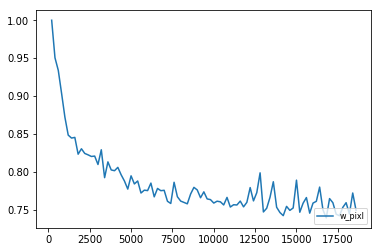

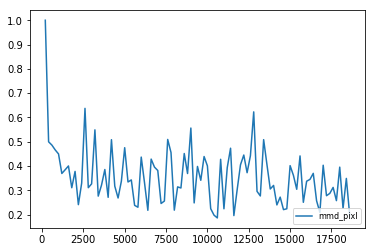

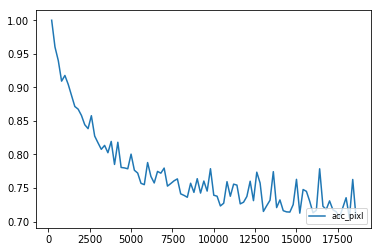

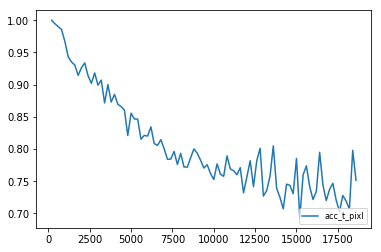

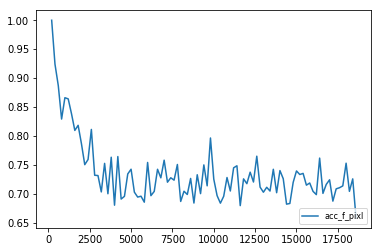

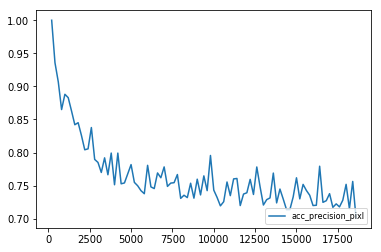

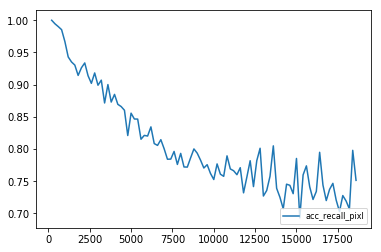

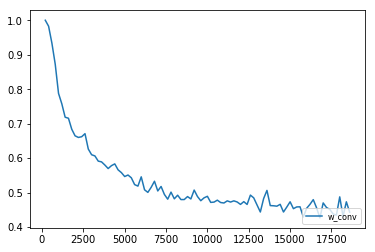

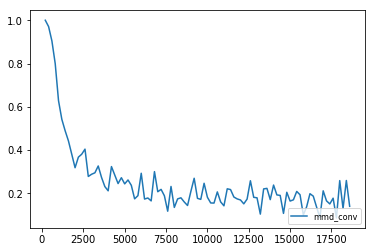

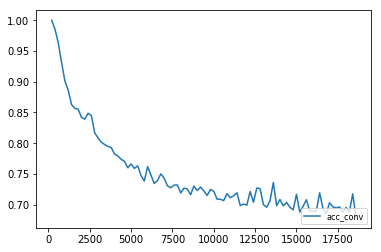

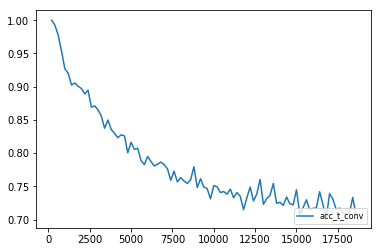

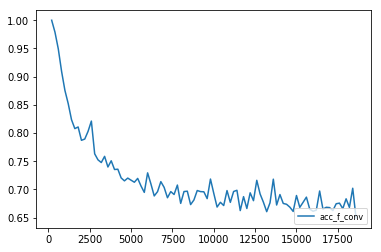

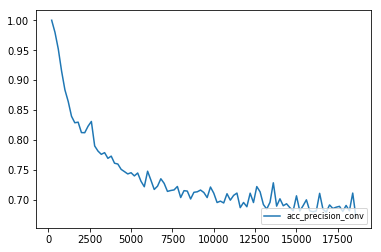

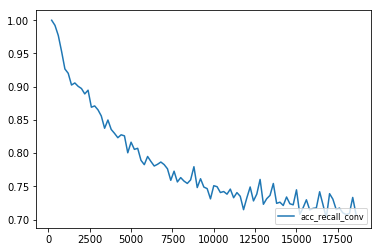

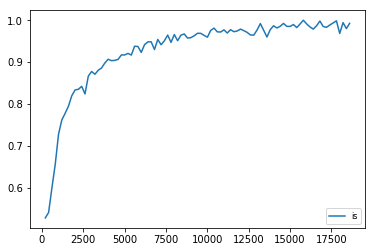

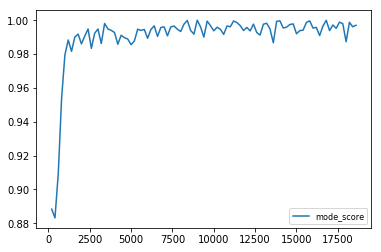

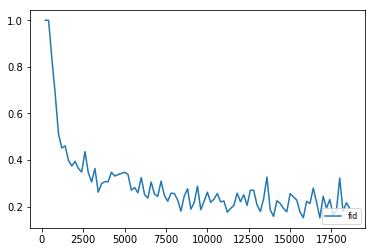

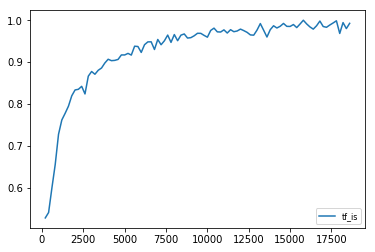

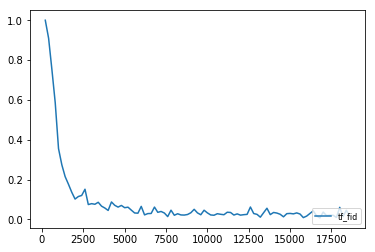

In [2]:

import torch.utils.data as Data

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys
import os
import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.x = []
        self.y = np.zeros((31, 1), dtype=np.int)
        self.y = list(self.y)
        for i in range(31):
            self.y[i] = []

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (X_test, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        X_test = (X_test.astype(np.float32) - 127.5) / 127.5
        # X_test = X_test / 127.5 - 1.
        X_test = np.expand_dims(X_test, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        nb_batches = int(X_train.shape[0] / batch_size)
        global_step = 0

        for epoch in range(epochs):

            for index in range(nb_batches):
                global_step += 1
                imgs = X_train[index * batch_size:(index + 1) * batch_size]
                # labels = y_train[index * batch_size:(index + 1) * batch_size]
                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator (wants discriminator to mistake images as real)
                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                print("epoch:%d step:%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,global_step, d_loss[0], 100 * d_loss[1], g_loss))

                # If at save interval => save generated image samples
                sampleSize = 10000
                # If at save interval => save generated image samples
                if global_step % save_interval == 0:
                    s = self.metrics(global_step, X_test, sampleSize)
        for i in range(len(s)):
            self.y[i] = [float(j) / max(self.y[i]) for j in self.y[i]]#对值进行归一化处理

        for i in range(len(s)):
            font1={'size':8}

            plt.plot(self.x, self.y[i], label=labels_name[i])
            plt.legend(loc='lower right',prop=font1)
            plt.savefig('saved_models_dcgan/{}.png'.format(labels_name[i]))
            plt.show()
            plt.close()

    def metrics(self, epoch, X_test, sampleSize):
        self.x.append(epoch)
        r, c = 10, sampleSize // 10
        noise = np.random.normal(0, 1, (r * c, 100))
#         sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise])
        x_dataset = MyDataset(X_test[:sampleSize])
        # print(x_dataset[0].shape)
        x_real_loader = Data.DataLoader(dataset=x_dataset, batch_size=2000, shuffle=True)
        x_fake_dataset = MyDataset(gen_imgs)
        x_fake_loader = Data.DataLoader(dataset=x_fake_dataset, batch_size=2000, shuffle=True)
        s = compute_score_raw(x_real_loader, x_fake_loader, 256, '/real/', './fake', conv_model='tfgan',
                              workers=int(1))
        real_images = tf.convert_to_tensor(X_test)  # real images
        # MNIST_CLASSIFIER_FROZEN_GRAPH = '.\classify_mnist_graph_def.pb'
        gen_imgs = np.array(gen_imgs)
        eval_images = tf.convert_to_tensor(gen_imgs)
        eval_score = utils.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)  # IS score
        frechet_distance = utils.mnist_frechet_distance(real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)
        mnist_score, f_distance = sess.run([eval_score, frechet_distance])
        # print(mnist_score)
        # print(f_distance)
        # s[14]=mnist_score
        # s[16]=f_distance
        s[17] = mnist_score
        s[18] = f_distance
        print('IS socre: %f' % mnist_score)
        print('FID: %f' % f_distance)

        for i in range(len(s)):
            print(i, "=", s[i])
        for i in range(len(s)):
            self.y[i].append(s[i])
        f.writelines('\n')
        f.writelines('epoch:' + str(epoch))
        f.writelines('\n')
        f.writelines('%.8f' % (i) for i in s)
        f.writelines('\n')
        return s
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=20, batch_size=64, save_interval=200)
